# **Non Homogeneous Hidden Markov Model**

## Library Loading and Configuration

In [1]:
import os
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.5.0"  # Change this path according to your R installation.

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

import seaborn as sns
import numpy as np
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import IntVector

# Enable conversion between pandas and R
pandas2ri.activate()

# Load the R base package
base = importr('base')
# Load the package depmixS4
depmixS4 = importr("depmixS4")
# Set the seed in R for reproducibility
r('set.seed(2030)')
# Set seed in Python for reproducibility
np.random.seed(2030)

## Data loading and preparation:

In [2]:
covid_data = pd.read_excel('../data/raw/covid_data.xlsx',engine='openpyxl')

In [3]:
covid_data.rename(columns={'IM_interno': 'Internal_Mobility_Index',
                           'IM_externo': 'External_Mobility_Index',
                           'inc_pc_comuna': 'Per_Capita_Income',
                           'TasaCasosAcumulados': 'Cumulative_Cases_Rate',
                           'Personas_hogar_promedio': 'Average_Household_Persons',
                           'inmigrantes': 'Immigrants',
                           'total_hog_hacinados': 'Total_Households_Housed',
                           'indic_precariedad_vivienda': 'Housing_Precariousness_Index',
                           'Comuna': 'Commune',
                           'fecha': 'Date',
                           'dias': 'Days',
                           'por_educ_sup': 'Higher_Education_Percentage',
                           'porc_postgrado': 'Postgraduade_Percentage',
                           'IPS_2020': 'Social_Priority_Index_2020',
                           'Prioridad_2020': 'Priority_2020',
                           'CODIGO':'Code',
                           'year': 'Year',
                           'month': 'Month',
                           'paso': 'Step',
                           'paso_etiqueta': 'Step_Label',
                           'Fecha inicio cuarentena': 'Quarantine_Start_Date',
                           'Fecha término cuarentena': 'Quarantine_End_Date',
                           'Casos_Diarios_Brutos': 'Gross_Daily_Cases',
                           'Casos_Diarios_Brutos_MM7': 'Gross_Daily_Cases_Mobile_Average_7_Days'}, inplace=True)

In [4]:
urban_quality= pd.read_csv('../data/raw/urban_quality_of_life_index_2019.csv', sep=";",encoding='utf-8')

In [5]:
# Unir los datasets por la columna 'Commune'
covid_data = pd.merge(covid_data, urban_quality, on="Commune", how="left")

# Verificar el resultado
print(covid_data.columns)


Index(['Internal_Mobility_Index', 'External_Mobility_Index',
       'Per_Capita_Income', 'Cumulative_Cases_Rate',
       'Average_Household_Persons', 'Immigrants', 'Total_Households_Housed',
       'Housing_Precariousness_Index', 'Commune', 'Date', 'Days',
       'Higher_Education_Percentage', 'Postgraduade_Percentage',
       'Social_Priority_Index_2020', 'Priority_2020', 'Code', 'Year', 'Month',
       'Step', 'Step_Label', 'Quarantine_Start_Date', 'Quarantine_End_Date',
       'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days',
       'Employment_Conditions', 'Business_Climate', 'Socio-cultural_Factors',
       'Connectivity_and_Mobility', 'Health_and_Ecology',
       'Housing_and_Urban_Space', 'Urban_Quality_of_Life_Index_2019',
       'Range_ICVU'],
      dtype='object')


In [6]:
df_soc = pd.read_excel('../data/raw/Comunas_Variables_Actualizadas.xlsx',engine='openpyxl')  

In [7]:
df_soc.columns

Index(['CUT', 'Comuna', 'Población', 'Densidad_Pob_Km2', 'Total_Viviendas',
       'Cantidad_Hogares', 'Porc_Hacinamiento', 'Promedio_Personas_Hogar',
       'Porc_Ed_Superior_Terminada', 'Porc_Hogares_con_Migrantes'],
      dtype='object')

In [8]:
df_soc=df_soc.drop(columns=['Comuna'])

In [9]:
df_soc.head()

CUT  Población  Densidad_Pob_Km2  Total_Viviendas  Cantidad_Hogares  \
0  13102      80832           4818.79            24547             24031   
1  13103     132622          11949.60            38020             38646   
2  13104     126955          11427.94            37759             38164   
3  13105     162505          11344.63            47941             47334   
4  13106     147041          10244.43            52486             47009   

   Porc_Hacinamiento  Promedio_Personas_Hogar  Porc_Ed_Superior_Terminada  \
0                  9                      3.3                          72   
1                 13                      3.4                          63   
2                 11                      3.3                          70   
3                 11                      3.4                          68   
4                 12                      3.0                          72   

   Porc_Hogares_con_Migrantes  
0                           7  
1                           7  
2                          11  
3                           4  
4                          20

In [10]:
df_soc.rename(columns={    'CUT':'Code',
                           'Población': 'Poblation',
                           'Densidad_Pob_Km2': 'Density_Pob_Km2',
                           'Total_Viviendas': 'Total_Housing',
                           'Cantidad_Hogares': 'Numbers_Households',
                           'Porc_Hacinamiento': 'Porc_Overcrowding',
                           'Promedio_Personas_Hogar': 'Average_Persons_Households',
                           'Porc_Ed_Superior_Terminada': 'Porc_Higher_Education_Completed',
                           'Porc_Hogares_con_Migrantes': 'Porc_Households_with_Immigrants'}, inplace=True)

In [11]:
covid_data = pd.merge(covid_data, df_soc, on="Code", how="left")

In [12]:
covid_data.columns

Index(['Internal_Mobility_Index', 'External_Mobility_Index',
       'Per_Capita_Income', 'Cumulative_Cases_Rate',
       'Average_Household_Persons', 'Immigrants', 'Total_Households_Housed',
       'Housing_Precariousness_Index', 'Commune', 'Date', 'Days',
       'Higher_Education_Percentage', 'Postgraduade_Percentage',
       'Social_Priority_Index_2020', 'Priority_2020', 'Code', 'Year', 'Month',
       'Step', 'Step_Label', 'Quarantine_Start_Date', 'Quarantine_End_Date',
       'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days',
       'Employment_Conditions', 'Business_Climate', 'Socio-cultural_Factors',
       'Connectivity_and_Mobility', 'Health_and_Ecology',
       'Housing_and_Urban_Space', 'Urban_Quality_of_Life_Index_2019',
       'Range_ICVU', 'Poblation', 'Density_Pob_Km2', 'Total_Housing',
       'Numbers_Households', 'Porc_Overcrowding', 'Average_Persons_Households',
       'Porc_Higher_Education_Completed', 'Porc_Households_with_Immigrants'],
      dtype='obje

In [13]:
exchange_rate_avg = (821.81 + 793.72 + 784.73 + 784.66 + 773.40 + 788.27) / 6
print(exchange_rate_avg)  # Resultado: ~792.43 CLP/USD


791.0983333333334


In [14]:
covid_data['USD_Per_Capita_Income']= covid_data['Per_Capita_Income'] / exchange_rate_avg

### Dictionary of variables:
- **'Internal_Mobility_Index'**: Index of internal mobility of the communes.
- **'External_Mobility_Index'**: Index of external mobility of the communes.
- **'Per_Capita_Income'**: Per capita income of the communes.
- **'Cumulative_Cases_Rate'**: Cumulative case rate per 100,000 population.
- **'Average_Household_Persons'**: Average number of persons per household in the communes.
- **'Inmigrants'**: Percentage of immigrants in the communes.
- **'Total_Households_Housed'**: Percentage of overcrowded households in the communes.
- **'Housing_Precariousness_Index'**: Indicator of housing precariousness in the municipalities.
- **'Commune'**: Name of the commune.
- **'Date'**: Date of observation.
- **'Days'**: Number of days since the beginning of the records.
- **'Higher_Education_Percentage'**: Percentage of people with higher education in the communes.
- **'Postgraduade_Percentage'**: Percentage of people with a postgraduate degree in the communes.
- **'Social_Priority_Index_2020'**: Social Priority Index 2020 of the communes.
- **'Priority_2020'**: 2020 Social Priority of the communes.
- **'Code'**: Code of the commune.
- **'Year'**: Year of observation.
- **'Month'**: Month of observation.
- **'Step'**: Commune Step by Step Plan.
- **'Step_Label'**: Label of the commune's passage in the Step by Step Plan.
- **'Quarantine_Start_Date'**: Quarantine start date.
- **'Quarantine_End_Date'**: Date of end of quarantine.
- **'Gross_Daily_Cases'**: Number of gross daily cases.
- **'Gross_Daily_Cases_Mobile_Average_7_Days'**: Number of gross daily cases with 7-day moving average.
- **'Connectivity_and_Mobility'**: Access and proximity to services associated with public transportation, level of exposure to traffic accidents and internet connection.
- **'Housing_and_Urban_Space'**: The precarious state of housing, as well as the condition of public space in terms of its maintenance and the level of insecurity in the neighborhoods.
- **'Employment_Conditions'**: Labor conditions of the resident population in terms of income, contractual conditions, cost of living and level of indebtedness.
- **'Business_Climate'**: Ability to attract economic activity and new ventures, real estate developments and new public and private services.
- **'Health_and_Ecology'**: Access and proximity to the health network, health gaps and level of environmental exposure in their environment.
- **'Socio-cultural_Factors'**: Aspects related to the development of social capital, according to the offer and results in education, citizen participation and social coexistence.
- **'Urban_Quality_of_Life_Index_2019'**: Urban Quality of Life Index 2019 of the communes.
- **'Range_ICVU'**: Range of the Urban Quality of Life Index 2019 of the communes.

In [15]:
covid_data.to_csv('../data/processed/covid_data_urban_quality_enriched.csv', index=False)

In [16]:
# Remove rows with null values in the relevant columns:
covid_data = covid_data.dropna(subset=['Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days', 'Date'])
# Reset index and add row_id for merge:
covid_data = covid_data.reset_index(drop=True)
covid_data['row_id'] = covid_data.index  # for subsequent merge

## Exploratory Data Analysis (EDA):

### Gross Daily Cases with 7-day moving average:

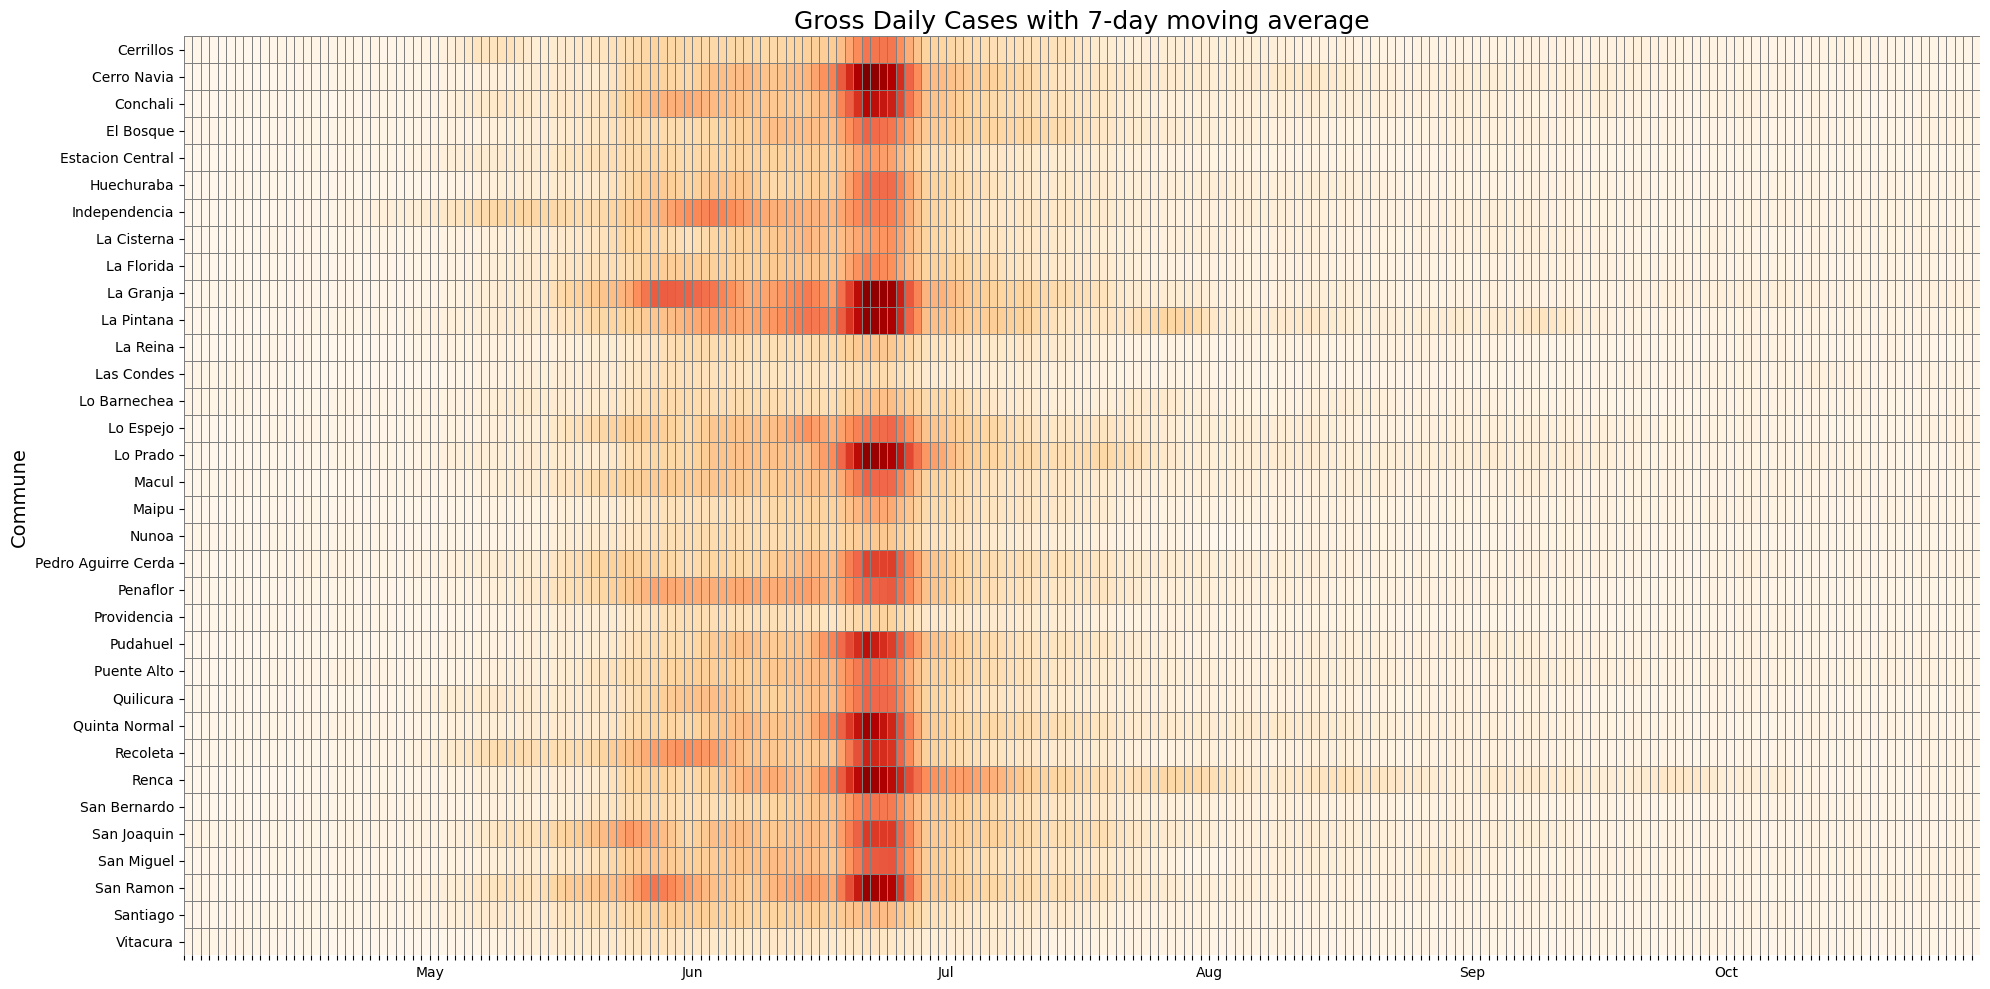

In [17]:
reference_date = covid_data['Date'].min()  # Earliest date in your dataset
covid_data['Days'] = reference_date + pd.to_timedelta(covid_data['Days'], unit='D')

covid_pivot = covid_data.pivot(index='Commune', columns='Days', values='Gross_Daily_Cases_Mobile_Average_7_Days')

# Define the minimum and maximum date range
min_date = covid_data['Date'].min()
max_date = covid_data['Date'].max()

# Create a mapping of Spanish month abbreviations to English
month_mapping = {
    "ene": "Jan", "feb": "Feb", "mar": "Mar", "abr": "Apr",
    "may": "May", "jun": "Jun", "jul": "Jul", "ago": "Aug",
    "sept": "Sep", "oct": "Oct", "nov": "Nov", "dic": "Dec"
}

# Define the minimum and maximum date range
min_date = pd.Timestamp('2020-03-31')
max_date = pd.Timestamp('2020-10-30')

# Filter columns to include only dates within the range
filtered_columns = [col for col in covid_pivot.columns if min_date <= col <= max_date]

fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.heatmap(
    covid_pivot[filtered_columns],  # Use only filtered columns for the heatmap
    cmap='OrRd', 
    linewidths=0.5,
    linecolor='gray',
    cbar=False,
    ax=ax
)

ax.set_xlabel(None)
ax.set_ylabel("Commune", fontsize=14)
ax.set_xticks(range(len(filtered_columns)))

ax.set_xticklabels(
    [month_mapping[date.strftime('%b').strip('.')] if date.day == 1 else '' for date in filtered_columns],
    rotation=0, fontsize=10
)


plt.title('Gross Daily Cases with 7-day moving average', fontsize=18)
plt.tight_layout()
plt.show()



### Internal Mobility Index of each commune over time:

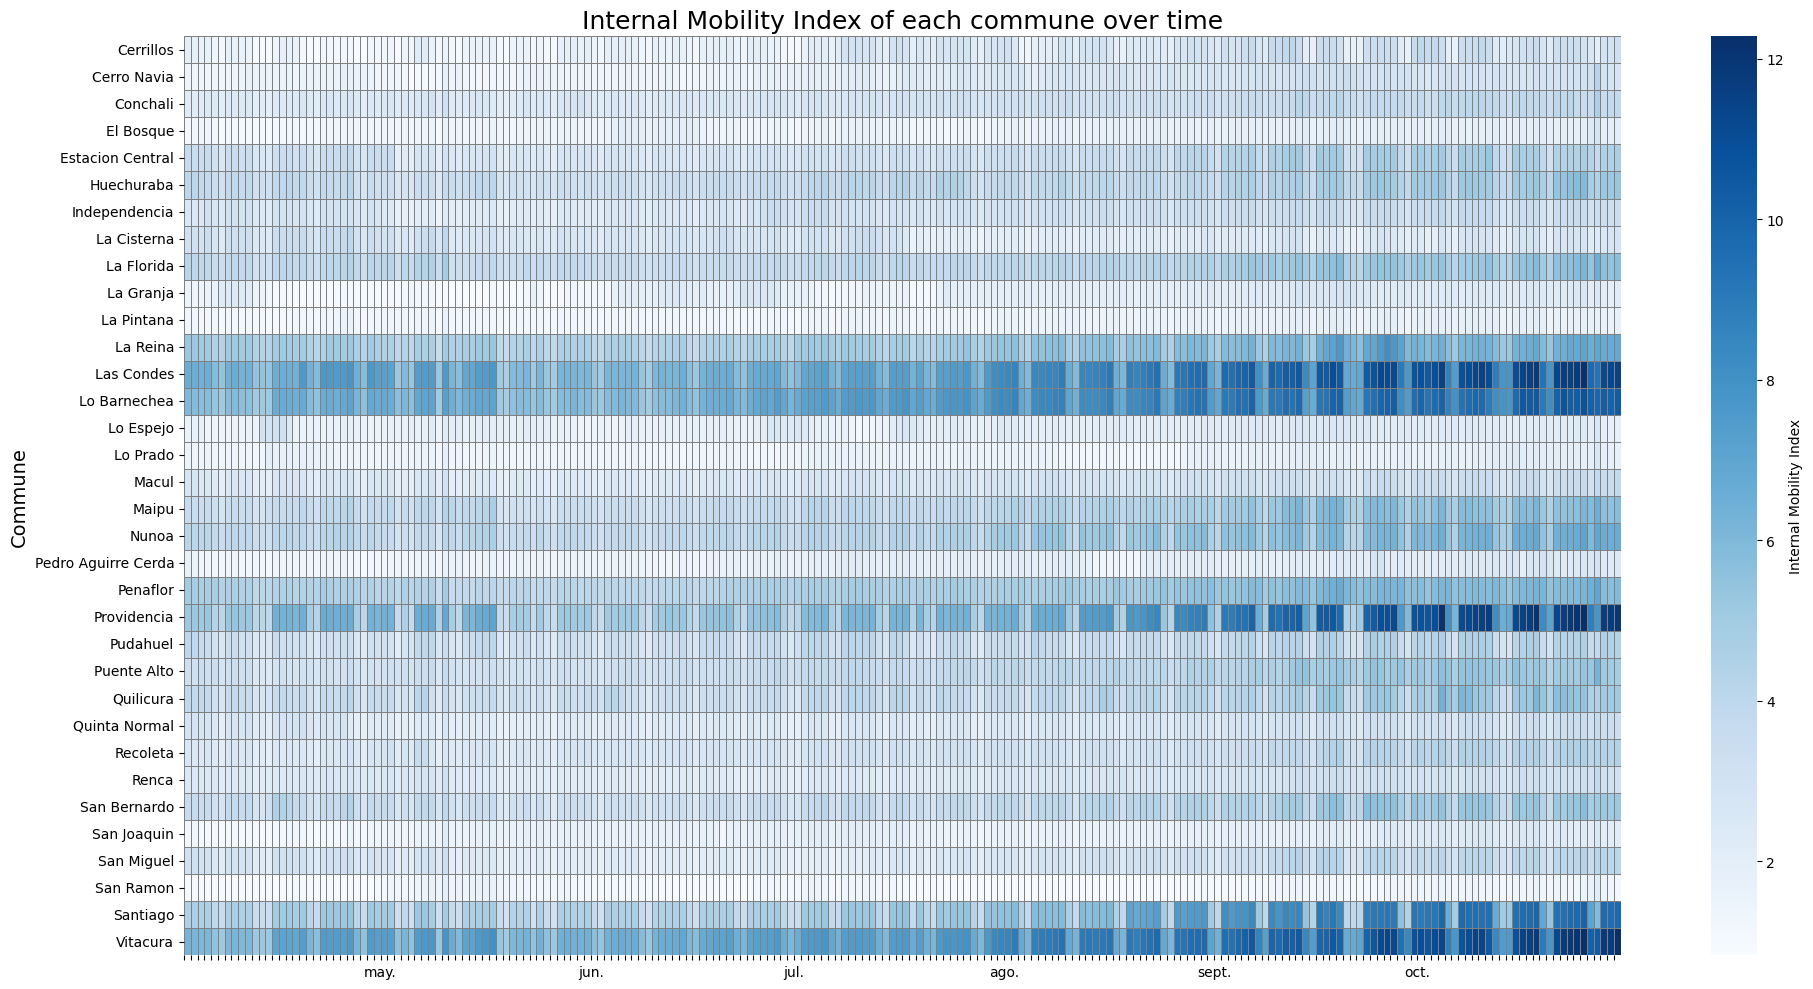

In [18]:
# Definir rango de fechas
min_date = pd.Timestamp('2020-03-31')
max_date = pd.Timestamp('2020-10-30')

# Crear tabla pivot
covid_pivot = covid_data.pivot(index='Commune', columns='Days', values='Internal_Mobility_Index')

# Filtrar por rango de fechas
filtered_columns = [col for col in covid_pivot.columns if min_date <= col <= max_date]
covid_pivot = covid_pivot[filtered_columns]

# Valores mínimos y máximos personalizados para mejorar contraste
vmin = covid_pivot.quantile(0.05).min()  # mínimo más robusto
vmax = covid_pivot.quantile(0.95).max()  # máximo más robusto

# Crear el gráfico
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    covid_pivot,
    cmap='Blues',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Internal Mobility Index'},
    vmin=vmin,  # limitar escala inferior
    vmax=vmax,  # limitar escala superior
    ax=ax
)

# Etiquetas
ax.set_xlabel(None)
ax.set_ylabel("Commune", fontsize=14)

tick_positions = list(range(len(filtered_columns)))
tick_labels = [
    date.strftime('%b') if date.day == 1 else ''
    for date in filtered_columns
]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, fontsize=10)

# Título
plt.title('Internal Mobility Index of each commune over time', fontsize=18)

plt.tight_layout()
plt.show()

### External Mobility Index of each commune over time:

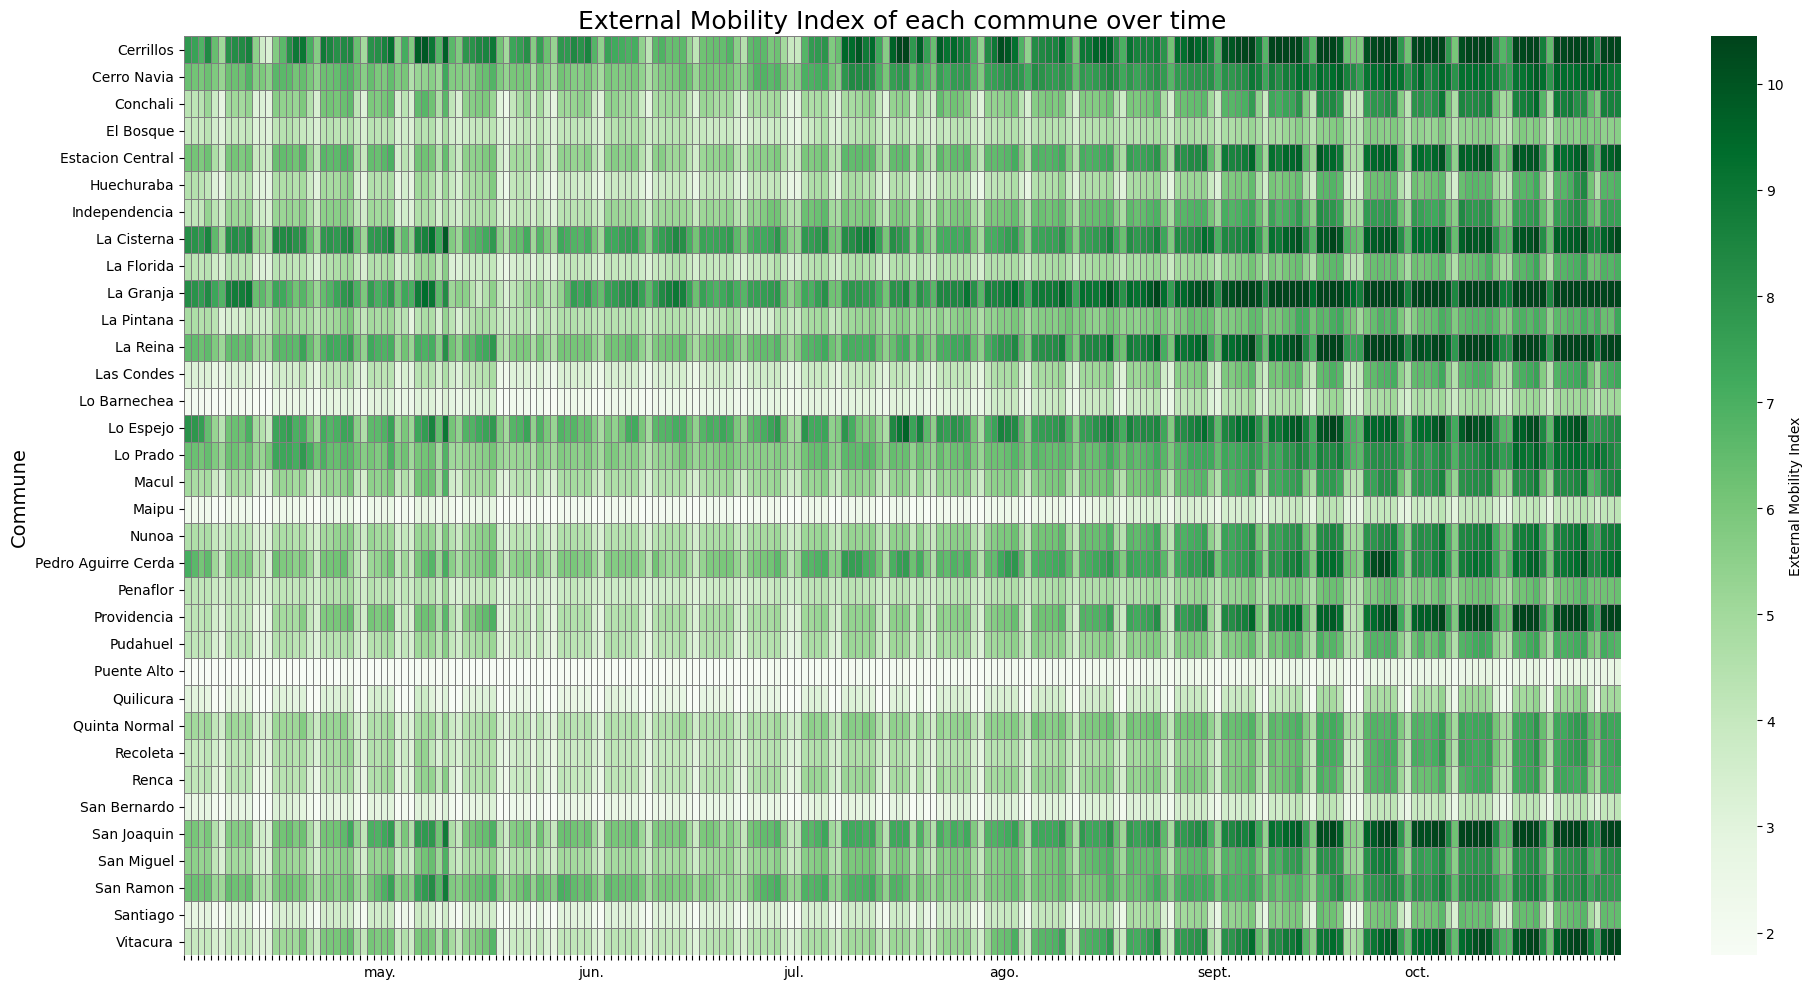

In [19]:
# Definir rango de fechas
min_date = pd.Timestamp('2020-03-31')
max_date = pd.Timestamp('2020-10-30')

# Crear la tabla pivot con el índice de movilidad externa
covid_pivot = covid_data.pivot(index='Commune', columns='Days', values='External_Mobility_Index')

# Filtrar columnas por rango de fechas
filtered_columns = [col for col in covid_pivot.columns if min_date <= col <= max_date]
covid_pivot = covid_pivot[filtered_columns]

# Crear el heatmap
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    covid_pivot,
    cmap='Greens',  # 💚 Paleta verde clara a intensa
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'External Mobility Index'},
    robust=True,  # Mejora el contraste
    ax=ax
)

# Etiquetas de ejes
ax.set_xlabel(None)
ax.set_ylabel("Commune", fontsize=14)

# Etiquetas del eje x (solo el nombre del mes si es el primer día)
tick_positions = list(range(len(filtered_columns)))
tick_labels = [
    date.strftime('%b') if date.day == 1 else ''
    for date in filtered_columns
]

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, fontsize=10)

# Título
plt.title('External Mobility Index of each commune over time', fontsize=18)

# Ajustar diseño
plt.tight_layout()
plt.show()


### Step by Step Plan:

In [20]:
covid_data['Step_Label'].unique()

array(['Sin Medida', 'Cuarentena', 'Transición', 'Preparación',
       'Apertura'], dtype=object)

In [21]:
# Rearrange the Step by Step_Label
remap_step = {'Sin Medida': 'Unrestricted', 'Cuarentena': 'Quarantine', 'Transición':'Transition', 'Preparación':'Preparation','Apertura':'Opening'}
covid_data['Step_Label'] = covid_data['Step_Label'].map(remap_step)

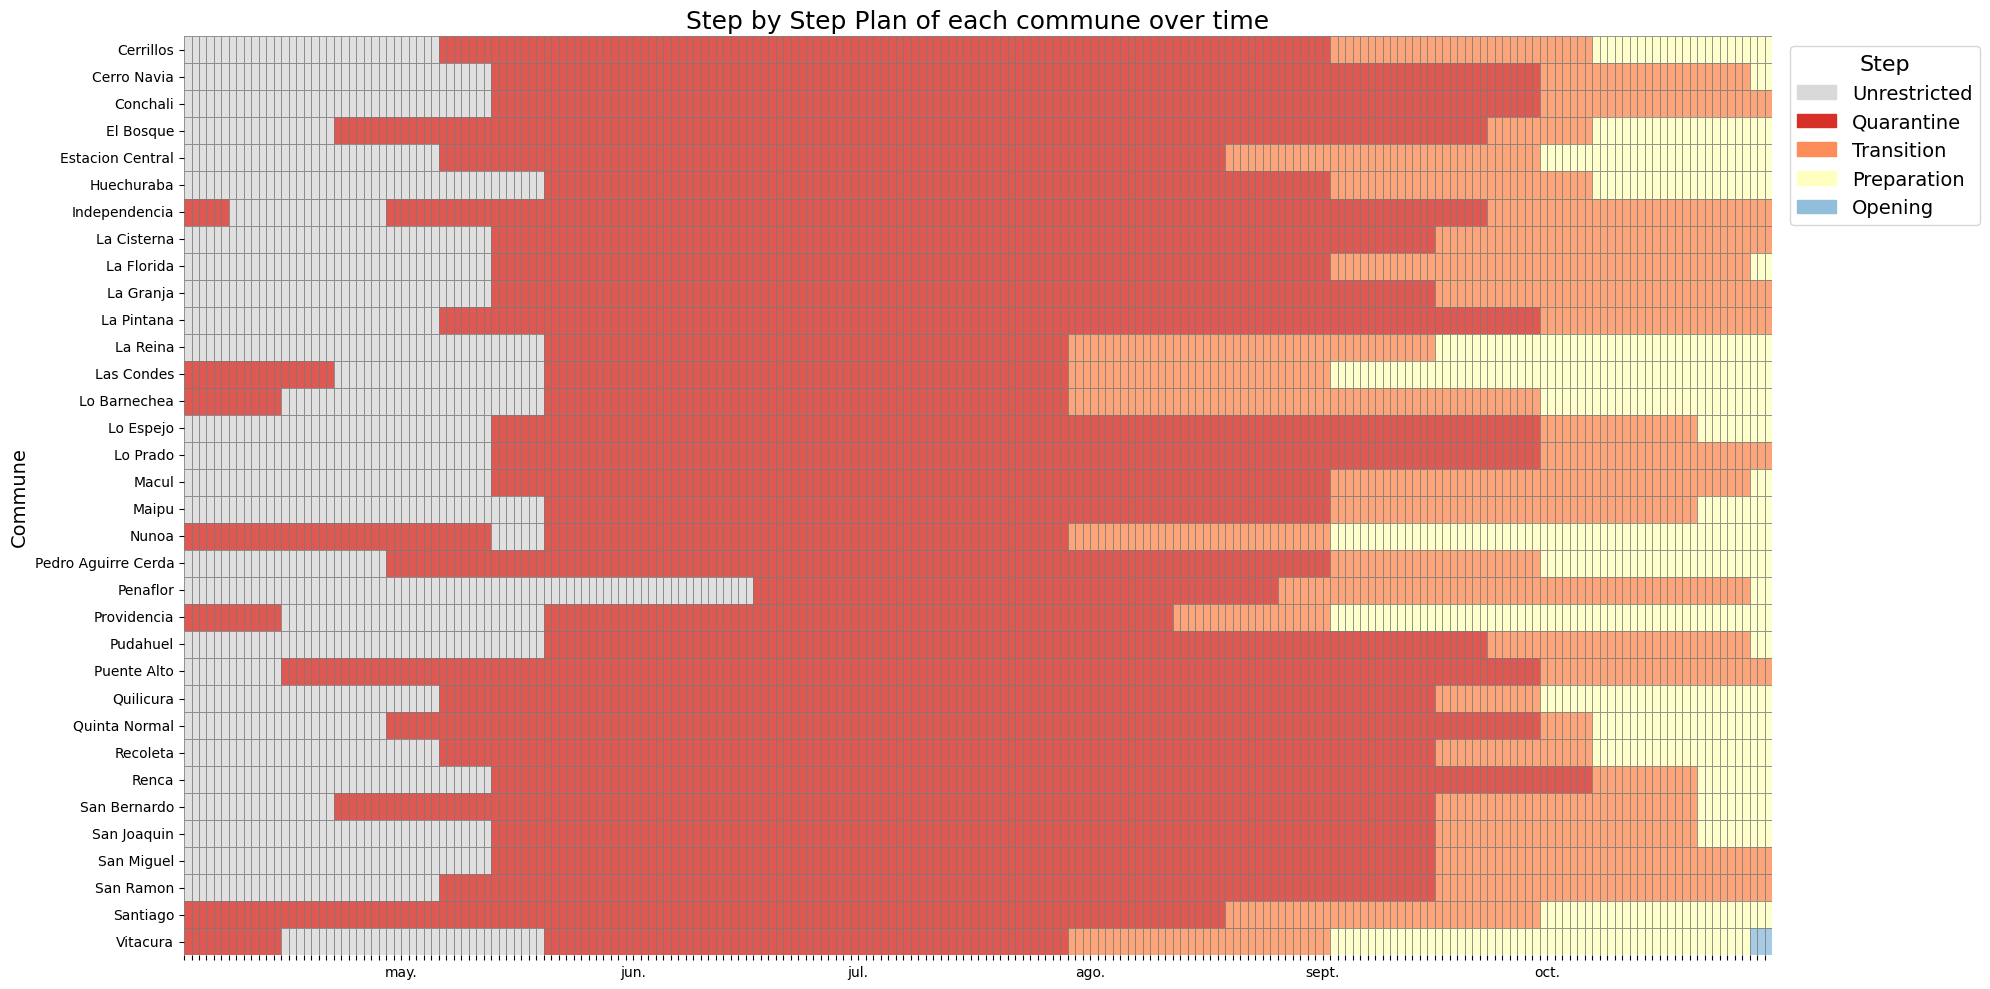

In [22]:
# Definir el rango de fechas
min_date = pd.Timestamp('2020-03-31')
max_date = pd.Timestamp('2020-10-30')

# Crear la tabla pivot de los pasos
covid_pivot = covid_data.pivot(index='Commune', columns='Days', values='Step')

# Filtrar columnas dentro del rango de fechas
filtered_columns = [col for col in covid_pivot.columns if min_date <= col <= max_date]
covid_pivot = covid_pivot[filtered_columns]

# Nueva paleta con amarillo para Preparación y azul para Apertura
step_colors = ['#d9d9d9', '#d73027', '#fc8d59', '#ffffbf', '#91bfdb']
step_labels = ['Unrestricted', 'Quarantine', 'Transition', 'Preparation', 'Opening']

# Crear el heatmap
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    covid_pivot,
    cmap=sns.color_palette(step_colors, as_cmap=True),
    linewidths=0.5,
    linecolor='gray',
    cbar=False,
    ax=ax,
    alpha=0.8  # Ajustar la transparencia
)

# Etiquetas del eje
ax.set_xlabel(None)
ax.set_ylabel("Commune", fontsize=14)

# Etiquetas del eje x: mostrar solo nombre del mes si es el primer día
tick_positions = list(range(len(filtered_columns)))
tick_labels = [
    date.strftime('%b') if date.day == 1 else ''
    for date in filtered_columns
]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, fontsize=10)

# Crear leyenda personalizada
legend_handles = [
    mpatches.Patch(color=color, label=label)
    for color, label in zip(step_colors, step_labels)
]

plt.legend(
    handles=legend_handles,
    title="Step",
    bbox_to_anchor=(1.005, 1),
    loc='upper left',
    fontsize=14,
    title_fontsize=16
)

# Título del gráfico
plt.title('Step by Step Plan of each commune over time', fontsize=18)

# Ajustar diseño
plt.tight_layout()
plt.show()

C:\Users\ferna\AppData\Local\Temp\ipykernel_14792\806463461.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


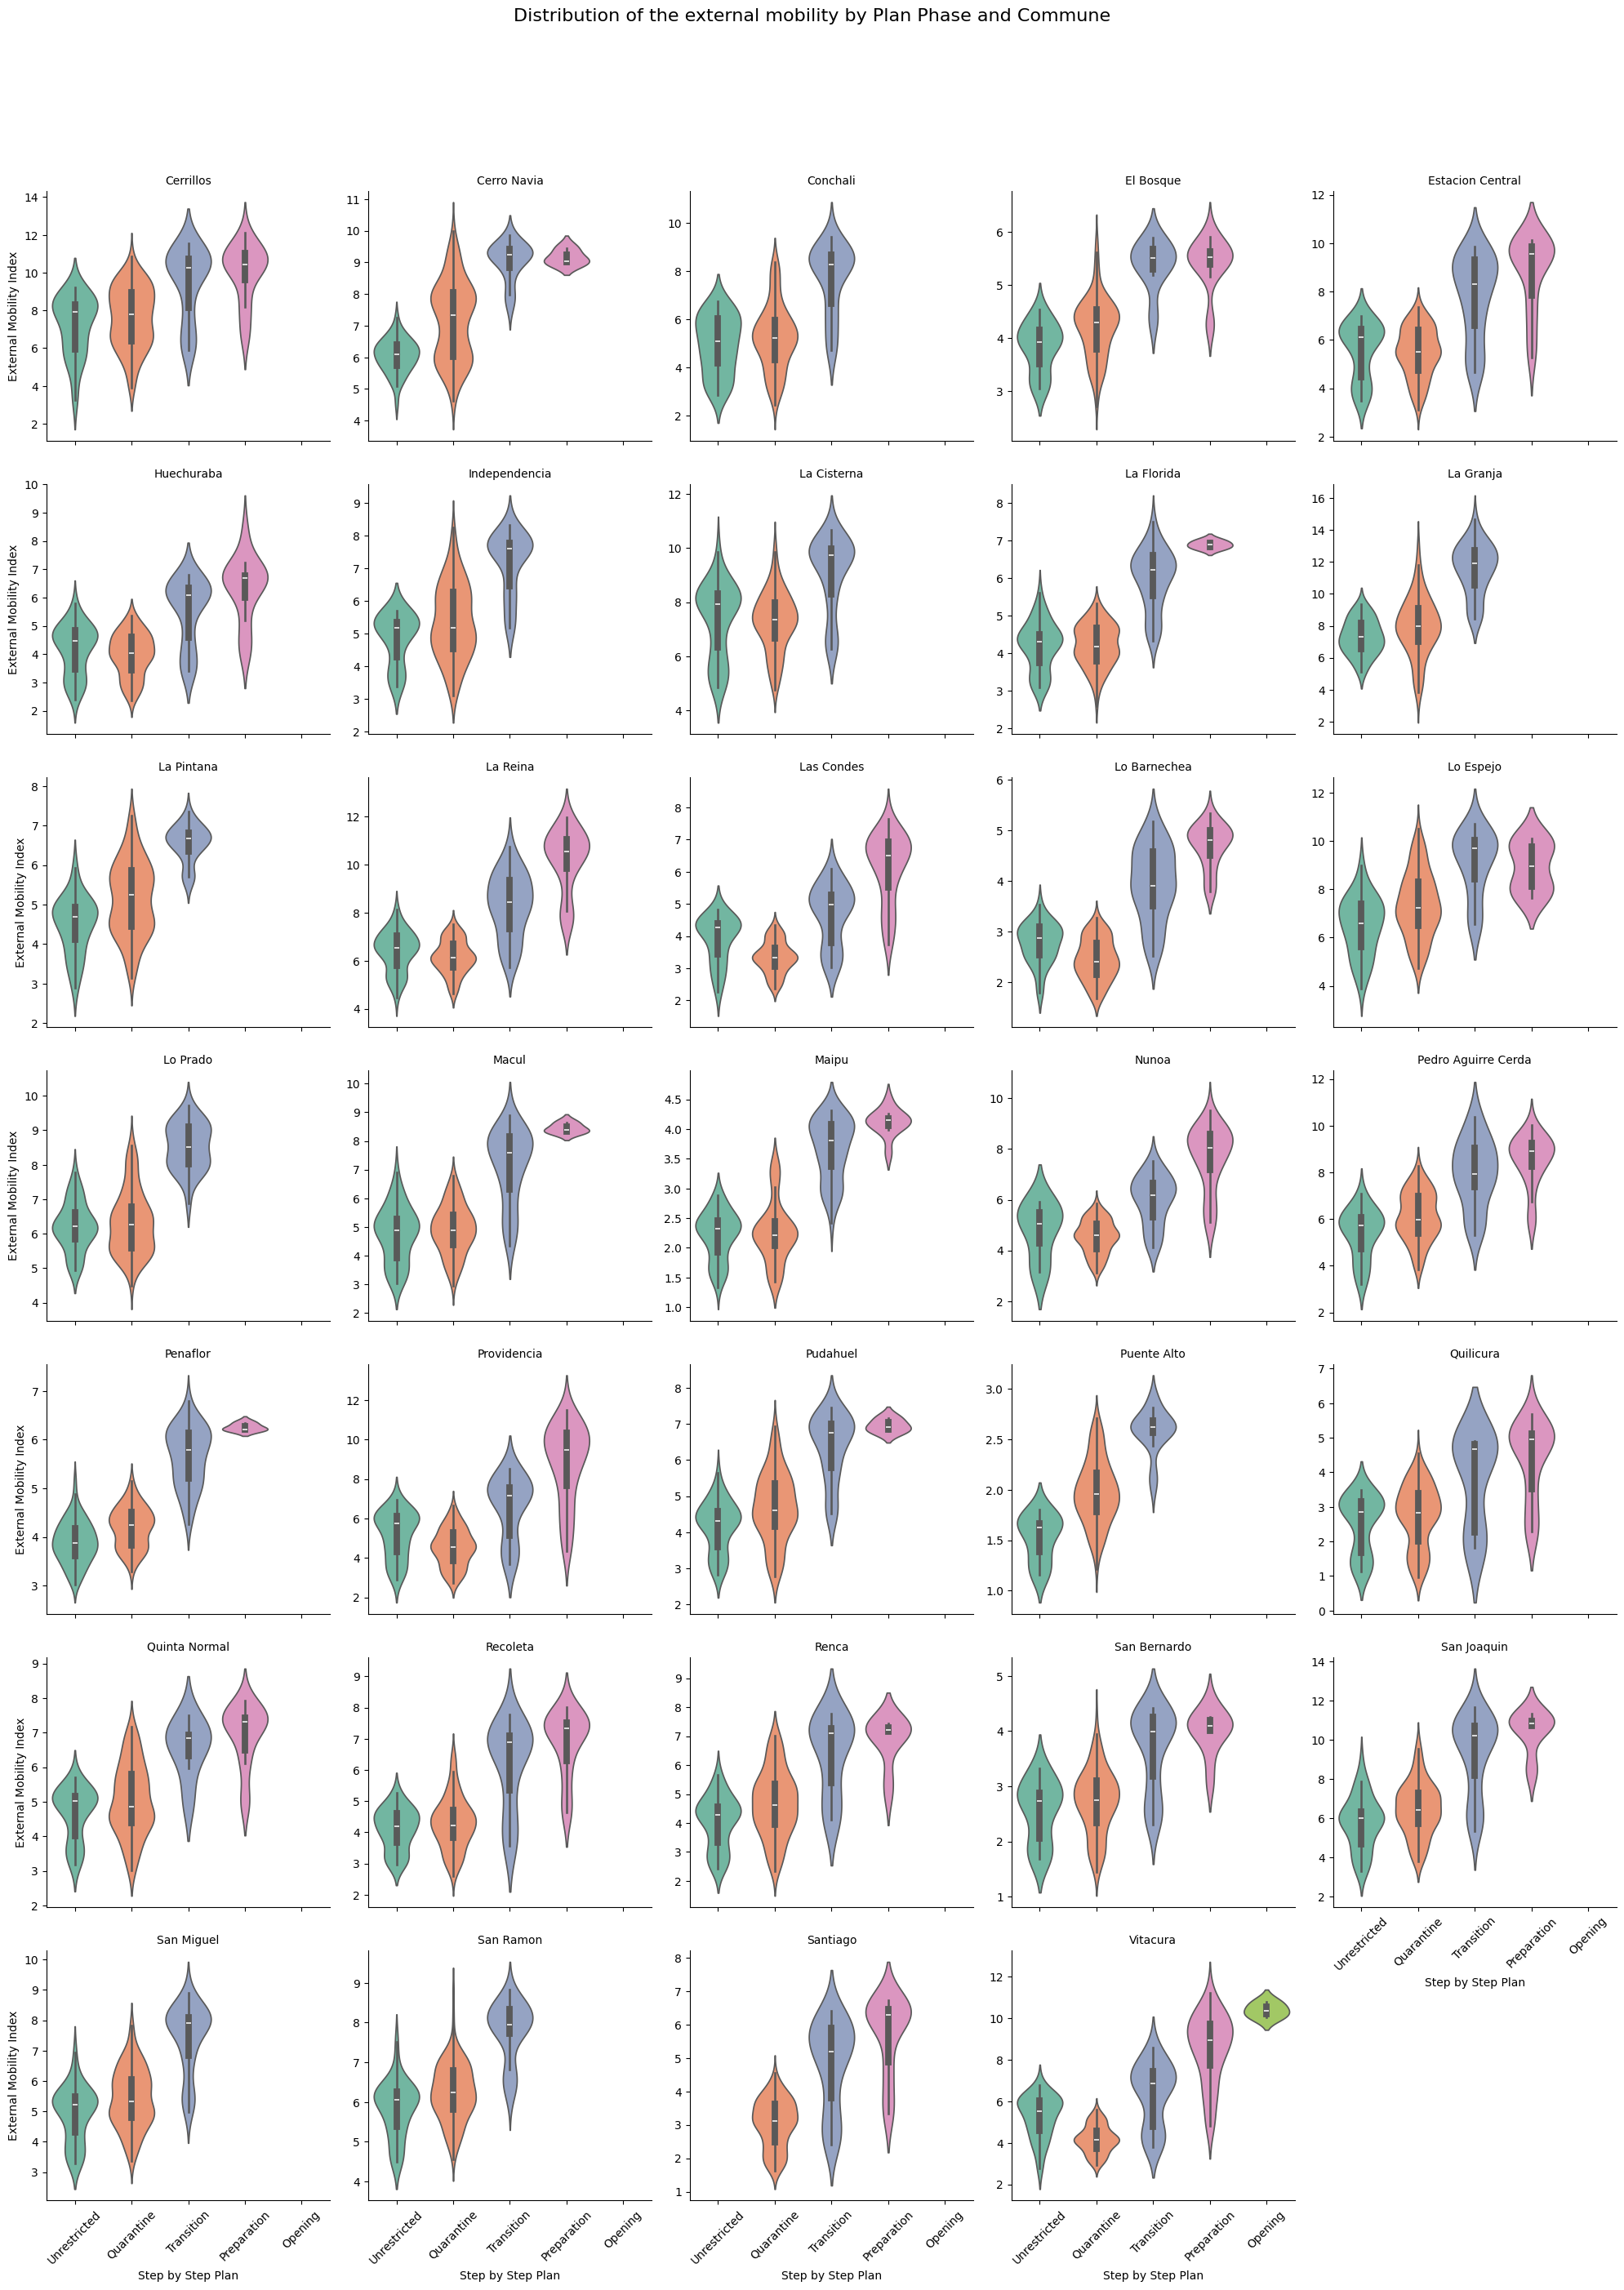

In [23]:

# Filtrar datos para fechas del plan
mask = (covid_data['Days'] >= '2020-03-31') & (covid_data['Days'] <= '2020-10-30')
filtered = covid_data.loc[mask].copy()

# Asegurar tipo string para Step_Label si no está
filtered['Step_Label'] = filtered['Step_Label'].astype(str)

# Gráfico violinplot facetado por comuna
g = sns.catplot(
    data=filtered,
    x='Step_Label', y='External_Mobility_Index',
    col='Commune', col_wrap=5,  # Puedes ajustar a 4 o 6 columnas
    kind='violin',
    palette='Set2',  
    sharey=False, height=4, aspect=1
)

g.set_titles("{col_name}")
g.set_axis_labels("Step by Step Plan", "External Mobility Index")  # Evita que sobrescriba las etiquetas del eje X
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of the external mobility by Plan Phase and Commune", fontsize=16)

# Rotar las etiquetas del eje X en cada subgráfico
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)  # Aplica rotación sin afectar los nombres

plt.show()


## Urban Quality Life Index 2019:


In [24]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Cargar los datos
gdf = gpd.read_file("../data/raw/comunas.shp")

gdf.rename(columns={"CODIGO": "Code"}, inplace=True)

# Unir las tablas
gdf = gdf.merge(covid_data, on="Code", how="left")


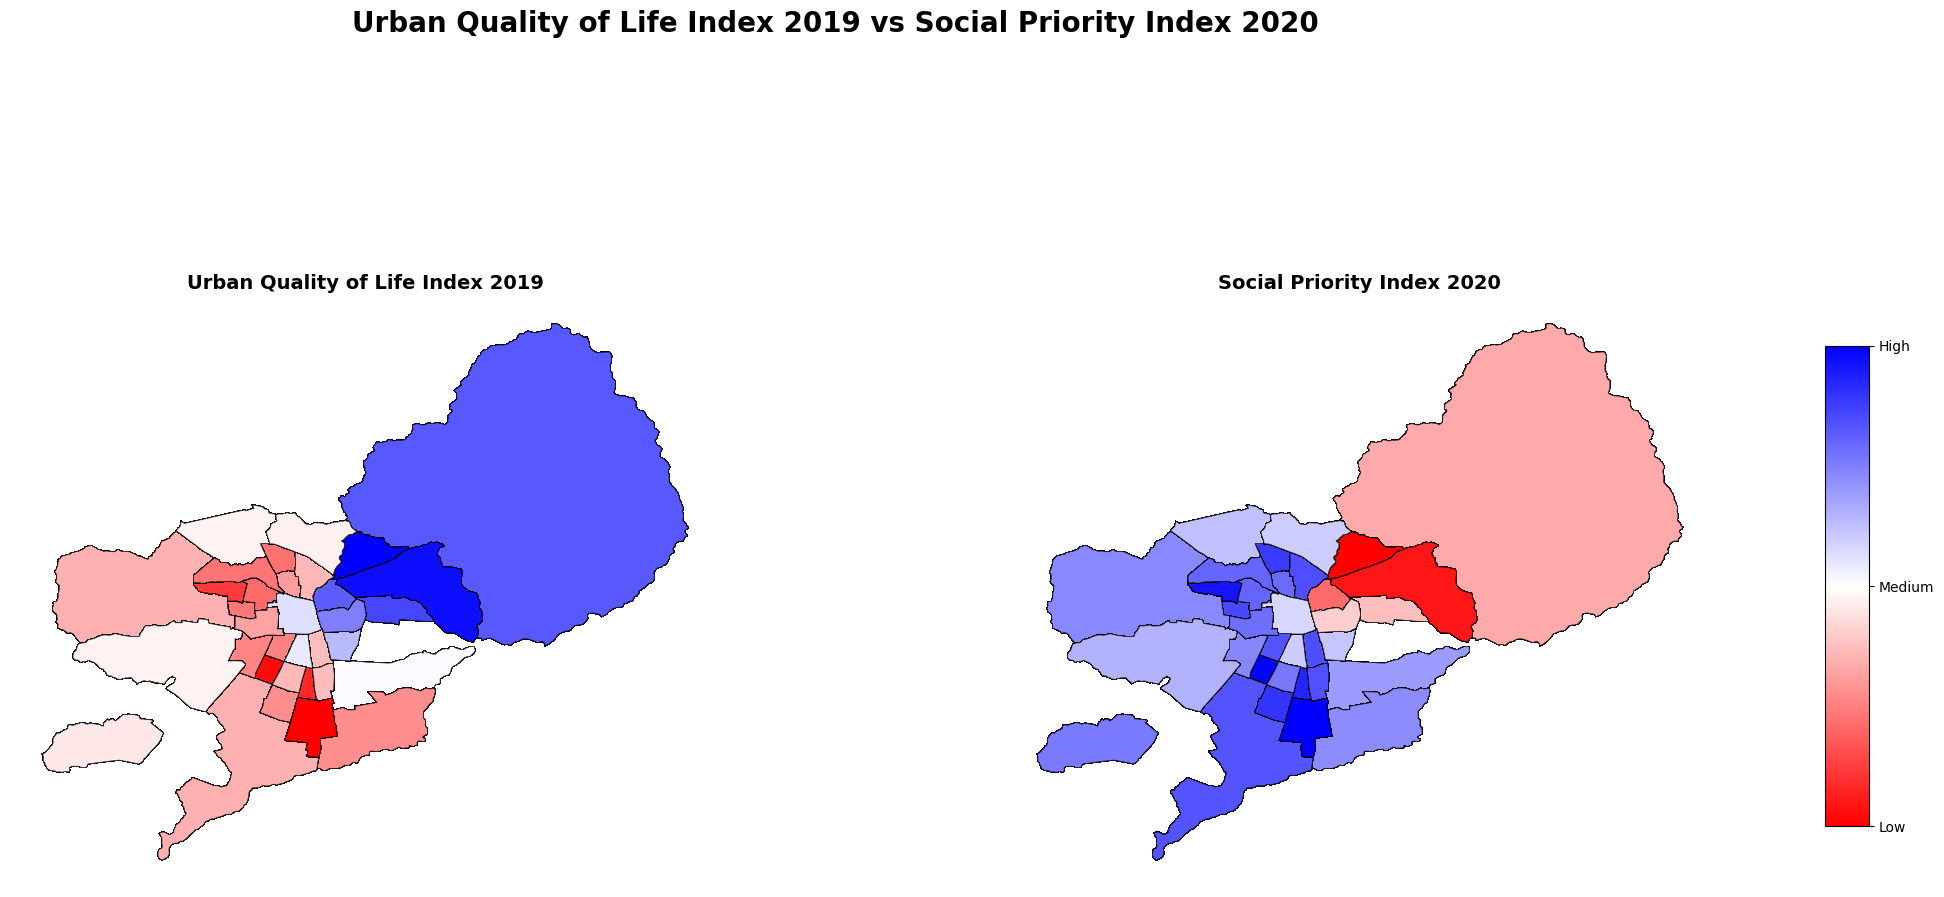

In [25]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Definir las dos columnas de interés (numéricas)
variables = ["Urban_Quality_of_Life_Index_2019", "Social_Priority_Index_2020"]

# Crear la figura con 1 fila y 2 columnas (22 x 12 pulgadas)
fig, axes = plt.subplots(1, 2, figsize=(22, 12))

# Definir un colormap lineal que interpola de rojo (Low) a blanco (medio) a azul (High)
cmap = LinearSegmentedColormap.from_list("red_white_blue", ["red", "white", "blue"])

# Calcular la normalización global tomando el mínimo y máximo de ambas columnas
vmin = gdf[variables].min().min()
vmax = gdf[variables].max().max()

# Iterar sobre las variables y graficarlas en los respectivos subplots
for i, var in enumerate(variables):
    if var in gdf.columns:
        gdf.plot(column=var,
                 cmap=cmap,
                 alpha=0.8,          # Para evitar saturación de colores
                 linewidth=0.5,
                 edgecolor="black",
                 legend=False,
                 ax=axes[i])
        # Se elimina el guion para mayor claridad en el título
        axes[i].set_title(var.replace("_", " "), fontsize=14, fontweight="bold")
        axes[i].axis("off")
    else:
        print(f"⚠️ La columna '{var}' no existe en el GeoDataFrame.")

# Agregar un único colorbar a la derecha
cbar_ax = fig.add_axes([0.95, 0.3, 0.02, 0.4])
# Definir ticks: se ubican en vmin (Low), en el centro y en vmax (High)
ticks = [vmin, (vmin + vmax) / 2, vmax]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm, cax=cbar_ax, ticks=ticks)
cbar_ax.set_yticklabels(["Low", "Medium", "High"])

# Agregar título general al gráfico
plt.suptitle("Urban Quality of Life Index 2019 vs Social Priority Index 2020", 
             fontsize=20, fontweight="bold")

# Ajustar el espacio entre subplots
plt.subplots_adjust(wspace=0.4, hspace=0.3)

# Guardar la imagen en alta resolución
plt.savefig("../results/figures/maps/Quality_Urban_Life_2019_vs_Social_Priority_Index_2020_maps.png", 
            dpi=300, bbox_inches="tight")

plt.show()


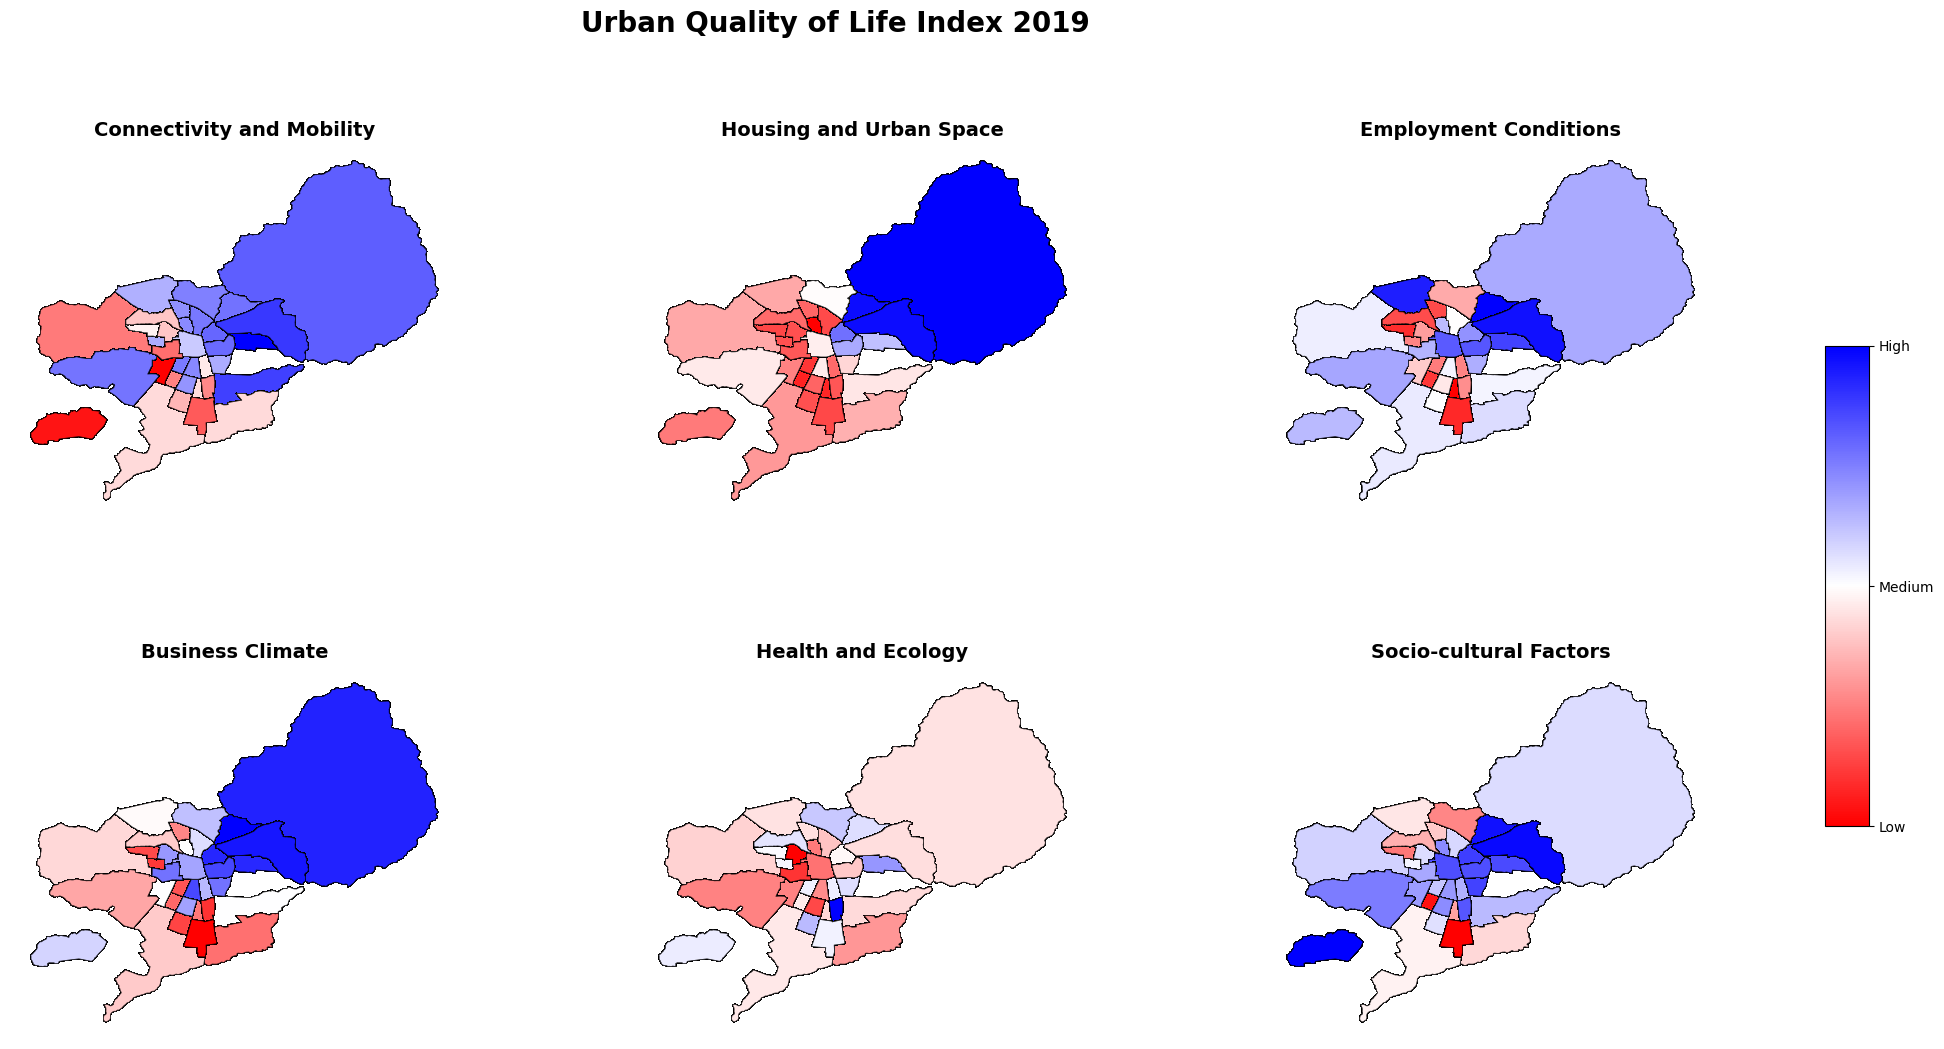

In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Lista de columnas de interés
variables = [
    "Connectivity_and_Mobility",
    "Housing_and_Urban_Space",
    "Employment_Conditions",
    "Business_Climate",
    "Health_and_Ecology",
    "Socio-cultural_Factors"
]

# Crear la figura con 6 subplots distribuidos en 2 filas x 3 columnas
fig, axes = plt.subplots(2, 3, figsize=(22, 12))

# Definir un colormap lineal que vaya de rojo (Low) a blanco (medio) a azul (High)
cmap = LinearSegmentedColormap.from_list("red_white_blue", ["red", "white", "blue"])

# Iterar sobre las variables y asignarlas a cada subplot
for i, var in enumerate(variables):
    row, col = divmod(i, 3)  # Calcula la fila y columna
    if var in gdf.columns:
        gdf.plot(column=var,
                 cmap=cmap,
                 alpha=0.8,          # Transparencia para no saturar los colores
                 linewidth=0.5,
                 edgecolor="black",
                 legend=False,
                 ax=axes[row, col])
        axes[row, col].set_title(var.replace("_", " "), fontsize=14, fontweight="bold")
        axes[row, col].axis("off")
    else:
        print(f"⚠️ La columna '{var}' no existe en el GeoDataFrame.")

# Agregar un único colorbar a la derecha
cbar_ax = fig.add_axes([0.95, 0.3, 0.02, 0.4])
# Definir tick positions para Low, Medium y High: Low en la parte inferior, High en la parte superior
ticks = [0.5, 2.0, 3.5]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0.5, vmax=3.5))
fig.colorbar(sm, cax=cbar_ax, ticks=ticks)
cbar_ax.set_yticklabels(["Low", "Medium", "High"])

# Agregar título general al gráfico
plt.suptitle("Urban Quality of Life Index 2019", fontsize=20, fontweight="bold")

# Ajustar el espacio entre subplots
plt.subplots_adjust(wspace=0.4, hspace=0.3)

# Guardar la imagen en alta resolución
plt.savefig("../results/figures/maps/Quality_Urban_Life_2019_maps.png", dpi=700, bbox_inches="tight")

plt.show()


## Cumulative Cases Rate vs Internal Mobility Index
- Housing and Urban Space
- Employment Conditions

In [27]:
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
import pandas as pd

# Activar conversión automática entre Pandas y R
pandas2ri.activate()

# Importar paquetes de R
base    = importr("base")
ggplot2 = importr("ggplot2")
dplyr   = importr("dplyr")
ggpubr  = importr("ggpubr")
cowplot = importr("cowplot")
showtext= importr("showtext")  # Manejo de fuentes en R

# Desactivar R Graphics (evita la apertura de la ventana de gráficos)
robjects.r('Sys.setenv("DISPLAY"="")')

# Activar showtext en R
robjects.r("showtext_auto()")

# Formatear columnas de covid_data
covid_data["Date"] = pd.to_datetime(covid_data["Date"], errors="coerce").dt.strftime("%Y-%m-%d")
covid_data["Housing_and_Urban_Space"] = pd.to_numeric(covid_data["Housing_and_Urban_Space"], errors="coerce")

# Definir valores clave
dollar_value = 950
dates_of_interest = ["2020-04-13", "2020-06-14", "2020-10-28"]

# Convertir covid_data a formato R y asignarlo al objeto "r_data"
r_data = pandas2ri.py2rpy(covid_data)
robjects.globalenv["r_data"] = r_data

# Crear lista de gráficos en R
robjects.r("graphics_list <- list()")

# Generar gráficos dinámicamente para cada fecha de interés
for day in dates_of_interest:
    r_code = f"""
    library(dplyr)
    library(showtext)
    
    data <- r_data
    data$Date <- as.Date(data$Date, format="%Y-%m-%d")
    # Escalamos Housing_and_Urban_Space dividiéndolo por {dollar_value}
    data <- data %>% mutate(Housing_and_Urban_Space = as.numeric(Housing_and_Urban_Space) / {dollar_value})
    dat1 <- data %>% filter(Date == as.Date('{day}'))
    
    if (nrow(dat1) > 0) {{
        model <- lm(Cumulative_Cases_Rate ~ Internal_Mobility_Index, data = dat1)
        coefficients <- coef(model)
        equation <- paste0("y = ", round(coefficients[2], 2), "x + ", round(coefficients[1], 2))
        r_squared <- paste0("R\u00B2 = ", round(summary(model)$r.squared, 2))
    
        g <- ggplot(dat1, aes(x = Internal_Mobility_Index, y = Cumulative_Cases_Rate)) +
            geom_point(aes(size = Housing_and_Urban_Space, fill = Employment_Conditions),
                       shape = 21, color = "black", alpha = 0.8) +
            geom_smooth(method = "lm", color = "darkred", fill = "gray80", se = TRUE) +
            labs(x = "Internal Mobility Index", y = "Cumulative Case Rate per 100,000 inhabitants",
                 size = "Housing and Urban Space", fill = "Employment Conditions") +
            annotate("text", x = max(dat1$Internal_Mobility_Index) * 0.45,
                     y = max(dat1$Cumulative_Cases_Rate) * 0.9,
                     label = equation, hjust = 0, size = 6, family = "sans") +
            annotate("text", x = max(dat1$Internal_Mobility_Index) * 0.45,
                     y = max(dat1$Cumulative_Cases_Rate) * 0.8,
                     label = r_squared, hjust = 0, size = 6, family = "sans") +
            theme_minimal(base_family = "sans") +
            theme(legend.position = "none")
    
        assign("g_{day.replace('-', '_')}", g, envir = .GlobalEnv)
        graphics_list <- append(graphics_list, list(g_{day.replace('-', '_')}))
    }} else {{
        print("No data available for the selected date: {day}")
    }}
    """
    robjects.r(r_code)

# Unir y exportar el panel final sin desplegar R Graphics,
# haciendo que la leyenda de Housing_and_Urban_Space muestre los valores reales.
robjects.r(f"""
library(ggplot2)
library(cowplot)
library(ggpubr)

# Definir los breaks en unidades originales para Housing_and_Urban_Space
original_breaks <- c(10, 30, 50, 70, 90)
# Como se escal\u00F3 dividi\u00E9ndolo por {dollar_value}, los breaks en el dominio son:
scaled_breaks <- original_breaks / {dollar_value}

# Limpiar y ajustar cada gr\u00E1fico individual siguiendo la metodolog\u00EDa de ejemplo:
g1_clean <- graphics_list[[1]] + 
  theme(
    plot.title = element_blank(),
    plot.subtitle = element_blank(),
    axis.title.y = element_text(size = 12),
    axis.title.x = element_blank(),
    plot.caption = element_blank(),
    legend.position = "none"
  ) +
  guides(size = "none") +
  theme(legend.position = "bottom",
        legend.box = "horizontal",
        legend.title = element_text(size = 12),
        legend.text = element_text(size = 10)) +
  scale_size_continuous(range = c(2, 10),
                        breaks = scaled_breaks,
                        labels = original_breaks,
                        name = "Housing and Urban Space")

g2_clean <- graphics_list[[2]] +
  theme(
    plot.title = element_blank(),
    plot.subtitle = element_blank(),
    axis.title.y = element_blank(),
    axis.title.x = element_text(size = 12),
    axis.text.y = element_blank(),
    plot.caption = element_blank(),
    legend.position = "none"
  ) +
  scale_size_continuous(range = c(2, 10),
                        breaks = scaled_breaks,
                        labels = original_breaks,
                        name = "Housing and Urban Space")

g3_clean <- graphics_list[[3]] +
  theme(
    plot.title = element_blank(),
    plot.subtitle = element_blank(),
    axis.title.y = element_blank(),
    axis.text.y = element_blank(),
    axis.title.x = element_blank(),
    plot.caption = element_blank(),
    legend.position = "none"
  ) +
  guides(fill = "none") +
  theme(legend.position = "bottom",
        legend.box = "horizontal",
        legend.title = element_text(size = 12),
        legend.text = element_text(size = 10)) +
  scale_size_continuous(range = c(2, 10),
                        breaks = scaled_breaks,
                        labels = original_breaks,
                        name = "Housing and Urban Space")

# Combinar los tres subplots en una sola fila
panel_row <- plot_grid(g1_clean, g2_clean, g3_clean, ncol = 3, align = "hv", labels = NULL)

# Definir la ruta de salida
m <- "../results/figures"
path1 <- file.path(m, "covid19_three_panels_1_highres.png")
path2 <- file.path(m, "covid19_three_panels_1_highres.pdf")

# Guardar la figura final sin desplegar la ventana de R Graphics
ggsave(path1, panel_row, dpi = 700, width = 15.5, height = 7)
ggsave(path2, panel_row, dpi = 700, width = 15.5, height = 7)
""")


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


## Cumulative Cases Rate vs Internal Mobility Index
- Housing and Urban Space
- Health and Ecology

In [28]:
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
import pandas as pd

# Activar conversión automática entre Pandas y R
pandas2ri.activate()

# Importar paquetes de R
base     = importr("base")
ggplot2  = importr("ggplot2")
dplyr    = importr("dplyr")
ggpubr   = importr("ggpubr")
cowplot  = importr("cowplot")
showtext = importr("showtext")  # Manejo de fuentes en R

# Desactivar R Graphics (evita la apertura de la ventana de gráficos)
robjects.r('Sys.setenv("DISPLAY"="")')

# Activar showtext en R para el manejo de fuentes
robjects.r("showtext_auto()")

# Formatear columnas de covid_data
covid_data["Date"] = pd.to_datetime(covid_data["Date"], errors="coerce").dt.strftime("%Y-%m-%d")
covid_data["Housing_and_Urban_Space"] = pd.to_numeric(covid_data["Housing_and_Urban_Space"], errors="coerce")

# Se utilizará Health_and_Ecology para el mapeo de fill.
# Asegúrate de que la columna exista en covid_data:
covid_data["Health_and_Ecology"] = pd.to_numeric(covid_data["Health_and_Ecology"], errors="coerce")

# Definir valores clave
dollar_value = 950
dates_of_interest = ["2020-04-13", "2020-06-14", "2020-10-28"]

# Convertir covid_data a formato R y asignarlo al objeto "r_data"
r_data = pandas2ri.py2rpy(covid_data)
robjects.globalenv["r_data"] = r_data

# Crear lista de gráficos en R
robjects.r("graphics_list <- list()")

# Generar gráficos dinámicamente para cada fecha de interés.
# Se estima: Cumulative_Cases_Rate ~ Internal_Mobility_Index
# Con est\u00E9ticas: size = Housing_and_Urban_Space (escalada) y fill = Health_and_Ecology
for day in dates_of_interest:
    r_code = f'''
    library(dplyr)
    library(showtext)
    
    data <- r_data
    data$Date <- as.Date(data$Date, format="%Y-%m-%d")
    # Escalamos Housing_and_Urban_Space dividi\u00E9ndolo por {dollar_value}
    data <- data %>% mutate(Housing_and_Urban_Space = as.numeric(Housing_and_Urban_Space) / {dollar_value})
    dat1 <- data %>% filter(Date == as.Date("{day}"))
    
    if(nrow(dat1) > 0) {{
        model <- lm(Cumulative_Cases_Rate ~ Internal_Mobility_Index, data = dat1)
        coefficients <- coef(model)
        equation <- paste0("y = ", round(coefficients[2], 2), "x + ", round(coefficients[1], 2))
        r_squared <- paste0("R\u00B2 = ", round(summary(model)$r.squared, 2))
    
        g <- ggplot(dat1, aes(x = Internal_Mobility_Index, y = Cumulative_Cases_Rate)) +
             geom_point(aes(size = Housing_and_Urban_Space,
                            fill = Health_and_Ecology),
                        shape = 21, color = "black", alpha = 0.8) +
             geom_smooth(method = "lm", color = "darkred", fill = "gray80", se = TRUE) +
             labs(x = "Internal Mobility Index",
                  y = "Cumulative Case Rate per 100,000 inhabitants",
                  size = "Housing and Urban Space", 
                  fill = "Health and Ecology") +
             annotate("text", x = max(dat1$Internal_Mobility_Index)*0.45,
                      y = max(dat1$Cumulative_Cases_Rate)*0.9,
                      label = equation, hjust = 0, size = 6, family = "sans") +
             annotate("text", x = max(dat1$Internal_Mobility_Index)*0.45,
                      y = max(dat1$Cumulative_Cases_Rate)*0.8,
                      label = r_squared, hjust = 0, size = 6, family = "sans") +
             theme_minimal(base_family = "sans") +
             theme(legend.position = "none")
    
        assign("g_{day.replace('-', '_')}", g, envir = .GlobalEnv)
        graphics_list <- append(graphics_list, list(g_{day.replace('-', '_')}))
    }} else {{
        print(paste("No data available for the selected date:", "{day}"))
    }}
    '''
    robjects.r(r_code)

# Unir y exportar el panel final sin desplegar R Graphics.
# Configuramos la escala de tama\u00F1o para que en la leyenda se muestren los valores reales 
# de Housing and Urban Space. Se establece un vector de breaks (por ejemplo: 10, 30, 50, 70, 90)
# y se calcula el escalado inverso (ya que se escal\u00F3 dividiendo por {dollar_value}).
robjects.r(f'''
library(ggplot2)
library(cowplot)
library(ggpubr)

# Definir los breaks en unidades originales para Housing and Urban Space
original_breaks <- c(10, 30, 50, 70, 90)
# Como se escal\u00F3 dividi\u00E9ndolo por {dollar_value}, los breaks en el dominio son:
scaled_breaks <- original_breaks / {dollar_value}

# Limpiar y ajustar cada gr\u00E1fico individual siguiendo la metodolog\u00EDa de ejemplo:
g1_clean <- graphics_list[[1]] + 
  theme(
    plot.title = element_blank(),
    plot.subtitle = element_blank(),
    axis.title.y = element_text(size = 12),
    axis.title.x = element_blank(),
    plot.caption = element_blank(),
    legend.position = "none"
  ) +
  guides(size = "none") +
  theme(legend.position = "bottom",
        legend.box = "horizontal",
        legend.title = element_text(size = 12),
        legend.text = element_text(size = 10)) +
  scale_size_continuous(range = c(2, 10),
                        breaks = scaled_breaks,
                        labels = original_breaks,
                        name = "Housing and Urban Space")

g2_clean <- graphics_list[[2]] +
  theme(
    plot.title = element_blank(),
    plot.subtitle = element_blank(),
    axis.title.y = element_blank(),
    axis.title.x = element_text(size = 12),
    axis.text.y = element_blank(),
    plot.caption = element_blank(),
    legend.position = "none"
  ) +
  scale_size_continuous(range = c(2, 10),
                        breaks = scaled_breaks,
                        labels = original_breaks,
                        name = "Housing and Urban Space")

g3_clean <- graphics_list[[3]] +
  theme(
    plot.title = element_blank(),
    plot.subtitle = element_blank(),
    axis.title.y = element_blank(),
    axis.text.y = element_blank(),
    axis.title.x = element_blank(),
    plot.caption = element_blank(),
    legend.position = "none"
  ) +
  guides(fill = "none") +
  theme(legend.position = "bottom",
        legend.box = "horizontal",
        legend.title = element_text(size = 12),
        legend.text = element_text(size = 10)) +
  scale_size_continuous(range = c(2, 10),
                        breaks = scaled_breaks,
                        labels = original_breaks,
                        name = "Housing and Urban Space")

# Extraer una leyenda combinada usando un gr\u00E1fico dummy basado en el primero
legend_plot <- graphics_list[[1]] +
  scale_size_continuous(range = c(2, 10),
                        breaks = scaled_breaks,
                        labels = original_breaks,
                        name = "Housing and Urban Space") +
  theme(legend.position = "bottom",
        legend.box = "horizontal",
        legend.title = element_text(size = 12),
        legend.text = element_text(size = 10))
legend_extracted <- cowplot::get_legend(legend_plot)

# Combinar los tres subplots en una sola fila
panel_row <- plot_grid(g1_clean, g2_clean, g3_clean, ncol = 3, align = "hv", labels = NULL)

# Combinar el panel de subplots con la leyenda extra\u00EDda; se asigna mayor espacio a la leyenda.
final_plot <- plot_grid(panel_row, legend_extracted, ncol = 1, rel_heights = c(1, 0.35))

# Definir la ruta de salida
m <- "../results/figures"
path1 <- file.path(m, "covid19_three_panels_2_highres.png")
path2 <- file.path(m, "covid19_three_panels_2_highres.pdf")

# Guardar la figura final sin desplegar la ventana de R Graphics
ggsave(path1, final_plot, dpi = 700, width = 15.5, height = 7)
ggsave(path2, final_plot, dpi = 700, width = 15.5, height = 7)
''')


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In get_plot_component(plot, "guide-box") :
R[write to console]: 
 
R[write to console]:  Multiple components found; returning the first one. To return all, use `return_all = TRUE`.



## Cumulative Cases Rate vs Internal Mobility Index
- Urban Quality of Life Index 2019
- Social Priority Index 2020

In [29]:
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
import pandas as pd

# Activar conversión automática entre Pandas y R
pandas2ri.activate()

# Importar paquetes de R
base       = importr("base")
ggplot2    = importr("ggplot2")
dplyr      = importr("dplyr")
ggpubr     = importr("ggpubr")
cowplot    = importr("cowplot")
showtext   = importr("showtext")  # Manejo de fuentes en R

# Desactivar R Graphics (evita la apertura de la ventana de gráficos)
robjects.r('Sys.setenv("DISPLAY"="")')

# Activar showtext en R para el manejo de fuentes 
robjects.r("showtext_auto()")

# Formatear columnas de covid_data
covid_data["Date"] = pd.to_datetime(covid_data["Date"], errors="coerce").dt.strftime("%Y-%m-%d")
covid_data["Urban_Quality_of_Life_Index_2019"] = pd.to_numeric(covid_data["Urban_Quality_of_Life_Index_2019"], errors="coerce")
covid_data["Social_Priority_Index_2020"] = pd.to_numeric(covid_data["Social_Priority_Index_2020"], errors="coerce")
# Asegurarse de que Range_ICVU sea de tipo caracter (o factor posteriormente)
covid_data["Range_ICVU"] = covid_data["Range_ICVU"].astype(str)

# Definir fechas de interés
dates_of_interest = ["2020-04-13", "2020-06-14", "2020-10-28"]

# Convertir covid_data a formato R y asignarlo al objeto "r_data"
r_data = pandas2ri.py2rpy(covid_data)
robjects.globalenv["r_data"] = r_data

# Crear lista de gráficos en R
robjects.r("graphics_list <- list()")

# Generar gráficos dinámicamente para cada fecha de interés.
# Se estima: Cumulative_Cases_Rate ~ Internal_Mobility_Index
# Estéticas: size = Social_Priority_Index_2020, fill = Range_ICVU.
for day in dates_of_interest:
    r_code = f'''
    library(dplyr)
    library(showtext)
    
    data <- r_data
    data$Date <- as.Date(data$Date, format = "%Y-%m-%d")
    dat1 <- data %>% filter(Date == as.Date("{day}"))
    
    if (nrow(dat1) > 0) {{
        model <- lm(Cumulative_Cases_Rate ~ Internal_Mobility_Index, data = dat1)
        coefficients <- coef(model)
        equation <- paste0("y = ", round(coefficients[2], 2), "x + ", round(coefficients[1], 2))
        r_squared <- paste0("R\u00B2 = ", round(summary(model)$r.squared, 2))
        
        g <- ggplot(dat1, aes(x = Internal_Mobility_Index, y = Cumulative_Cases_Rate)) +
            geom_point(aes(size = Social_Priority_Index_2020,
                           fill = Range_ICVU),
                       shape = 21, color = "black", alpha = 0.8) +
            geom_smooth(method = "lm", color = "darkred", fill = "gray80", se = TRUE) +
            labs(x = "Internal Mobility Index",
                 y = "Cumulative Case Rate per 100,000 inhabitants",
                 size = "Social Priority Index 2020",
                 fill = "Urban Quality of Life Index 2019") +
            annotate("text", x = max(dat1$Internal_Mobility_Index)*0.45,
                     y = max(dat1$Cumulative_Cases_Rate)*0.9,
                     label = equation, hjust = 0, size = 6, family = "sans") +
            annotate("text", x = max(dat1$Internal_Mobility_Index)*0.45,
                     y = max(dat1$Cumulative_Cases_Rate)*0.8,
                     label = r_squared, hjust = 0, size = 6, family = "sans") +
            theme_minimal(base_family = "sans") +
            theme(legend.position = "none")
            
        assign("g_{day.replace('-', '_')}", g, envir = .GlobalEnv)
        graphics_list <- append(graphics_list, list(g_{day.replace('-', '_')}))
    }} else {{
        print(paste("No data available for the selected date:", "{day}"))
    }}
    '''
    robjects.r(r_code)

# Unir y exportar el panel final sin desplegar R Graphics.
# Configuramos la escala de tamaño y la escala de fill para que la leyenda muestre el orden deseado.
robjects.r(f'''
library(ggplot2)
library(cowplot)
library(ggpubr)

# Definir los ticks para Social Priority Index 2020 (size)
size_breaks <- c(10, 30, 50, 70, 90)

# Definir la escala de colores para Range_ICVU (Urban Quality of Life Index 2019),
# forzando el orden: Lower, Average, Upper.
fill_scale <- scale_fill_manual(
    values = c("Lower" = "#B2182B", "Average" = "#FEE08B", "Upper" = "#2166AC"),
    limits = c("Lower", "Average", "Upper"),
    name = "Urban Quality of Life Index 2019"
)

# Limpiar y ajustar cada gráfico individual siguiendo la metodología de ejemplo:
g1_clean <- graphics_list[[1]] +
  theme(
    plot.title = element_blank(),
    plot.subtitle = element_blank(),
    axis.title.y = element_text(size = 12),
    axis.title.x = element_blank(),
    plot.caption = element_blank(),
    legend.position = "none"
  ) +
  guides(size = "none") +
  theme(legend.position = "bottom",
        legend.box = "horizontal",
        legend.title = element_text(size = 12),
        legend.text = element_text(size = 10)) +
  scale_size_continuous(range = c(2, 10),
                        breaks = size_breaks,
                        labels = size_breaks,
                        name = "Social Priority Index 2020") +
  fill_scale

g2_clean <- graphics_list[[2]] +
  theme(
    plot.title = element_blank(),
    plot.subtitle = element_blank(),
    axis.title.y = element_blank(),
    axis.title.x = element_text(size = 12),
    axis.text.y = element_blank(),
    plot.caption = element_blank(),
    legend.position = "none"
  ) +
  scale_size_continuous(range = c(2, 10),
                        breaks = size_breaks,
                        labels = size_breaks,
                        name = "Social Priority Index 2020") +
  fill_scale

g3_clean <- graphics_list[[3]] +
  theme(
    plot.title = element_blank(),
    plot.subtitle = element_blank(),
    axis.title.y = element_blank(),
    axis.text.y = element_blank(),
    axis.title.x = element_blank(),
    plot.caption = element_blank(),
    legend.position = "none"
  ) +
  guides(fill = "none") +
  theme(legend.position = "bottom",
        legend.box = "horizontal",
        legend.title = element_text(size = 12),
        legend.text = element_text(size = 10)) +
  scale_size_continuous(range = c(2, 10),
                        breaks = size_breaks,
                        labels = size_breaks,
                        name = "Social Priority Index 2020") +
  fill_scale

# Extraer una leyenda combinada usando un gráfico dummy (basado en el primero)
legend_plot <- graphics_list[[1]] +
  scale_size_continuous(range = c(2, 10),
                        breaks = size_breaks,
                        labels = size_breaks,
                        name = "Social Priority Index 2020") +
  fill_scale +
  theme(legend.position = "bottom",
        legend.box = "horizontal",
        legend.title = element_text(size = 12),
        legend.text = element_text(size = 10))
legend_extracted <- cowplot::get_legend(legend_plot)

# Combinar los tres subplots en una sola fila
panel_row <- plot_grid(g1_clean, g2_clean, g3_clean, ncol = 3, align = "hv", labels = NULL)

# Combinar el panel de subplots con la leyenda extraída; se asigna mayor espacio a la leyenda.
final_plot <- plot_grid(panel_row, legend_extracted, ncol = 1, rel_heights = c(1, 0.35))

# Definir la ruta de salida
m <- "../results/figures"
path1 <- file.path(m, "covid19_three_panels_3_highres.png")
path2 <- file.path(m, "covid19_three_panels_3_highres.pdf")

# Guardar la figura final sin desplegar la ventana de R Graphics
ggsave(path1, final_plot, dpi = 700, width = 15.5, height = 7)
ggsave(path2, final_plot, dpi = 700, width = 15.5, height = 7)
''')


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In get_plot_component(plot, "guide-box") :
R[write to console]: 
 
R[write to console]:  Multiple components found; returning the first one. To return all, use `return_all = TRUE`.



## Definition of HMM model formulas:

Create `ntimes` from clean data

In [30]:
# Create `ntimes` from clean data
ntimes = IntVector(covid_data.groupby("Commune")["Days"].count().tolist())

# Validate consistency:
print(sum(ntimes))        # Total observations (must match len(covid_data))
print(len(covid_data))    # To check alignment

7276
7276


### Convert to R format:

In [31]:
pandas2ri.activate()
covid_data_r = pandas2ri.py2rpy(covid_data)

The transition probabilities between states depend on the covariates ‘IM_internal’, ‘IM_external’ and the commune

In [32]:
# Main observation:
hmm_formula = r("as.formula")("Gross_Daily_Cases_Mobile_Average_7_Days ~ 1")

# Transition covariates:
trans_formula = r("as.formula")("~ Internal_Mobility_Index + External_Mobility_Index + Commune")

# Distribution of observation:
gaussian_family = r['gaussian']()

### Creation of the HMM model:

In [33]:
hmm_model = depmixS4.depmix( 
    response=hmm_formula, # Main observation
    nstates=3,  # Number of hidden states
    family=gaussian_family,  # Distribution of observation
    data=covid_data_r, # Data
    transition=trans_formula, # Transition covariates
    ntimes=ntimes # Number of observations per group
)

print("HMM model configured:")
print(hmm_model)

HMM model configured:
Initial state probabilities model 
  pr1   pr2   pr3 
0.333 0.333 0.333 

Transition model for state (component) 1 
Model of type multinomial (mlogit), formula: ~Internal_Mobility_Index + External_Mobility_Index + Commune
Coefficients: 
                           St1 St2 St3
(Intercept)                  0   0   0
Internal_Mobility_Index      0   0   0
External_Mobility_Index      0   0   0
CommuneCerro Navia           0   0   0
CommuneConchali              0   0   0
CommuneEl Bosque             0   0   0
CommuneEstacion Central      0   0   0
CommuneHuechuraba            0   0   0
CommuneIndependencia         0   0   0
CommuneLa Cisterna           0   0   0
CommuneLa Florida            0   0   0
CommuneLa Granja             0   0   0
CommuneLa Pintana            0   0   0
CommuneLa Reina              0   0   0
CommuneLas Condes            0   0   0
CommuneLo Barnechea          0   0   0
CommuneLo Espejo             0   0   0
CommuneLo Prado              0   0   0


## Model adjustment:

In [34]:
# Adjust the HMM model
hmm_fitted = depmixS4.fit(hmm_model)

# Verify adjusted model information
print("\nAdjusted HMM model:")
print(hmm_fitted)


converged at iteration 39 with logLik: -22164.39 

Adjusted HMM model:
Convergence info: Log likelihood converged to within tol. (relative change) 
'log Lik.' -22164.39 (df=224)
AIC:  44776.78 
BIC:  46320.67 



## Extract sequence of states (Viterbi) and join with data:

In [35]:
# Extract the most probable sequence of states (Viterbi path and probabilities)
posterior_probs = r['slot'](hmm_fitted, "posterior")

# Convert posterior_probs to pandas DataFrame
viterbi_df = pandas2ri.rpy2py(posterior_probs).reset_index(drop=True)
viterbi_df['row_id'] = viterbi_df.index

### Merged with the original data:

In [36]:
viterbi_merged = pd.merge(viterbi_df, covid_data, on='row_id', how='inner')
print(viterbi_merged.head())

   state        S1            S2        S3  row_id  Internal_Mobility_Index  \
0    3.0  0.000000  0.000000e+00  1.000000       0                 1.970381   
1    3.0  0.000275  8.638053e-11  0.999725       1                 1.845790   
2    3.0  0.000348  6.453303e-07  0.999652       2                 1.678598   
3    3.0  0.000581  3.874640e-07  0.999418       3                 1.736766   
4    3.0  0.000707  6.989014e-06  0.999286       4                 1.331296   

   External_Mobility_Index  Per_Capita_Income  Cumulative_Cases_Rate  \
0                 7.804008          267197.56               2.248303   
1                 7.471452          267197.56               4.496605   
2                 6.891732          267197.56               4.496605   
3                 8.317872          267197.56               4.496605   
4                 6.378498          267197.56               4.496605   

   Average_Household_Persons  ...  Range_ICVU  Poblation  Density_Pob_Km2  \
0              

In [37]:
# Rearrange the states to match the desired interpretation:
remap_estado = {1: 2, 2: 3, 3: 1}
viterbi_merged['Reordened_state'] = viterbi_merged['state'].map(remap_estado)


## Visualizations:

### Viterbi Sequence:

In [38]:
viterbi_merged.head()

state        S1            S2        S3  row_id  Internal_Mobility_Index  \
0    3.0  0.000000  0.000000e+00  1.000000       0                 1.970381   
1    3.0  0.000275  8.638053e-11  0.999725       1                 1.845790   
2    3.0  0.000348  6.453303e-07  0.999652       2                 1.678598   
3    3.0  0.000581  3.874640e-07  0.999418       3                 1.736766   
4    3.0  0.000707  6.989014e-06  0.999286       4                 1.331296   

   External_Mobility_Index  Per_Capita_Income  Cumulative_Cases_Rate  \
0                 7.804008          267197.56               2.248303   
1                 7.471452          267197.56               4.496605   
2                 6.891732          267197.56               4.496605   
3                 8.317872          267197.56               4.496605   
4                 6.378498          267197.56               4.496605   

   Average_Household_Persons  ...  Poblation  Density_Pob_Km2  Total_Housing  \
0                   3.145581  ...      80832          4818.79          24547   
1                   3.145581  ...      80832          4818.79          24547   
2                   3.145581  ...      80832          4818.79          24547   
3                   3.145581  ...      80832          4818.79          24547   
4                   3.145581  ...      80832          4818.79          24547   

  Numbers_Households Porc_Overcrowding Average_Persons_Households  \
0              24031                 9                        3.3   
1              24031                 9                        3.3   
2              24031                 9                        3.3   
3              24031                 9                        3.3   
4              24031                 9                        3.3   

   Porc_Higher_Education_Completed  Porc_Households_with_Immigrants  \
0                               72                                7   
1                               72                                7   
2                               72                                7   
3                               72                                7   
4                               72                                7   

   USD_Per_Capita_Income Reordened_state  
0              337.75518               1  
1              337.75518               1  
2              337.75518               1  
3              337.75518               1  
4              337.75518               1  

[5 rows x 47 columns]

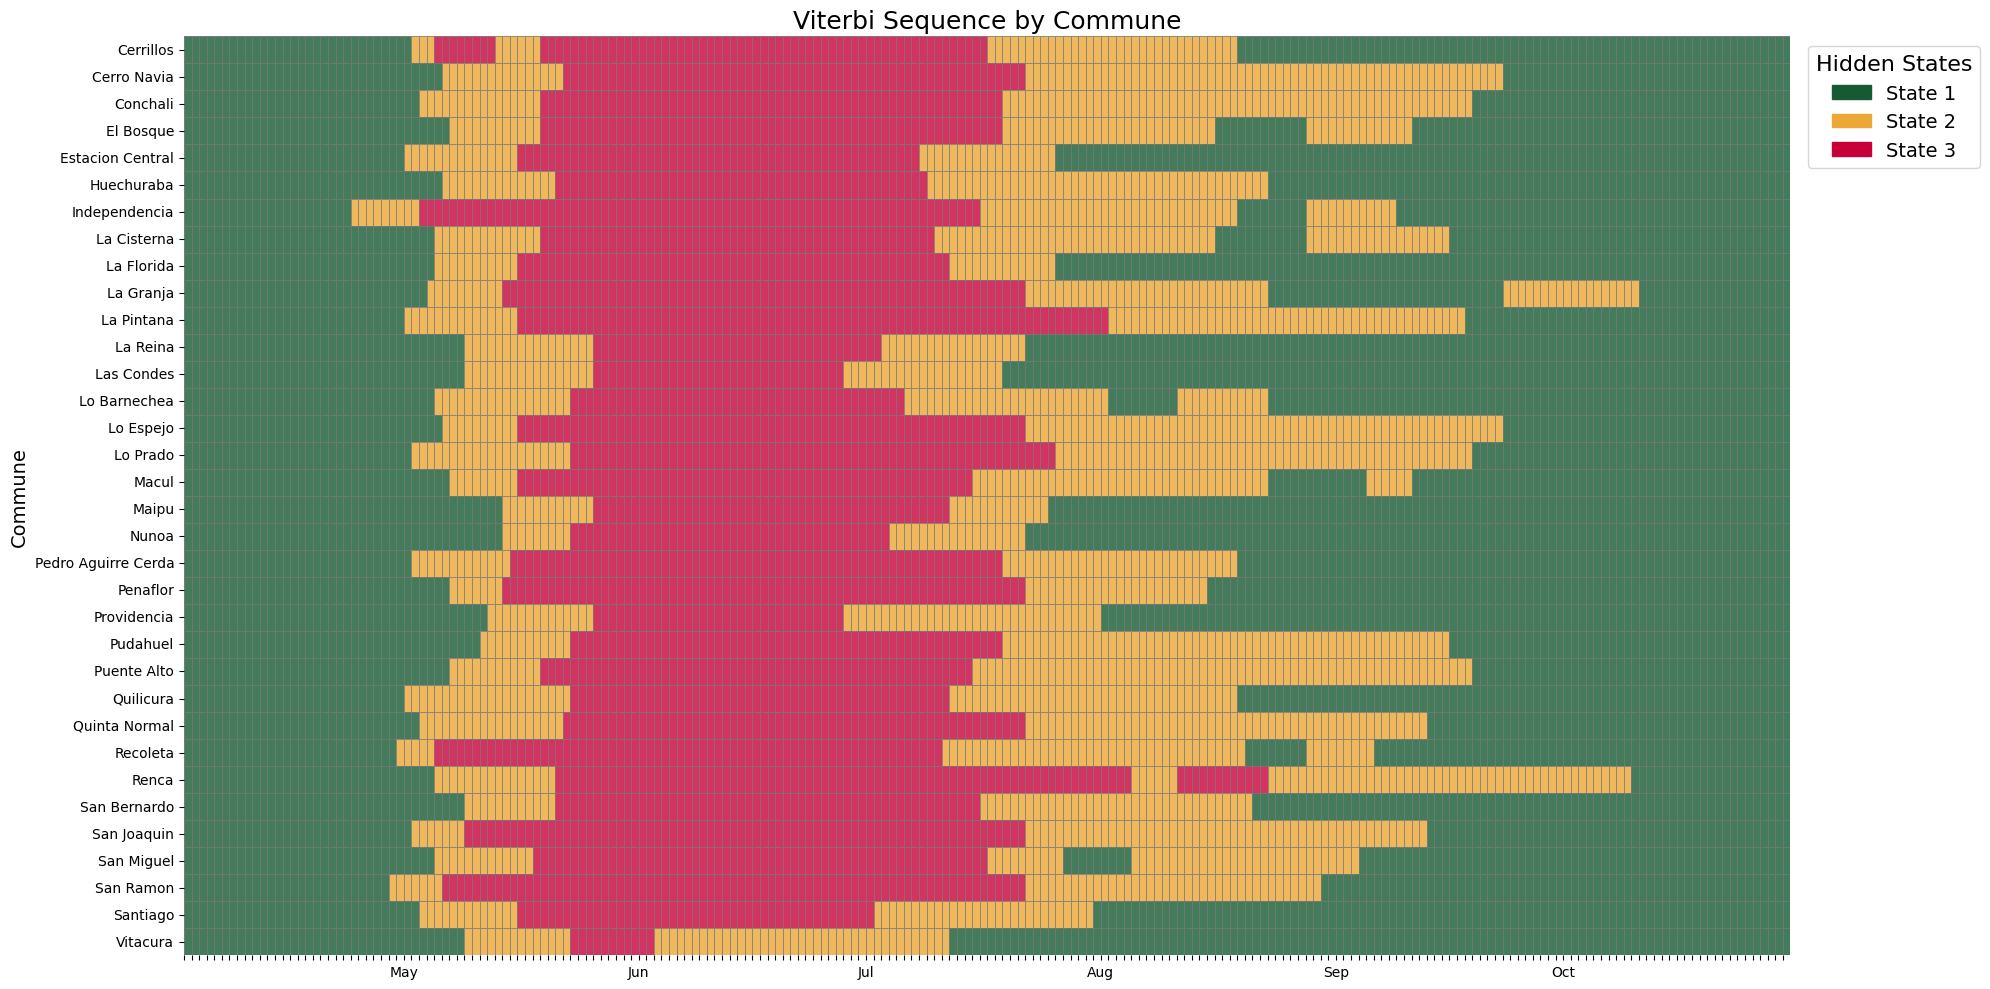

In [39]:
# Create the heatmap by pivoting the data
viterbi_pivot = viterbi_merged.pivot(index='Commune', columns='Days', values='Reordened_state')

# Define the minimum and maximum date range
min_date = pd.Timestamp('2020-03-31')
max_date = pd.Timestamp('2020-10-30')

# Filter columns to include only dates within the range
filtered_columns = [col for col in viterbi_pivot.columns if min_date <= col <= max_date]

# Pivot the data for 'Reordened_state'
viterbi_pivot = viterbi_merged.pivot(index='Commune', columns='Days', values='Reordened_state')
viterbi_pivot = viterbi_pivot[filtered_columns]  # Filter the pivot table for the desired date range

# Define custom colors for each state
custom_colors = ['#145A32', '#eda735', '#C70039'] 
custom_palette = dict(zip([1, 2, 3], custom_colors))  # Mapping for the states

fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.heatmap(
    viterbi_pivot,  # Use the filtered pivot table
    cmap=sns.color_palette(custom_colors, as_cmap=True),  # Custom color palette
    linewidths=0.5,
    linecolor='gray',
    alpha=0.8,  # Adjust transparency
    cbar=False  # Deactivate the color bar
)

# Adjust x-axis labels with mapped month names
month_mapping = {
    "ene": "Jan", "feb": "Feb", "mar": "Mar", "abr": "Apr",
    "may": "May", "jun": "Jun", "jul": "Jul", "ago": "Aug",
    "sept": "Sep", "oct": "Oct", "nov": "Nov", "dic": "Dec"
}

ax.set_xlabel(None)  # Remove redundant x-axis label
ax.set_ylabel("Commune", fontsize=14)
ax.set_xticks(range(len(filtered_columns)))
ax.set_xticklabels(
    [month_mapping[date.strftime('%b').strip('.')] if date.day == 1 else '' for date in filtered_columns],
    rotation=0, fontsize=10
)

# Create a custom legend for the states
import matplotlib.patches as mpatches
legend_labels = ['State 1', 'State 2', 'State 3']  # State labels
legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(custom_colors, legend_labels)]

plt.legend(
    handles=legend_handles, 
    title="Hidden States", 
    bbox_to_anchor=(1.005, 1), 
    loc='upper left', 
    fontsize=14, 
    title_fontsize=16
)

# Add descriptive title
plt.title('Viterbi Sequence by Commune', fontsize=18)

# Adjust layout to avoid unnecessary margins
plt.tight_layout()

# Display the plot
plt.show()


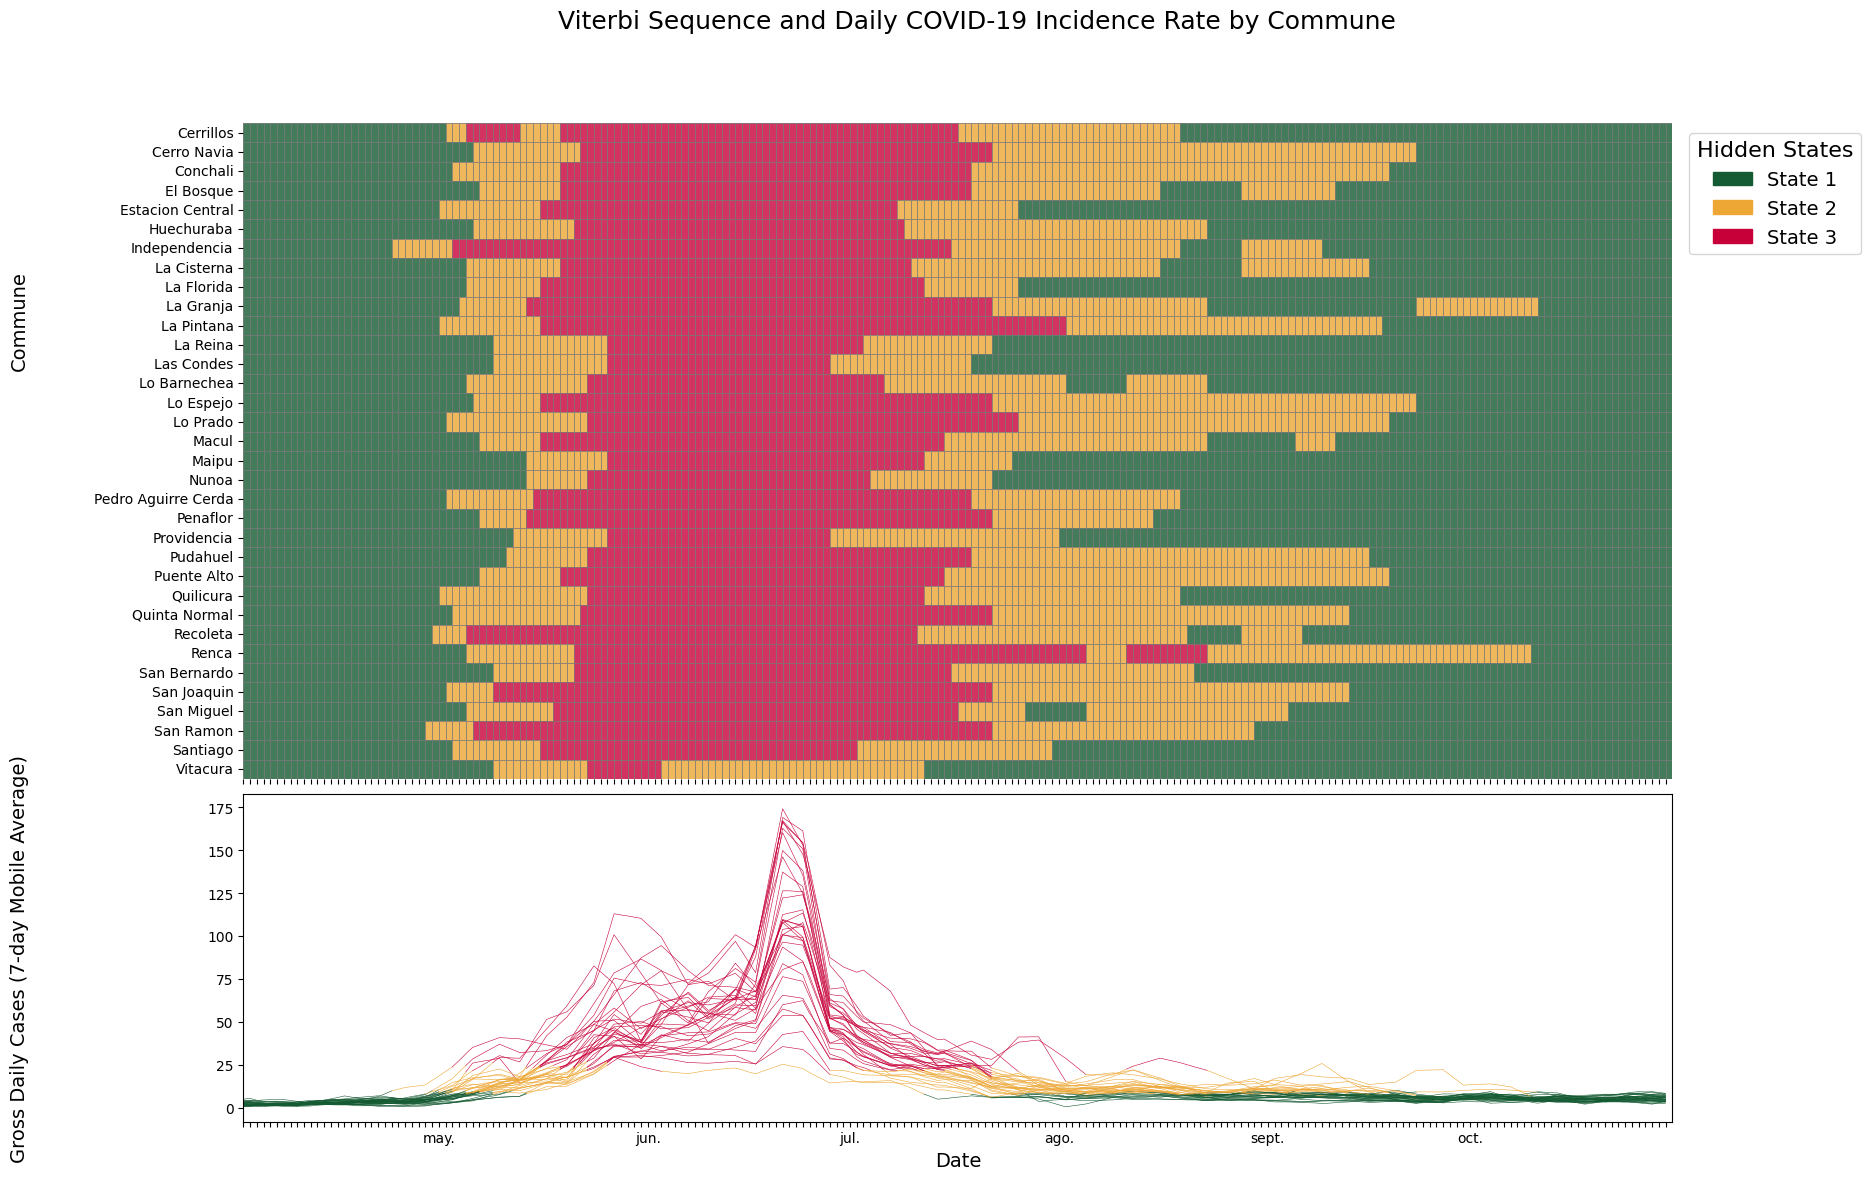

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import os

# Se asume que el DataFrame "viterbi_merged" ya está cargado.

# --- Preparación de los datos ---

# Pivot para el heatmap: filas = Commune, columnas = Days, valores = Reordened_state.
viterbi_pivot = viterbi_merged.pivot(index='Commune', columns='Days', values='Reordened_state')

# Pivot para la serie de casos diarios usando Gross_Daily_Cases_Mobile_Average_7_Days:
# Índice = Days y columnas = Commune.
daily_cases_pivot = viterbi_merged.pivot(index='Days', columns='Commune', 
                                         values='Gross_Daily_Cases_Mobile_Average_7_Days')

# Definir rango de fechas
min_date = pd.Timestamp('2020-03-31')
max_date = pd.Timestamp('2020-10-30')

# Filtrar las columnas (fechas) del heatmap que están dentro del rango
filtered_columns = sorted([col for col in viterbi_pivot.columns if min_date <= col <= max_date])
viterbi_pivot = viterbi_pivot[filtered_columns]

# Filtrar la serie de casos diarios al mismo rango y reindexarla para garantizar el mismo orden de fechas
daily_cases_pivot = daily_cases_pivot.loc[min_date:max_date].reindex(filtered_columns)

# --- Configuración de colores ---
custom_colors = ['#145A32', '#eda735', '#C70039']  # Para State 1, 2, 3
#'#145A32'
#'#C70039'
#'#eda735'
#'#2166AC'
#'#B2182B'
#'grey90'

# --- Configuración de los xticks (igual que en el código original) ---
tick_positions = list(range(len(filtered_columns)))
tick_labels = [date.strftime('%b') if date.day == 1 else '' for date in filtered_columns]

# --- Crear la figura y los subplots ---
# sharex=True para que ambos subplots compartan el mismo eje X y se alineen temporalmente.
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20, 12), sharex=True,
                               gridspec_kw={'height_ratios': [2, 1]})

# ===============================
# Subplot superior: Heatmap de Viterbi
# ===============================
sns.heatmap(
    viterbi_pivot,
    cmap=sns.color_palette(custom_colors, as_cmap=True),
    linewidths=0.4,
    linecolor='gray',
    alpha=0.8,
    cbar=False,
    ax=ax1
)
ax1.set_ylabel("Commune", fontsize=14)
ax1.yaxis.set_label_coords(-0.15, 0.7)
ax1.set_xlabel("")
ax1.set_xticks(tick_positions)
ax1.set_xticklabels(tick_labels, rotation=0, fontsize=10)

# Agregar leyenda personalizada en el subplot superior
legend_labels = ['State 1', 'State 2', 'State 3']
legend_handles = [mpatches.Patch(color=color, label=label) 
                  for color, label in zip(custom_colors, legend_labels)]
ax1.legend(
    handles=legend_handles,
    title="Hidden States",
    bbox_to_anchor=(1.005, 1),
    loc='upper left',
    fontsize=14,
    title_fontsize=16
)

# ===============================
# Subplot inferior: Serie de casos diarios segmentada por hidden state
# ===============================
# Para cada comuna se segmenta la serie. Al detectar un cambio de estado,
# se incluye el punto de transición en ambos segmentos para lograr continuidad.
for commune in daily_cases_pivot.columns:
    x = list(range(len(filtered_columns)))  # Eje X: posiciones 0, 1, 2, ...
    y = daily_cases_pivot[commune].values
    states = viterbi_pivot.loc[commune, filtered_columns].values  # Estados correspondientes
    
    start_idx = 0
    current_state = states[0]
    for i in range(1, len(states)):
        # Al detectar un cambio de estado, incluimos el punto de transición en el segmento actual:
        if states[i] != current_state:
            ax2.plot(x[start_idx:i+1], y[start_idx:i+1],
                     color=custom_colors[int(current_state)-1], lw=0.4)
            start_idx = i
            current_state = states[i]
    # Graficar el último segmento
    ax2.plot(x[start_idx:], y[start_idx:], color=custom_colors[int(current_state)-1], lw=0.4)

# Ajuste del label del eje Y del subplot inferior para desplazarlo más a la izquierda
ax2.set_ylabel("Gross Daily Cases (7-day Mobile Average)", fontsize=14, labelpad=30)
ax2.yaxis.set_label_coords(-0.15, 0.5)

ax2.set_xlabel("Date", fontsize=14)
ax2.set_xticks(tick_positions)
ax2.set_xticklabels(tick_labels, rotation=0, fontsize=10)

# Eliminar leyendas en el subplot inferior, en caso de existir.
if ax2.get_legend() is not None:
    ax2.legend().remove()

# Título general del gráfico
plt.suptitle('Viterbi Sequence and Daily COVID-19 Incidence Rate by Commune', fontsize=18)

plt.tight_layout(rect=[0, 0, 0.95, 0.93])

# Crear directorio si no existe
output_dir = "../results/figures/"
os.makedirs(output_dir, exist_ok=True)

# Guardar la figura con dpi 700
plt.savefig(os.path.join(output_dir, "viterbi_daily_cases.png"), dpi=700)
plt.show()


# Characterization of Hidden States:

In [41]:
viterbi_merged.columns

Index(['state', 'S1', 'S2', 'S3', 'row_id', 'Internal_Mobility_Index',
       'External_Mobility_Index', 'Per_Capita_Income', 'Cumulative_Cases_Rate',
       'Average_Household_Persons', 'Immigrants', 'Total_Households_Housed',
       'Housing_Precariousness_Index', 'Commune', 'Date', 'Days',
       'Higher_Education_Percentage', 'Postgraduade_Percentage',
       'Social_Priority_Index_2020', 'Priority_2020', 'Code', 'Year', 'Month',
       'Step', 'Step_Label', 'Quarantine_Start_Date', 'Quarantine_End_Date',
       'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days',
       'Employment_Conditions', 'Business_Climate', 'Socio-cultural_Factors',
       'Connectivity_and_Mobility', 'Health_and_Ecology',
       'Housing_and_Urban_Space', 'Urban_Quality_of_Life_Index_2019',
       'Range_ICVU', 'Poblation', 'Density_Pob_Km2', 'Total_Housing',
       'Numbers_Households', 'Porc_Overcrowding', 'Average_Persons_Households',
       'Porc_Higher_Education_Completed', 'Porc_Households

In [42]:
eda_data = viterbi_merged[['Reordened_state', 'Internal_Mobility_Index', 'External_Mobility_Index', 'Cumulative_Cases_Rate', 
                             'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days', 
                             'USD_Per_Capita_Income', 'Average_Household_Persons', 
                             'Immigrants', 'Total_Households_Housed',
                              'Housing_Precariousness_Index', 'Higher_Education_Percentage', 'Social_Priority_Index_2020',
                              'Employment_Conditions','Business_Climate','Connectivity_and_Mobility','Housing_and_Urban_Space',
                              'Health_and_Ecology','Socio-cultural_Factors','Urban_Quality_of_Life_Index_2019',
                              'Poblation', 'Density_Pob_Km2', 'Total_Housing','Numbers_Households', 'Porc_Overcrowding', 
                              'Average_Persons_Households','Porc_Higher_Education_Completed', 'Porc_Households_with_Immigrants']]


In [43]:
# Variables que queremos graficar
variables = ['Internal_Mobility_Index', 'External_Mobility_Index', 'Cumulative_Cases_Rate', 
             'Gross_Daily_Cases_Mobile_Average_7_Days', 'USD_Per_Capita_Income', 'Average_Household_Persons', 
             'Immigrants', 'Total_Households_Housed','Housing_Precariousness_Index', 'Higher_Education_Percentage', 
             'Social_Priority_Index_2020','Employment_Conditions','Business_Climate','Connectivity_and_Mobility',
             'Housing_and_Urban_Space','Health_and_Ecology','Socio-cultural_Factors','Urban_Quality_of_Life_Index_2019',
             'Porc_Overcrowding','Average_Persons_Households','Porc_Higher_Education_Completed',
             'Porc_Households_with_Immigrants'
                             ]


C:\Users\ferna\AppData\Local\Temp\ipykernel_14792\2681077244.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1' '1' '1' ... '1' '1' '1']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  eda_data.loc[:, 'Reordened_state'] = eda_data['Reordened_state'].astype(str)


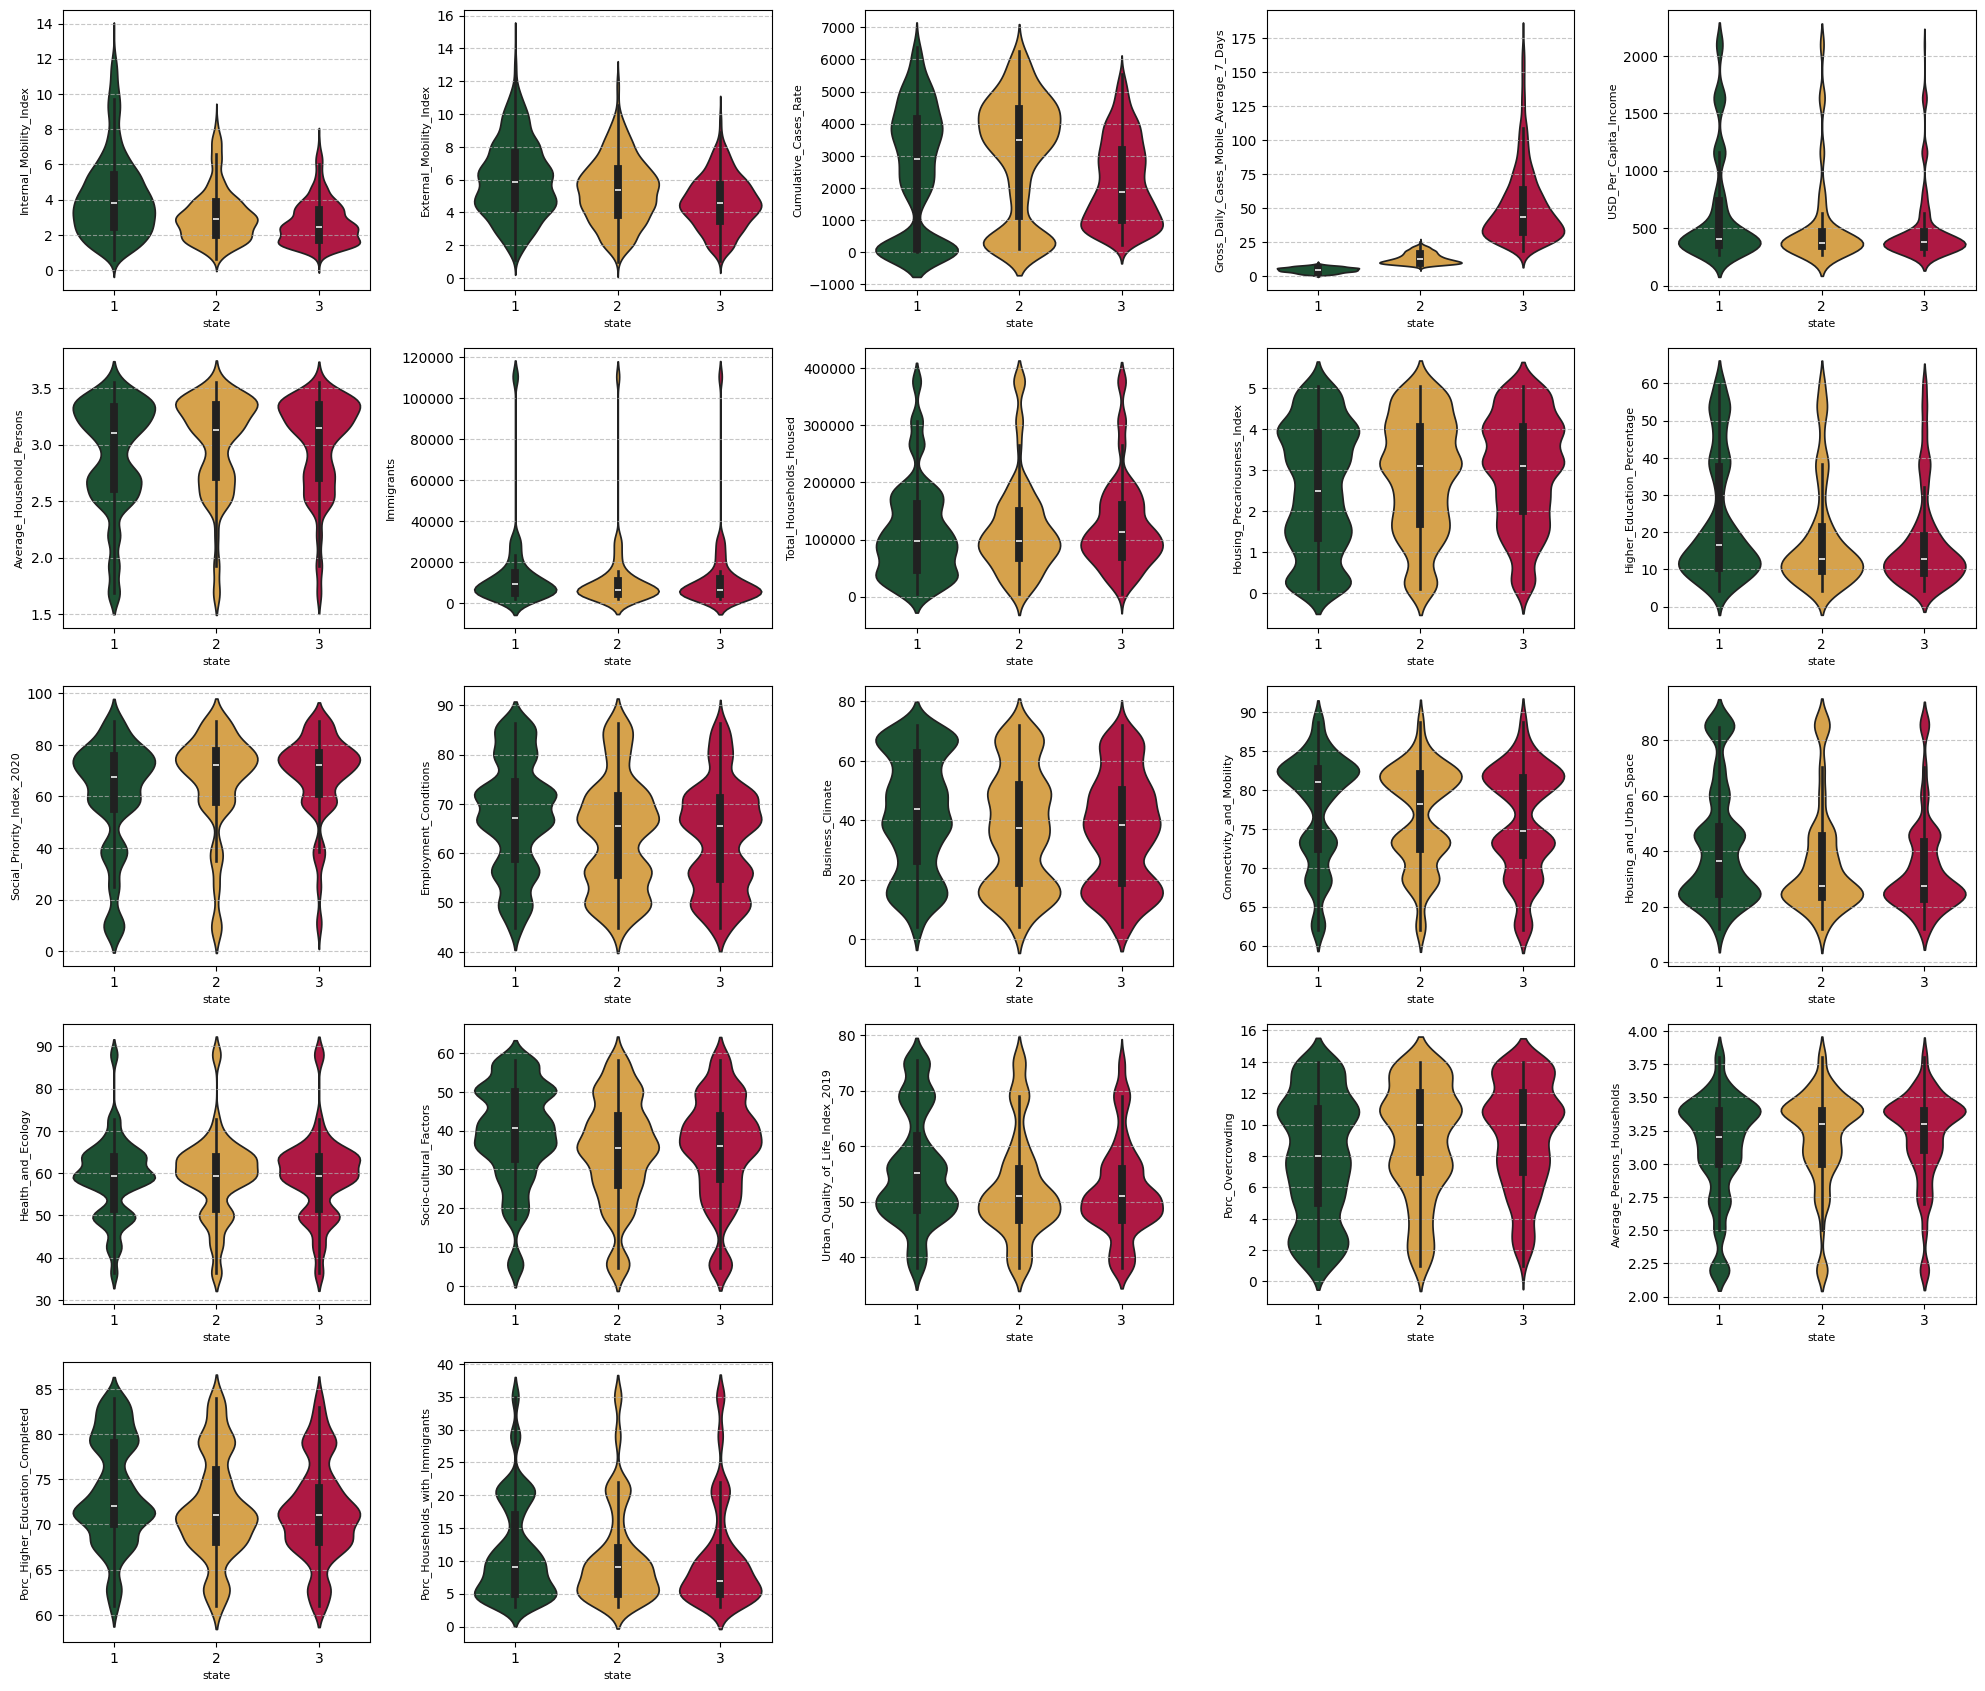

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import os

# Convertir la columna 'Reordened_state' a cadenas (string)
eda_data.loc[:, 'Reordened_state'] = eda_data['Reordened_state'].astype(str)

# Nueva paleta de colores basada en el heatmap de Viterbi
custom_palette = {
    '1': '#145A32',  # Estado 1 - leve (verde agua)
    '2': '#eda735',  # Estado 2 - moderado (azul)
    '3': '#C70039'   # Estado 3 - severo (rojo)
}

# Configuración de la figura: 1 fila y 4 columnas de subplots, tamaño total 20x5 pulgadas
n_rows = 6  # Número de filas
n_cols = 5 # Número de columnas
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
axes = axes.ravel()  # Aplanar el array de ejes para iterar más fácilmente

# Crear los violinplots para cada variable
# (se asume que "variables" es una lista de nombres de columnas en eda_data a graficar)
for i, var in enumerate(variables):
    sns.violinplot(
        data=eda_data, 
        x='Reordened_state', 
        y=var, 
        hue='Reordened_state', 
        palette=custom_palette, 
        ax=axes[i], 
        dodge=False
    )
    axes[i].set_xlabel('state', fontsize=8)
    axes[i].set_ylabel(var, fontsize=8)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    # Si se desea eliminar la leyenda individual, descomentar la siguiente línea:
    # axes[i].legend_.remove()

# Eliminar cualquier subplot sobrante si hay más ejes que variables
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

# Ajustar el espacio entre subplots
plt.tight_layout()

# Crear directorio de salida si no existe
output_dir = "../results/figures/"
os.makedirs(output_dir, exist_ok=True)

# Guardar la figura con dpi 700
plt.savefig(os.path.join(output_dir, "violinplots_all_variables.png"), dpi=700)

plt.show()



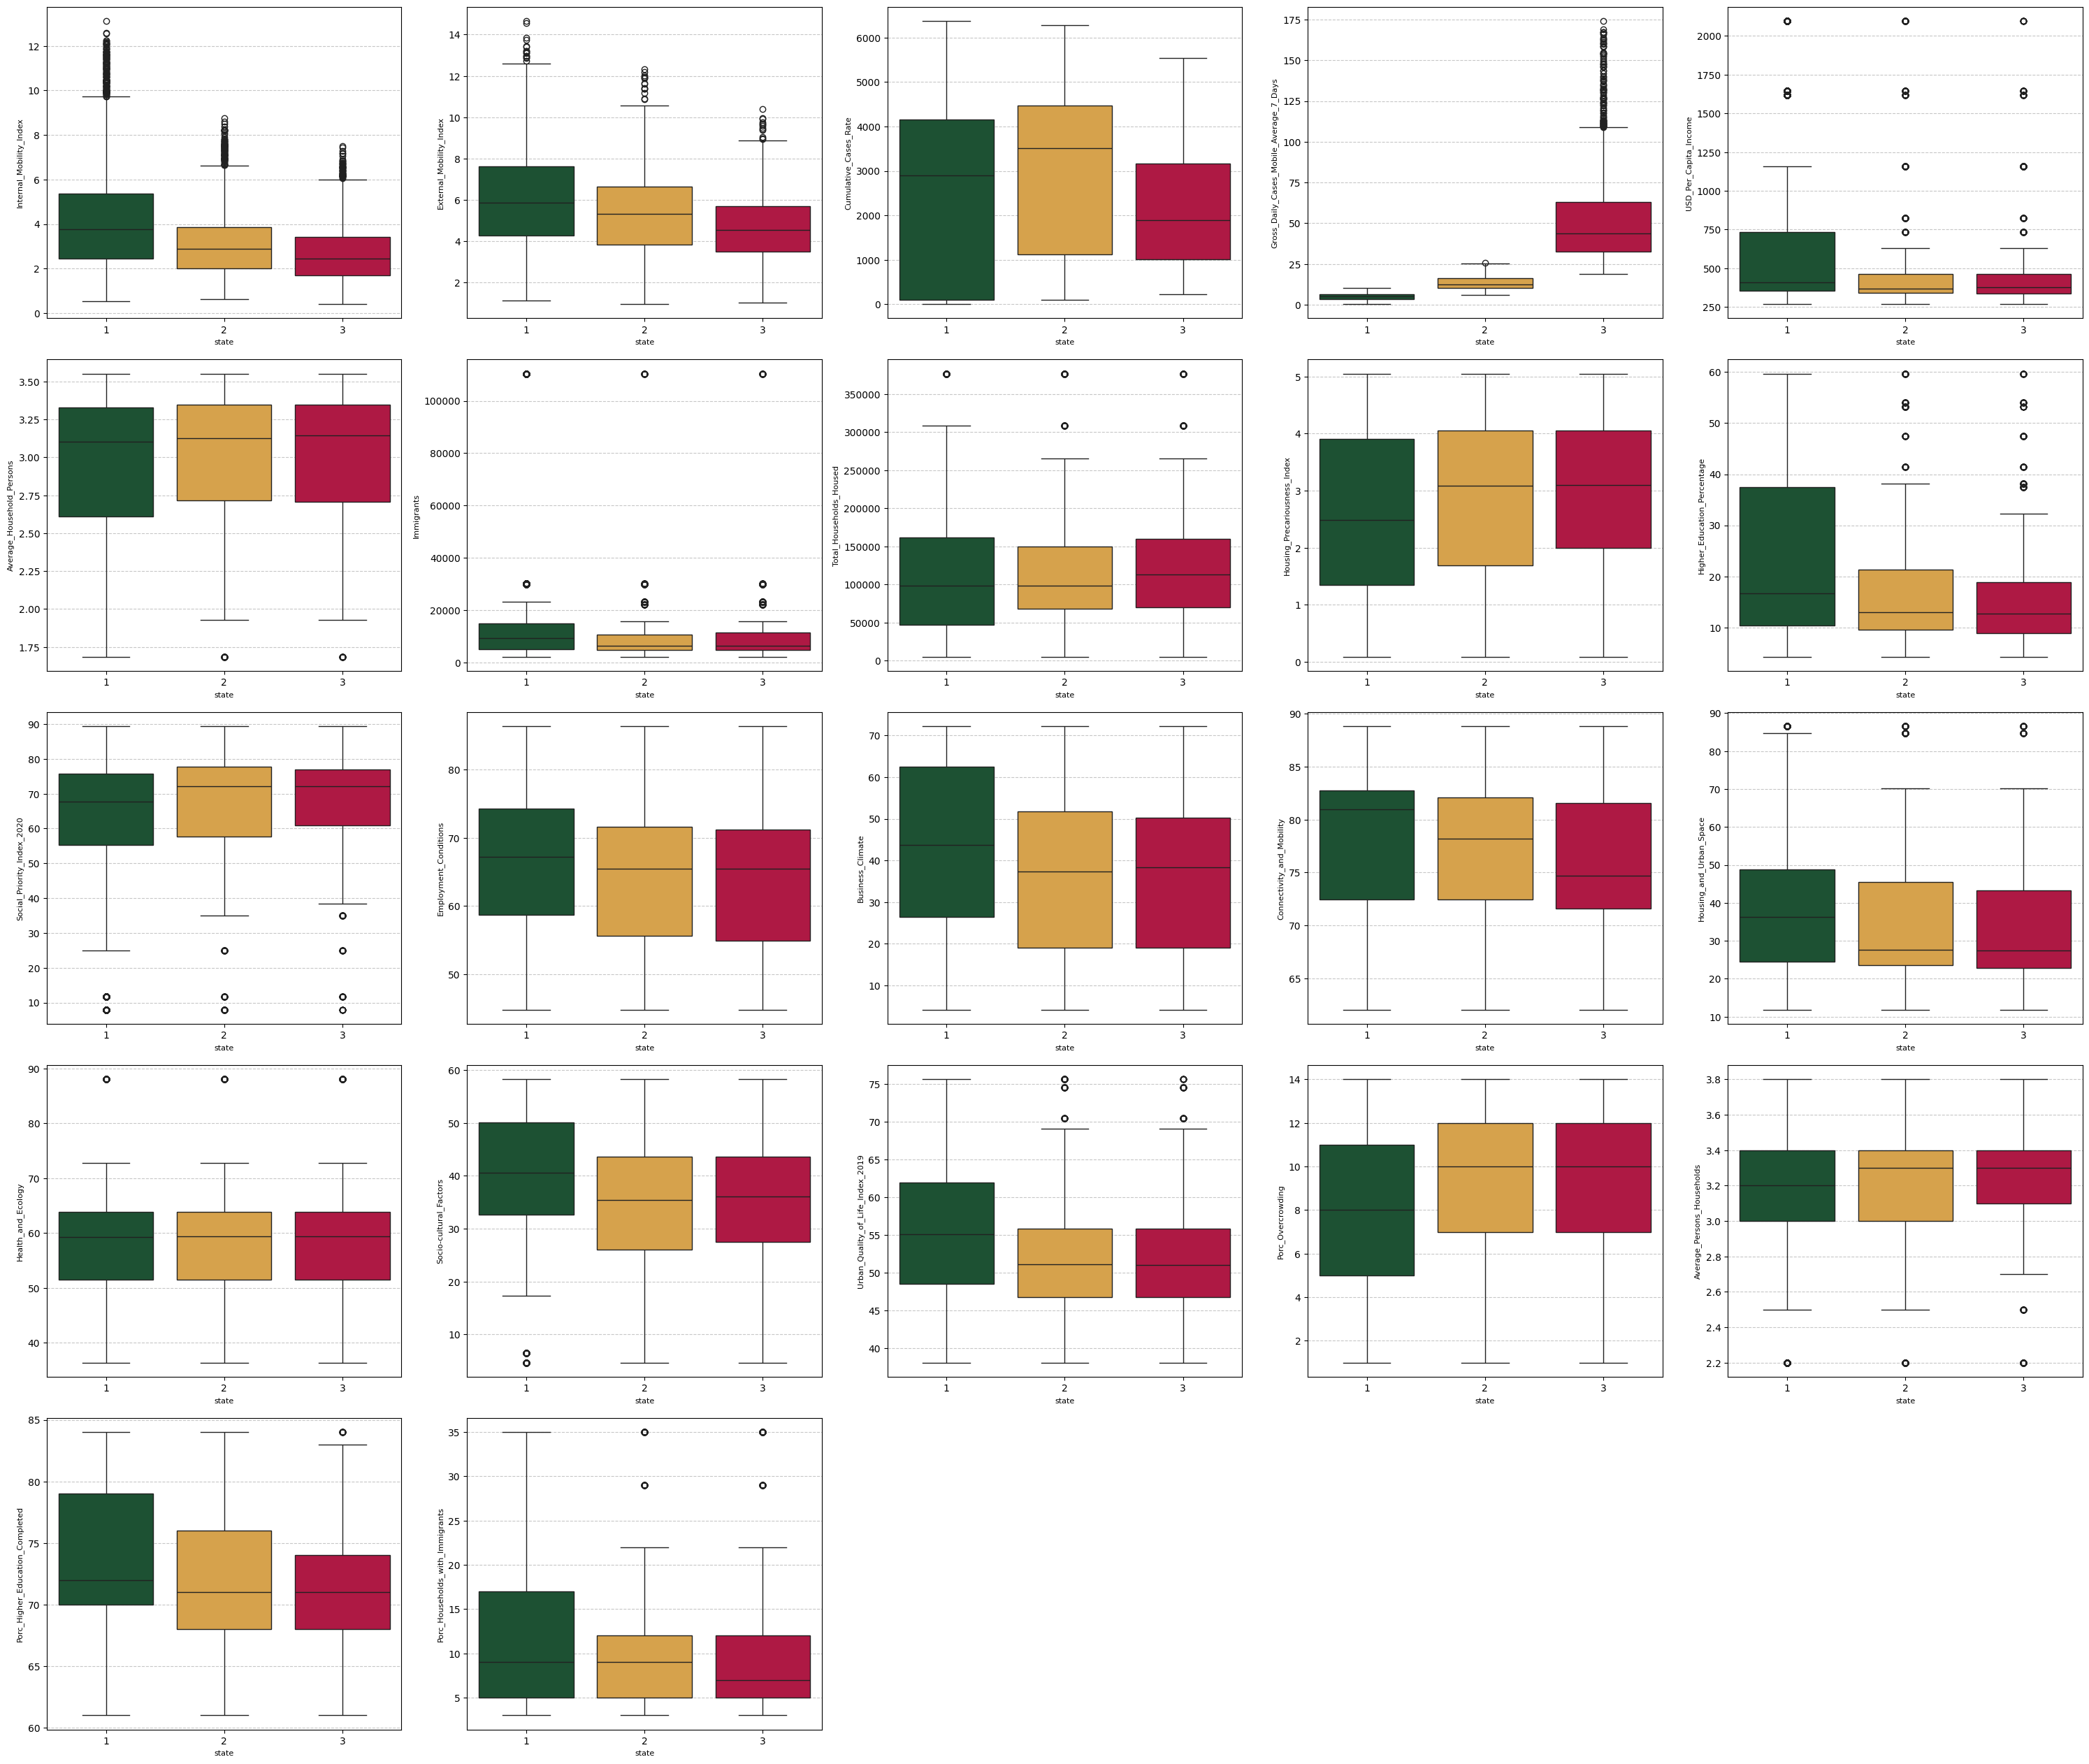

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import os

# Convertir la columna 'Reordened_state' a cadenas (string)
eda_data.loc[:, 'Reordened_state'] = eda_data['Reordened_state'].astype(str)

# Nueva paleta de colores basada en el heatmap de Viterbi
custom_palette = {
    '1': '#145A32',  # Estado 1 - leve (verde agua)
    '2': '#eda735',  # Estado 2 - moderado (azul)
    '3': '#C70039'   # Estado 3 - severo (rojo)
}

# Configuración de la figura: múltiples subplots
n_rows = 6  # Número de filas
n_cols = 5  # Número de columnas
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 30))
axes = axes.ravel()  # Aplanar el array de ejes para iterar más fácilmente

# Crear los boxplots para cada variable
for i, var in enumerate(variables):
    sns.boxplot(
        data=eda_data, 
        x='Reordened_state', 
        y=var, 
        hue='Reordened_state', 
        palette=custom_palette, 
        ax=axes[i], 
        dodge=False,  # Evita que las cajas se separen demasiado por el hue
        showcaps=True,  # Mostrar extremos de la caja
        showfliers=True  # Mostrar valores atípicos
    )
    axes[i].set_xlabel('state', fontsize=8)
    axes[i].set_ylabel(var, fontsize=8)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    # Si se desea eliminar la leyenda individual, descomentar la siguiente línea:
    # axes[i].legend_.remove()

# Eliminar cualquier subplot sobrante si hay más ejes que variables
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

# Ajustar el espacio entre subplots
plt.tight_layout()

# Crear directorio de salida si no existe
output_dir = "../results/figures/"
os.makedirs(output_dir, exist_ok=True)

# Guardar la figura con dpi 700
plt.savefig(os.path.join(output_dir, "boxplots_all_variables.png"), dpi=700)

plt.show()


In [46]:
# Variables que queremos graficar
variables_1 = ['Internal_Mobility_Index', 'External_Mobility_Index',  
             'Gross_Daily_Cases_Mobile_Average_7_Days'
                             ]

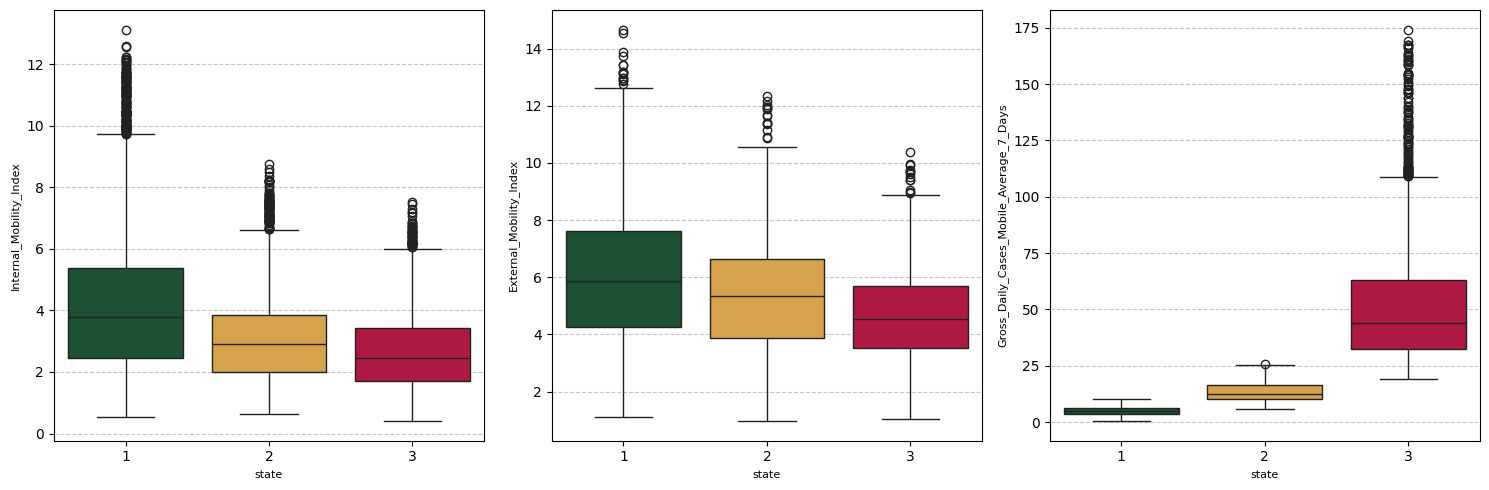

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import os

# Convertir la columna 'Reordened_state' a cadenas (string)
eda_data.loc[:, 'Reordened_state'] = eda_data['Reordened_state'].astype(str)

# Nueva paleta de colores basada en el heatmap de Viterbi
custom_palette = {
    '1': '#145A32',  # Estado 1 - leve (verde agua)
    '2': '#eda735',  # Estado 2 - moderado (azul)
    '3': '#C70039'   # Estado 3 - severo (rojo)
}

# Configuración de la figura: múltiples subplots
n_rows = 1  # Número de filas
n_cols = 3  # Número de columnas
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5))
axes = axes.ravel()  # Aplanar el array de ejes para iterar más fácilmente

# Crear los boxplots para cada variable
for i, var in enumerate(variables_1):
    sns.boxplot(
        data=eda_data, 
        x='Reordened_state', 
        y=var, 
        hue='Reordened_state', 
        palette=custom_palette, 
        ax=axes[i], 
        dodge=False,  # Evita que las cajas se separen demasiado por el hue
        showcaps=True,  # Mostrar extremos de la caja
        showfliers=True  # Mostrar valores atípicos
    )
    axes[i].set_xlabel('state', fontsize=8)
    axes[i].set_ylabel(var, fontsize=8)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    # Si se desea eliminar la leyenda individual, descomentar la siguiente línea:
    # axes[i].legend_.remove()

# Eliminar cualquier subplot sobrante si hay más ejes que variables
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

# Ajustar el espacio entre subplots
plt.tight_layout()

# Crear directorio de salida si no existe
output_dir = "../results/figures/"
os.makedirs(output_dir, exist_ok=True)

# Guardar la figura con dpi 700
plt.savefig(os.path.join(output_dir, "boxplots_mobility_indexes_daily_cases.png"), dpi=700)

plt.show()

#### Number of days per state for each commune

In [48]:
state_count = viterbi_merged.groupby(['Commune', 'Reordened_state']).size().reset_index(name='Days')

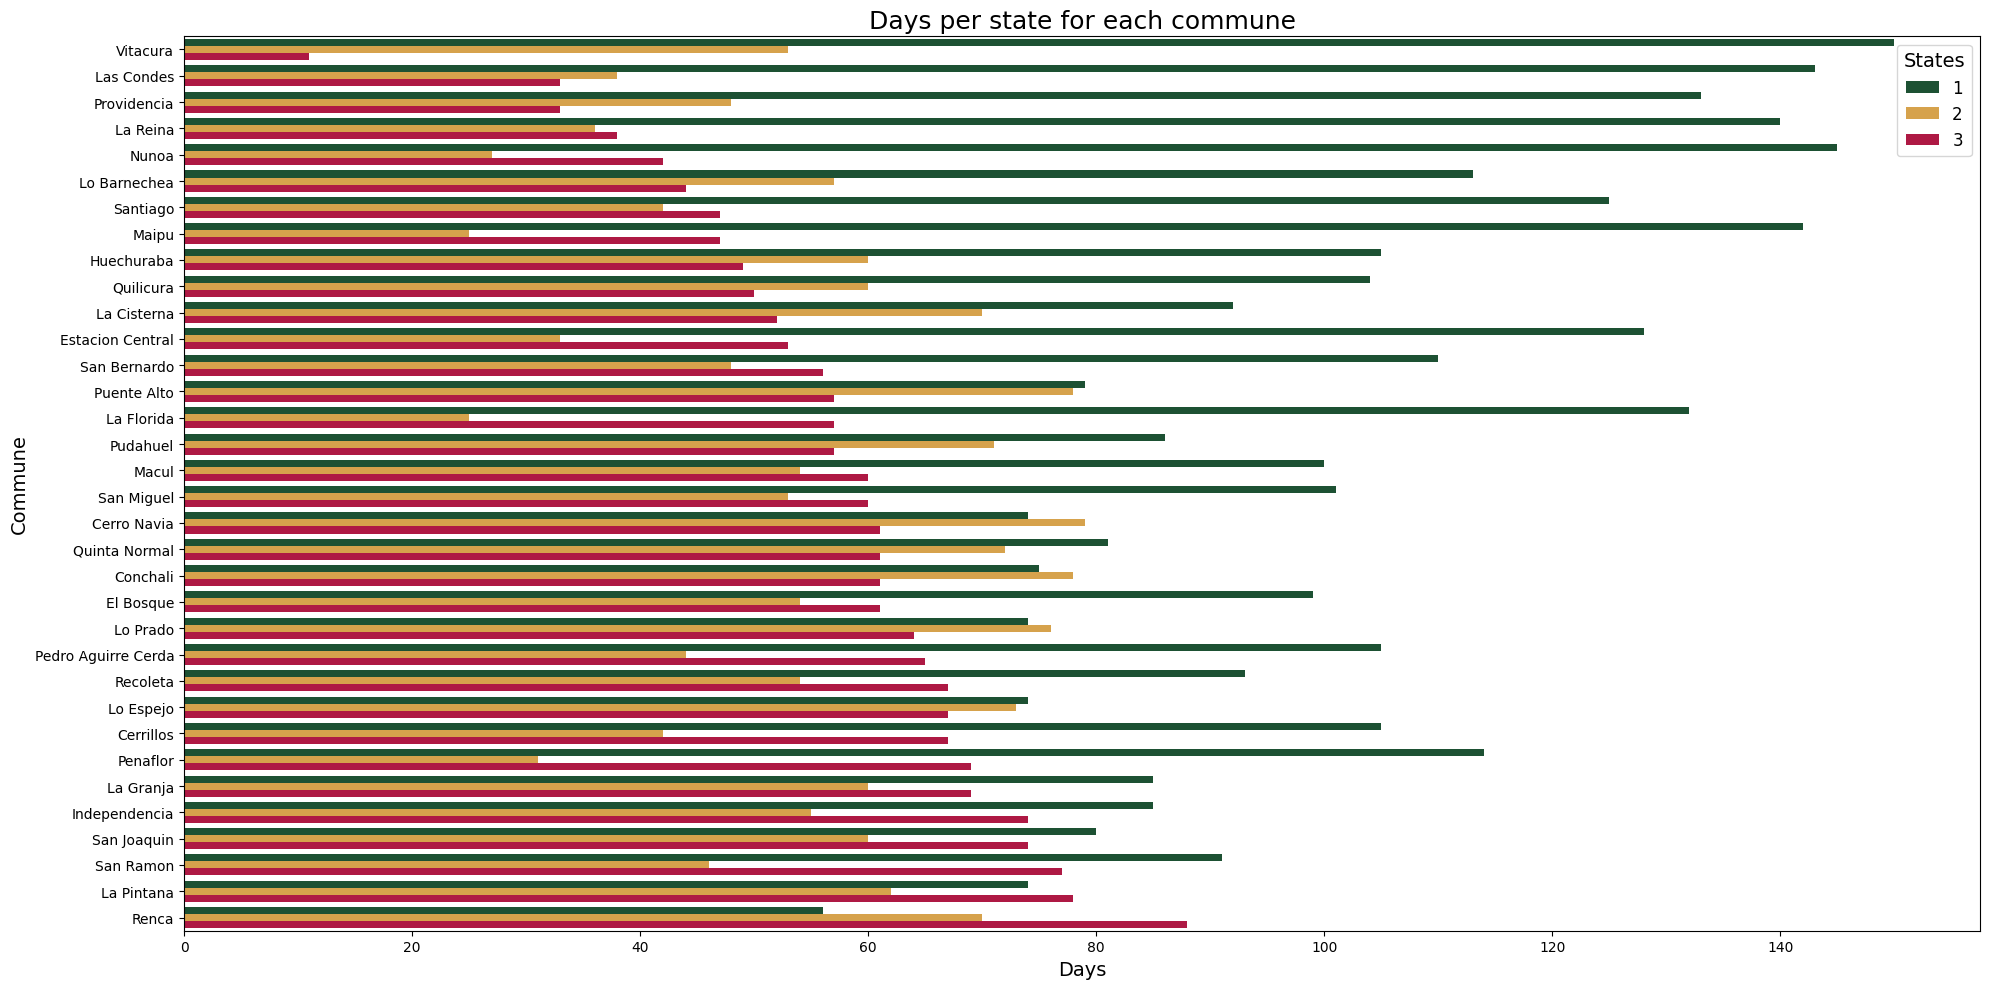

In [49]:
# Aggregate the data to count the total "Days" for state 3 (Reordened_state == 3) per commune
state_3_counts = state_count[state_count['Reordened_state'] == 3].groupby('Commune')['Days'].sum().sort_values()

# Use the sorted order of communes in the state_count DataFrame
sorted_communes = state_3_counts.index

# Sort the original data frame by this order
state_count_sorted = state_count.copy()
state_count_sorted['Commune'] = pd.Categorical(state_count_sorted['Commune'], categories=sorted_communes, ordered=True)
state_count_sorted = state_count_sorted.sort_values('Commune')

# Create the barplot:
plt.figure(figsize=(20, 10))
custom_palette = {
    '1': '#145A32',  # Estado 1 - leve (verde agua)
    '2': '#eda735',  # Estado 2 - moderado (azul)
    '3': '#C70039'   # Estado 3 - severo (rojo)
}
custom_colors = ['#145A32', '#eda735', '#C70039']  # Light gray, medium gray, and dark gray


sns.barplot(
    data=state_count_sorted, 
    x='Days', 
    y='Commune', 
    orient='h', 
    hue='Reordened_state', 
    palette=custom_colors, 
    dodge=True
)

# Add title, labels, and legend
plt.title('Days per state for each commune', fontsize=18)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Commune', fontsize=14)
plt.xticks()
plt.legend(title='States', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()


In [50]:
eda_data.columns

Index(['Reordened_state', 'Internal_Mobility_Index', 'External_Mobility_Index',
       'Cumulative_Cases_Rate', 'Gross_Daily_Cases',
       'Gross_Daily_Cases_Mobile_Average_7_Days', 'USD_Per_Capita_Income',
       'Average_Household_Persons', 'Immigrants', 'Total_Households_Housed',
       'Housing_Precariousness_Index', 'Higher_Education_Percentage',
       'Social_Priority_Index_2020', 'Employment_Conditions',
       'Business_Climate', 'Connectivity_and_Mobility',
       'Housing_and_Urban_Space', 'Health_and_Ecology',
       'Socio-cultural_Factors', 'Urban_Quality_of_Life_Index_2019',
       'Poblation', 'Density_Pob_Km2', 'Total_Housing', 'Numbers_Households',
       'Porc_Overcrowding', 'Average_Persons_Households',
       'Porc_Higher_Education_Completed', 'Porc_Households_with_Immigrants'],
      dtype='object')

## Lineal Regression of Days per State vs Sociodemographic Variable:


In [51]:
# Preparación de los datos
days_by_state = (
    viterbi_merged
    .groupby(['Commune', 'Reordened_state'])['Date']
    .count()
    .reset_index(name='Days_in_State')
    .pivot(index='Commune', columns='Reordened_state', values='Days_in_State')
    .rename(columns={1: 'Days_State_1', 2: 'Days_State_2', 3: 'Days_State_3'})
    .fillna(0)
)
socio_vars = viterbi_merged.groupby('Commune')[[
    'Internal_Mobility_Index', 
    'External_Mobility_Index', 
    'Cumulative_Cases_Rate', 
    'Gross_Daily_Cases', 
    'Gross_Daily_Cases_Mobile_Average_7_Days', 
    'Per_Capita_Income', 
    'USD_Per_Capita_Income',
    'Density_Pob_Km2', 
    'Total_Housing', 
    'Numbers_Households',
    'Porc_Overcrowding', 
    'Housing_Precariousness_Index',
    'Social_Priority_Index_2020', 
    'Poblation', 
    'Average_Persons_Households',
    'Porc_Higher_Education_Completed', 
    'Porc_Households_with_Immigrants',
    'Employment_Conditions',
    'Business_Climate',
    'Connectivity_and_Mobility',
    'Housing_and_Urban_Space',
    'Health_and_Ecology',
    'Socio-cultural_Factors',
    'Urban_Quality_of_Life_Index_2019'
]].mean()
df = days_by_state.join(socio_vars).reset_index()


In [52]:
#r('''install.packages(c("ggplot2", "cowplot", "scales", "gridExtra"))''')


In [53]:
#r('''install.packages("ggrepel")''')

In [54]:
df.columns

Index(['Commune', 'Days_State_1', 'Days_State_2', 'Days_State_3',
       'Internal_Mobility_Index', 'External_Mobility_Index',
       'Cumulative_Cases_Rate', 'Gross_Daily_Cases',
       'Gross_Daily_Cases_Mobile_Average_7_Days', 'Per_Capita_Income',
       'USD_Per_Capita_Income', 'Density_Pob_Km2', 'Total_Housing',
       'Numbers_Households', 'Porc_Overcrowding',
       'Housing_Precariousness_Index', 'Social_Priority_Index_2020',
       'Poblation', 'Average_Persons_Households',
       'Porc_Higher_Education_Completed', 'Porc_Households_with_Immigrants',
       'Employment_Conditions', 'Business_Climate',
       'Connectivity_and_Mobility', 'Housing_and_Urban_Space',
       'Health_and_Ecology', 'Socio-cultural_Factors',
       'Urban_Quality_of_Life_Index_2019'],
      dtype='object')

In [55]:
# --- PYTHON: Preparar datos y pasar a R ---
import pandas as pd
from rpy2.robjects import pandas2ri, r

# Activar conversión
pandas2ri.activate()

# Enviar df a R
r_df = pandas2ri.py2rpy(df)
r.assign("df", r_df)

# Ruta de salida
r('output_dir <- "../results/figures/"')

#### Days in the State - Social Priority Index - Housing Precariousness - USD Per Capita Income

In [56]:
r('''
library(ggplot2)
library(dplyr)
library(cowplot)
library(scales)
library(ggpubr)
library(ggrepel)

# Colores por estado
state_fill_scales <- list(
  "1" = scale_fill_gradient(low = "#D5F5E3", high = "#145A32", name = "Housing Precariousness Index"),
  "2" = scale_fill_gradient(low = "#FDEBD0", high = "#EDA735", name = "Housing Precariousness Index"),
  "3" = scale_fill_gradient(low = "#FADBD8", high = "#C70039", name = "Housing Precariousness Index")
)
state_colors <- c("1" = "#145A32", "2" = "#EDA735", "3" = "#C70039")

# Función para graficar cada estado
make_plot <- function(state_var, title_text, eq_x, eq_y, state_index, show_legend = FALSE, hide_y = FALSE, hide_x = FALSE) {
  df %>% rename(Y = !!state_var) -> df_temp
  model <- lm(Y ~ Social_Priority_Index_2020, data = df_temp)
  coef <- coef(model)
  eq <- paste0("y = ", round(coef[2], 2), "x + ", round(coef[1], 2))
  r2 <- paste0("R² = ", round(summary(model)$r.squared, 2))
  y_max <- max(df_temp$Y, na.rm = TRUE)

  base_theme <- theme_bw() +
    theme(
      plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
      axis.title = element_text(size = 11),
      axis.text = element_text(size = 10),
      legend.position = ifelse(show_legend, "bottom", "none"),
      plot.margin = margin(12, 18, 12, 18)
    )

  if (hide_y) {
    base_theme <- base_theme + theme(axis.title.y = element_blank(), axis.text.y = element_blank(), axis.ticks.y = element_blank())
  }
  if (hide_x) {
    base_theme <- base_theme + theme(axis.title.x = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank())
  }

  ggplot(df_temp, aes(x = Social_Priority_Index_2020, y = Y)) +
    geom_point(aes(size = USD_Per_Capita_Income, fill = Housing_Precariousness_Index),
               shape = 21, color = "black", alpha = 0.8) +
    geom_smooth(method = "lm",
                color = state_colors[as.character(state_index)],
                fill = state_colors[as.character(state_index)],
                se = TRUE, alpha = 0.08) +
    ggrepel::geom_text_repel(aes(label = Commune), size = 3.4, max.overlaps = 100,
                             box.padding = 0.5, point.padding = 0.3, segment.color = NA) +
    annotate("text", x = eq_x, y = y_max * eq_y, label = eq, hjust = 0, size = 5.2) +
    annotate("text", x = eq_x, y = y_max * (eq_y - 0.05), label = r2, hjust = 0, size = 5.2) +
    state_fill_scales[[as.character(state_index)]] +
    scale_size_continuous(name = "Per Capita Income (USD)",
                          range = c(4, 14),
                          breaks = c(400, 800, 1200),
                          labels = scales::label_dollar(prefix = "$")) +
    labs(title = title_text,
         x = "Social Priority Index (2020)",
         y = "Days in the state") +
    base_theme
}

# Crear subplots
g1_leg <- make_plot("Days_State_1", "State 1 (moderate)", 20, 1.18, 1, show_legend = TRUE, hide_x = FALSE)
g2_leg <- make_plot("Days_State_2", "State 2 (severe)", 25, 1.00, 2, show_legend = TRUE, hide_y = TRUE, hide_x = FALSE)
g3_leg <- make_plot("Days_State_3", "State 3 (critical)", 30, 1.00, 3, show_legend = TRUE, hide_y = TRUE, hide_x =FALSE)

# Extraer leyendas
legend_fill_1 <- ggpubr::get_legend(g1_leg + guides(size = "none"))
legend_fill_2 <- ggpubr::get_legend(g2_leg + guides(size = "none"))
legend_fill_3 <- ggpubr::get_legend(g3_leg + guides(size = "none"))

# Leyenda tamaño: círculos vacíos
legend_size_plot <- ggplot(df, aes(x = 1, y = 1, size = USD_Per_Capita_Income)) +
  geom_point(shape = 1, color = "black") +
  scale_size_continuous(name = "Per Capita Income (USD)",
                        range = c(4, 14),
                        breaks = c(400, 800, 1200),
                        labels = label_dollar(prefix = "$")) +
  theme_void() +
  theme(legend.position = "bottom",
        legend.title = element_text(size = 10),
        legend.text = element_text(size = 9),
        legend.margin = margin(t = 5, b = 10))
legend_size <- ggpubr::get_legend(legend_size_plot)

# --- Quitar leyendas de los gráficos principales ---
g1 <- g1_leg +
  theme(legend.position = "none",
        axis.title.x = element_blank())
g2 <- g2_leg + theme(legend.position = "none")
g3 <- g3_leg +
  theme(legend.position = "none",
        axis.title.x = element_blank())

# Panel
panel_row <- plot_grid(g1, g2, g3, ncol = 3, align = "hv", rel_widths = c(1, 1, 1))
panel_row_labeled <- ggdraw() +
  draw_plot(panel_row, 0, 0, 1, 1) +
  draw_label("(A)", x = 0.02, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13) +
  draw_label("(B)", x = 0.35, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13) +
  draw_label("(C)", x = 0.68, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13)

# Leyendas
legends_row <- plot_grid(legend_fill_1, legend_fill_2, legend_fill_3, ncol = 3)
legend_size_centered <- plot_grid(NULL, legend_size, NULL, ncol = 3, rel_widths = c(1, 2, 1))

# Composición final
final_plot <- plot_grid(
  panel_row_labeled,
  legends_row,
  legend_size_centered,
  ncol = 1,
  rel_heights = c(1, 0.13, 0.12)
)

# Exportar y cerrar gráficos
ggsave(file.path(output_dir, "Social_Priority_Index_Housing_Precariousness_USD_Per_Capita_Income.pdf"), final_plot, dpi = 600, width = 21, height = 8.8)
ggsave(file.path(output_dir, "Social_Priority_Index_Housing_Precariousness_USD_Per_Capita_Income.png"), final_plot, dpi = 600, width = 21, height = 8.8)
dev.off()
invisible(NULL)
''')


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


#### Days in the State - Social Priority Index - Daily Cases - USD Per Capita Income

In [57]:
r('''
library(ggplot2)
library(dplyr)
library(cowplot)
library(scales)
library(ggpubr)
library(ggrepel)

# Paletas por estado para casos
state_fill_scales <- list(
  "1" = scale_fill_gradient(low = "#D5F5E3", high = "#145A32", name = "7-Day Avg. Daily Cases"),
  "2" = scale_fill_gradient(low = "#FDEBD0", high = "#EDA735", name = "7-Day Avg. Daily Cases"),
  "3" = scale_fill_gradient(low = "#FADBD8", high = "#C70039", name = "7-Day Avg. Daily Cases")
)
state_colors <- c("1" = "#145A32", "2" = "#EDA735", "3" = "#C70039")

# Función para graficar
make_plot <- function(state_var, title_text, eq_x, eq_y, state_index, show_legend = FALSE, hide_y = FALSE, hide_x = FALSE) {
  df %>% rename(Y = !!state_var) -> df_temp
  model <- lm(Y ~ Social_Priority_Index_2020, data = df_temp)
  coef <- coef(model)
  eq <- paste0("y = ", round(coef[2], 2), "x + ", round(coef[1], 2))
  r2 <- paste0("R² = ", round(summary(model)$r.squared, 2))
  y_max <- max(df_temp$Y, na.rm = TRUE)

  base_theme <- theme_bw() +
    theme(
      plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
      axis.title = element_text(size = 11),
      axis.text = element_text(size = 10),
      legend.position = ifelse(show_legend, "bottom", "none"),
      plot.margin = margin(12, 18, 12, 18)
    )

  if (hide_y) {
    base_theme <- base_theme + theme(axis.title.y = element_blank(), axis.text.y = element_blank(), axis.ticks.y = element_blank())
  }
  if (hide_x) {
    base_theme <- base_theme + theme(axis.title.x = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank())
  }

  ggplot(df_temp, aes(x = Social_Priority_Index_2020, y = Y)) +
    geom_point(aes(size = USD_Per_Capita_Income, fill = Gross_Daily_Cases_Mobile_Average_7_Days),
               shape = 21, color = "black", alpha = 0.8) +
    geom_smooth(method = "lm",
                color = state_colors[as.character(state_index)],
                fill = state_colors[as.character(state_index)],
                se = TRUE, alpha = 0.08) +
    ggrepel::geom_text_repel(aes(label = Commune), size = 3.4, max.overlaps = 100,
                             box.padding = 0.5, point.padding = 0.3, segment.color = NA) +
    annotate("text", x = eq_x, y = y_max * eq_y, label = eq, hjust = 0, size = 5.2) +
    annotate("text", x = eq_x, y = y_max * (eq_y - 0.05), label = r2, hjust = 0, size = 5.2) +
    state_fill_scales[[as.character(state_index)]] +
    scale_size_continuous(name = "Per Capita Income (USD)",
                          range = c(4, 14),
                          breaks = c(400, 800, 1200),
                          labels = label_dollar(prefix = "$")) +
    labs(title = title_text,
         x = "Social Priority Index (2020)",
         y = "Days in the state") +
    base_theme
}

# Subplots
g1_leg <- make_plot("Days_State_1", "State 1 (moderate)", 20, 1.18, 1, show_legend = TRUE, hide_x = FALSE)
g2_leg <- make_plot("Days_State_2", "State 2 (severe)", 25, 1.00, 2, show_legend = TRUE, hide_y = TRUE, hide_x = FALSE)
g3_leg <- make_plot("Days_State_3", "State 3 (critical)", 30, 1.00, 3, show_legend = TRUE, hide_y = TRUE, hide_x = FALSE)

# Leyendas de color
legend_fill_1 <- ggpubr::get_legend(g1_leg + guides(size = "none"))
legend_fill_2 <- ggpubr::get_legend(g2_leg + guides(size = "none"))
legend_fill_3 <- ggpubr::get_legend(g3_leg + guides(size = "none"))

# Leyenda de tamaño con contorno
legend_size_plot <- ggplot(df, aes(x = 1, y = 1, size = USD_Per_Capita_Income)) +
  geom_point(shape = 1, color = "black") +
  scale_size_continuous(name = "Per Capita Income (USD)",
                        range = c(4, 14),
                        breaks = c(400, 800, 1200),
                        labels = label_dollar(prefix = "$")) +
  theme_void() +
  theme(legend.position = "bottom",
        legend.title = element_text(size = 10),
        legend.text = element_text(size = 9),
        legend.margin = margin(t = 5, b = 10))
legend_size <- ggpubr::get_legend(legend_size_plot)


# --- Quitar leyendas de los gráficos principales ---
g1 <- g1_leg +
  theme(legend.position = "none",
        axis.title.x = element_blank())
g2 <- g2_leg + theme(legend.position = "none")
g3 <- g3_leg +
  theme(legend.position = "none",
        axis.title.x = element_blank())

# Panel principal
panel_row <- plot_grid(g1, g2, g3, ncol = 3, align = "hv", rel_widths = c(1, 1, 1))
panel_row_labeled <- ggdraw() +
  draw_plot(panel_row, 0, 0, 1, 1) +
  draw_label("(A)", x = 0.02, y = 0.94, fontface = "bold", size = 13) +
  draw_label("(B)", x = 0.35, y = 0.94, fontface = "bold", size = 13) +
  draw_label("(C)", x = 0.68, y = 0.94, fontface = "bold", size = 13)

# Ensamblar leyendas
legends_row <- plot_grid(legend_fill_1, legend_fill_2, legend_fill_3, ncol = 3)
legend_size_centered <- plot_grid(NULL, legend_size, NULL, ncol = 3, rel_widths = c(1, 2, 1))

# Composición final
final_plot <- plot_grid(
  panel_row_labeled,
  legends_row,
  legend_size_centered,
  ncol = 1,
  rel_heights = c(1, 0.13, 0.12)
)

# Exportar y cerrar gráficos
ggsave(file.path(output_dir, "Social_Priority_Index_Daily_Cases_USD_Per_Capita_Income_1.pdf"), final_plot, dpi = 600, width = 21, height = 8.8)
ggsave(file.path(output_dir, "Social_Priority_Index_Daily_Cases_USD_Per_Capita_Income_1.png"), final_plot, dpi = 600, width = 21, height = 8.8)
dev.off()
invisible(NULL)
''')


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


#### Days in the State - Social Priority Index - Internal Mobility Index - USD Per Capita Income

In [58]:
r('''
library(ggplot2)
library(dplyr)
library(cowplot)
library(scales)
library(ggpubr)
library(ggrepel)

# Paletas por estado para movilidad interna
state_fill_scales <- list(
  "1" = scale_fill_gradient(low = "#D5F5E3", high = "#145A32", name = "Internal Mobility Index"),
  "2" = scale_fill_gradient(low = "#FDEBD0", high = "#EDA735", name = "Internal Mobility Index"),
  "3" = scale_fill_gradient(low = "#FADBD8", high = "#C70039", name = "Internal Mobility Index")
)
state_colors <- c("1" = "#145A32", "2" = "#EDA735", "3" = "#C70039")

# Función para graficar
make_plot <- function(state_var, title_text, eq_x, eq_y, state_index, show_legend = FALSE, hide_y = FALSE, hide_x = FALSE) {
  df %>% rename(Y = !!state_var) -> df_temp
  model <- lm(Y ~ Social_Priority_Index_2020, data = df_temp)
  coef <- coef(model)
  eq <- paste0("y = ", round(coef[2], 2), "x + ", round(coef[1], 2))
  r2 <- paste0("R² = ", round(summary(model)$r.squared, 2))
  y_max <- max(df_temp$Y, na.rm = TRUE)

  base_theme <- theme_bw() +
    theme(
      plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
      axis.title = element_text(size = 11),
      axis.text = element_text(size = 10),
      legend.position = ifelse(show_legend, "bottom", "none"),
      plot.margin = margin(12, 18, 12, 18)
    )

  if (hide_y) {
    base_theme <- base_theme + theme(axis.title.y = element_blank(), axis.text.y = element_blank(), axis.ticks.y = element_blank())
  }
  if (hide_x) {
    base_theme <- base_theme + theme(axis.title.x = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank())
  }

  ggplot(df_temp, aes(x = Social_Priority_Index_2020, y = Y)) +
    geom_point(aes(size = USD_Per_Capita_Income, fill = Internal_Mobility_Index),
               shape = 21, color = "black", alpha = 0.8) +
    geom_smooth(method = "lm",
                color = state_colors[as.character(state_index)],
                fill = state_colors[as.character(state_index)],
                se = TRUE, alpha = 0.08) +
    ggrepel::geom_text_repel(aes(label = Commune), size = 3.4, max.overlaps = 100,
                             box.padding = 0.5, point.padding = 0.3, segment.color = NA) +
    annotate("text", x = eq_x, y = y_max * eq_y, label = eq, hjust = 0, size = 5.2) +
    annotate("text", x = eq_x, y = y_max * (eq_y - 0.05), label = r2, hjust = 0, size = 5.2) +
    state_fill_scales[[as.character(state_index)]] +
    scale_size_continuous(name = "Per Capita Income (USD)",
                          range = c(4, 14),
                          breaks = c(400, 800, 1200),
                          labels = label_dollar(prefix = "$")) +
    labs(title = title_text,
         x = "Social Priority Index (2020)",
         y = "Days in the state") +
    base_theme
}

# Subplots
g1_leg <- make_plot("Days_State_1", "State 1 (moderate)", 20, 1.18, 1, show_legend = TRUE, hide_x = FALSE)
g2_leg <- make_plot("Days_State_2", "State 2 (severe)", 25, 1.00, 2, show_legend = TRUE, hide_y = TRUE, hide_x = FALSE)
g3_leg <- make_plot("Days_State_3", "State 3 (critical)", 30, 1.00, 3, show_legend = TRUE, hide_y = TRUE, hide_x = FALSE)

# Leyendas de color
legend_fill_1 <- ggpubr::get_legend(g1_leg + guides(size = "none"))
legend_fill_2 <- ggpubr::get_legend(g2_leg + guides(size = "none"))
legend_fill_3 <- ggpubr::get_legend(g3_leg + guides(size = "none"))

# Leyenda de tamaño: contorno
legend_size_plot <- ggplot(df, aes(x = 1, y = 1, size = USD_Per_Capita_Income)) +
  geom_point(shape = 1, color = "black") +
  scale_size_continuous(name = "Per Capita Income (USD)",
                        range = c(4, 14),
                        breaks = c(400, 800, 1200),
                        labels = label_dollar(prefix = "$")) +
  theme_void() +
  theme(legend.position = "bottom",
        legend.title = element_text(size = 10),
        legend.text = element_text(size = 9),
        legend.margin = margin(t = 5, b = 10))
legend_size <- ggpubr::get_legend(legend_size_plot)


# --- Quitar leyendas de los gráficos principales ---
g1 <- g1_leg +
  theme(legend.position = "none",
        axis.title.x = element_blank())
g2 <- g2_leg + theme(legend.position = "none")
g3 <- g3_leg +
  theme(legend.position = "none",
        axis.title.x = element_blank())

# Panel principal
panel_row <- plot_grid(g1, g2, g3, ncol = 3, align = "hv", rel_widths = c(1, 1, 1))
panel_row_labeled <- ggdraw() +
  draw_plot(panel_row, 0, 0, 1, 1) +
  draw_label("(A)", x = 0.02, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13) +
  draw_label("(B)", x = 0.35, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13) +
  draw_label("(C)", x = 0.68, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13)

# Ensamblar leyendas
legends_row <- plot_grid(legend_fill_1, legend_fill_2, legend_fill_3, ncol = 3)
legend_size_centered <- plot_grid(NULL, legend_size, NULL, ncol = 3, rel_widths = c(1, 2, 1))

# Ensamble final
final_plot <- plot_grid(
  panel_row_labeled,
  legends_row,
  legend_size_centered,
  ncol = 1,
  rel_heights = c(1, 0.13, 0.12)
)

# Exportar
ggsave(file.path(output_dir, "Social_Priority_Index_Internal_Mobility_Index_USD_Per_Capita_Income.pdf"), final_plot, dpi = 600, width = 21, height = 8.8)
ggsave(file.path(output_dir, "Social_Priority_Index_Internal_Mobility_Index_USD_Per_Capita_Income.png"), final_plot, dpi = 600, width = 21, height = 8.8)
dev.off()
invisible(NULL)
''')


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


#### Days in the State - Social Priority Index - External Mobility Index - USD Per Capita Income

In [59]:
r('''
library(ggplot2)
library(dplyr)
library(cowplot)
library(scales)
library(ggpubr)
library(ggrepel)

# Paletas por estado para movilidad externa
state_fill_scales <- list(
  "1" = scale_fill_gradient(low = "#D5F5E3", high = "#145A32", name = "External Mobility Index"),
  "2" = scale_fill_gradient(low = "#FDEBD0", high = "#EDA735", name = "External Mobility Index"),
  "3" = scale_fill_gradient(low = "#FADBD8", high = "#C70039", name = "External Mobility Index")
)
state_colors <- c("1" = "#145A32", "2" = "#EDA735", "3" = "#C70039")

# Función para graficar
make_plot <- function(state_var, title_text, eq_x, eq_y, state_index, show_legend = FALSE, hide_y = FALSE, hide_x = FALSE) {
  df %>% rename(Y = !!state_var) -> df_temp
  model <- lm(Y ~ Social_Priority_Index_2020, data = df_temp)
  coef <- coef(model)
  eq <- paste0("y = ", round(coef[2], 2), "x + ", round(coef[1], 2))
  r2 <- paste0("R² = ", round(summary(model)$r.squared, 2))
  y_max <- max(df_temp$Y, na.rm = TRUE)

  base_theme <- theme_bw() +
    theme(
      plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
      axis.title = element_text(size = 11),
      axis.text = element_text(size = 10),
      legend.position = ifelse(show_legend, "bottom", "none"),
      plot.margin = margin(12, 18, 12, 18)
    )

  if (hide_y) {
    base_theme <- base_theme + theme(axis.title.y = element_blank(), axis.text.y = element_blank(), axis.ticks.y = element_blank())
  }
  if (hide_x) {
    base_theme <- base_theme + theme(axis.title.x = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank())
  }

  ggplot(df_temp, aes(x = Social_Priority_Index_2020, y = Y)) +
    geom_point(aes(size = USD_Per_Capita_Income, fill = External_Mobility_Index),
               shape = 21, color = "black", alpha = 0.8) +
    geom_smooth(method = "lm",
                color = state_colors[as.character(state_index)],
                fill = state_colors[as.character(state_index)],
                se = TRUE, alpha = 0.08) +
    ggrepel::geom_text_repel(aes(label = Commune), size = 3.4, max.overlaps = 100,
                             box.padding = 0.5, point.padding = 0.3, segment.color = NA) +
    annotate("text", x = eq_x, y = y_max * eq_y, label = eq, hjust = 0, size = 5.2) +
    annotate("text", x = eq_x, y = y_max * (eq_y - 0.05), label = r2, hjust = 0, size = 5.2) +
    state_fill_scales[[as.character(state_index)]] +
    scale_size_continuous(name = "Per Capita Income (USD)",
                          range = c(4, 14),
                          breaks = c(400, 800, 1200),
                          labels = label_dollar(prefix = "$")) +
    labs(title = title_text,
         x = "Social Priority Index (2020)",
         y = "Days in the state") +
    base_theme
}

# Subplots con control de ejes
g1_leg <- make_plot("Days_State_1", "State 1 (moderate)", 20, 1.18, 1, show_legend = TRUE, hide_x = FALSE)
g2_leg <- make_plot("Days_State_2", "State 2 (severe)", 25, 1.00, 2, show_legend = TRUE, hide_y = TRUE, hide_x = FALSE)
g3_leg <- make_plot("Days_State_3", "State 3 (critical)", 30, 1.00, 3, show_legend = TRUE, hide_y = TRUE, hide_x = FALSE)

# Leyendas de color
legend_fill_1 <- ggpubr::get_legend(g1_leg + guides(size = "none"))
legend_fill_2 <- ggpubr::get_legend(g2_leg + guides(size = "none"))
legend_fill_3 <- ggpubr::get_legend(g3_leg + guides(size = "none"))

# Leyenda de tamaño: contorno
legend_size_plot <- ggplot(df, aes(x = 1, y = 1, size = USD_Per_Capita_Income)) +
  geom_point(shape = 1, color = "black") +
  scale_size_continuous(name = "Per Capita Income (USD)",
                        range = c(4, 14),
                        breaks = c(400, 800, 1200),
                        labels = label_dollar(prefix = "$")) +
  theme_void() +
  theme(legend.position = "bottom",
        legend.title = element_text(size = 10),
        legend.text = element_text(size = 9),
        legend.margin = margin(t = 5, b = 10))
legend_size <- ggpubr::get_legend(legend_size_plot)

# Remover leyendas internas
g1 <- g1_leg + theme(legend.position = "none", axis.title.x = element_blank())
g2 <- g2_leg + theme(legend.position = "none")
g3 <- g3_leg + theme(legend.position = "none", axis.title.x = element_blank())

# Panel principal
panel_row <- plot_grid(g1, g2, g3, ncol = 3, align = "hv", rel_widths = c(1, 1, 1))
panel_row_labeled <- ggdraw() +
  draw_plot(panel_row, 0, 0, 1, 1) +
  draw_label("(A)", x = 0.02, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13) +
  draw_label("(B)", x = 0.35, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13) +
  draw_label("(C)", x = 0.68, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13)

# Ensamble de leyendas
legends_row <- plot_grid(legend_fill_1, legend_fill_2, legend_fill_3, ncol = 3)
legend_size_centered <- plot_grid(NULL, legend_size, NULL, ncol = 3, rel_widths = c(1, 2, 1))

# Composición final
final_plot <- plot_grid(
  panel_row_labeled,
  legends_row,
  legend_size_centered,
  ncol = 1,
  rel_heights = c(1, 0.13, 0.12)
)

# Exportar y cerrar gráficos
ggsave(file.path(output_dir, "Social_Priority_Index_External_Mobility_Index_USD_Per_Capita_Income.pdf"), final_plot, dpi = 600, width = 21, height = 8.8)
ggsave(file.path(output_dir, "Social_Priority_Index_External_Mobility_Index_USD_Per_Capita_Income.png"), final_plot, dpi = 600, width = 21, height = 8.8)
dev.off()
invisible(NULL)
''')


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


##### Days in the State - Urban Quality Life Index - Daily Cases - USD Per Capita Income

In [61]:
r('''
library(ggplot2)
library(dplyr)
library(cowplot)
library(scales)
library(ggpubr)
library(ggrepel)

# Paletas por estado
state_fill_scales <- list(
  "1" = scale_fill_gradient(low = "#D5F5E3", high = "#145A32", name = "7-Day Avg. Daily Cases"),
  "2" = scale_fill_gradient(low = "#FDEBD0", high = "#EDA735", name = "7-Day Avg. Daily Cases"),
  "3" = scale_fill_gradient(low = "#FADBD8", high = "#C70039", name = "7-Day Avg. Daily Cases")
)
state_colors <- c("1" = "#145A32", "2" = "#EDA735", "3" = "#C70039")

# Función para cada gráfico
make_plot <- function(state_var, title_text, eq_x, eq_y, r2_y, state_index, hjust_val = 0, show_legend = FALSE, hide_y = FALSE, hide_x = FALSE) {
  df %>% rename(Y = !!state_var) -> df_temp
  model <- lm(Y ~ Urban_Quality_of_Life_Index_2019, data = df_temp)
  coef <- coef(model)
  eq <- paste0("y = ", round(coef[2], 2), "x + ", round(coef[1], 2))
  r2 <- paste0("R² = ", round(summary(model)$r.squared, 2))
  y_max <- max(df_temp$Y, na.rm = TRUE)

  base_theme <- theme_bw() +
    theme(
      plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
      axis.title = element_text(size = 11),
      axis.text = element_text(size = 10),
      legend.position = ifelse(show_legend, "bottom", "none"),
      plot.margin = margin(12, 18, 12, 18)
    )

  if (hide_y) {
    base_theme <- base_theme + theme(axis.title.y = element_blank(), axis.text.y = element_blank(), axis.ticks.y = element_blank())
  }
  if (hide_x) {
    base_theme <- base_theme + theme(axis.title.x = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank())
  }

  ggplot(df_temp, aes(x = Urban_Quality_of_Life_Index_2019, y = Y)) + xlim(36, NA) +
    geom_point(aes(size = USD_Per_Capita_Income, fill = Gross_Daily_Cases_Mobile_Average_7_Days),
               shape = 21, color = "black", alpha = 0.8) +
    geom_smooth(method = "lm",
                color = state_colors[as.character(state_index)],
                fill = state_colors[as.character(state_index)],
                se = TRUE, alpha = 0.08) +
    ggrepel::geom_text_repel(aes(label = Commune), size = 3.4, max.overlaps = 100,
                             box.padding = 0.5, point.padding = 0.3, segment.color = NA) +
    annotate("text", x = eq_x, y = y_max * eq_y, label = eq, hjust = hjust_val, size = 5.2) +
    annotate("text", x = eq_x, y = y_max * r2_y, label = r2, hjust = hjust_val, size = 5.2) +
    state_fill_scales[[as.character(state_index)]] +
    scale_size_continuous(name = "Per Capita Income (USD)",
                          range = c(4, 14),
                          breaks = c(400, 800, 1200),
                          labels = label_dollar(prefix = "$")) +
    labs(title = title_text,
         x = "Urban Quality of Life Index (2019)",
         y = "Days in the state") +
    base_theme
}

# Subplots
g1_leg <- make_plot("Days_State_1", "State 1 (moderate)",
                    eq_x = 36, eq_y = 1.15, r2_y = 1.05,
                    state_index = 1, hjust_val = 0, show_legend = TRUE, hide_x = FALSE)

g2_leg <- make_plot("Days_State_2", "State 2 (severe)",
                    eq_x = 74, eq_y = 1.05, r2_y = 0.94,
                    state_index = 2, hjust_val = 1, show_legend = TRUE, hide_x = FALSE)

g3_leg <- make_plot("Days_State_3", "State 3 (critical)",
                    eq_x = 74, eq_y = 1.05, r2_y = 0.94,
                    state_index = 3, hjust_val = 1, show_legend = TRUE, hide_y = TRUE, hide_x = FALSE)

# Leyendas
legend_fill_1 <- ggpubr::get_legend(g1_leg + guides(size = "none"))
legend_fill_2 <- ggpubr::get_legend(g2_leg + guides(size = "none"))
legend_fill_3 <- ggpubr::get_legend(g3_leg + guides(size = "none"))

legend_size_plot <- ggplot(df, aes(x = 1, y = 1, size = USD_Per_Capita_Income)) +
  geom_point(shape = 1, color = "black") +
  scale_size_continuous(name = "Per Capita Income (USD)",
                        range = c(4, 14),
                        breaks = c(400, 800, 1200),
                        labels = label_dollar(prefix = "$")) +
  theme_void() +
  theme(legend.position = "bottom",
        legend.title = element_text(size = 10),
        legend.text = element_text(size = 9),
        legend.margin = margin(t = 5, b = 10))
legend_size <- ggpubr::get_legend(legend_size_plot)

# Panel
g1 <- g1_leg + theme(legend.position = "none", axis.title.x = element_blank())
g2 <- g2_leg + theme(legend.position = "none")
g3 <- g3_leg + theme(legend.position = "none", axis.title.x = element_blank())

panel_row <- plot_grid(g1, g2, g3, ncol = 3, align = "hv")
panel_row_labeled <- ggdraw() +
  draw_plot(panel_row, 0, 0, 1, 1) +
  draw_label("(A)", x = 0.02, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13) +
  draw_label("(B)", x = 0.35, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13) +
  draw_label("(C)", x = 0.68, y = 0.94, hjust = 0, vjust = 1, fontface = "bold", size = 13)

# Ensamble
legends_row <- plot_grid(legend_fill_1, legend_fill_2, legend_fill_3, ncol = 3)
legend_size_centered <- plot_grid(NULL, legend_size, NULL, ncol = 3, rel_widths = c(1, 2, 1))

final_plot <- plot_grid(
  panel_row_labeled,
  legends_row,
  legend_size_centered,
  ncol = 1,
  rel_heights = c(1, 0.13, 0.12)
)

# Exportar
ggsave(file.path(output_dir, "Urban_Quality_Life_Index_Daily_Cases_USD_Per_Capita_Income.pdf"), final_plot, dpi = 600, width = 21, height = 8.8)
ggsave(file.path(output_dir, "Urban_Quality_Life_Index_Daily_Cases_USD_Per_Capita_Income.png"), final_plot, dpi = 600, width = 21, height = 8.8)
dev.off()
invisible(NULL)
''')


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


##### Internal Mobility Index - Daily Cases - Social Priority Index - USD Per Capita Income

In [64]:
r('''
library(ggplot2)
library(dplyr)
library(cowplot)
library(scales)
library(ggpubr)
library(ggrepel)

# Paletas por estado
state_fill_scales <- list(
  "1" = scale_fill_gradient(low = "#E8F8F5", high = "#117A65", name = "Social Priority Index"),
  "2" = scale_fill_gradient(low = "#FEF5E7", high = "#D68910", name = "Social Priority Index"),
  "3" = scale_fill_gradient(low = "#FDEDEC", high = "#922B21", name = "Social Priority Index")
)
state_colors <- c("1" = "#117A65", "2" = "#D68910", "3" = "#922B21")

# Función para graficar
make_plot <- function(state_var, title_text, eq_x, eq_y, r2_y, state_index,
                      hjust_val = 0, show_legend = FALSE, hide_y = FALSE, hide_x = FALSE) {
  df %>% rename(Y = !!state_var) -> df_temp
  model <- lm(Y ~ Internal_Mobility_Index, data = df_temp)
  coef <- coef(model)
  eq <- paste0("y = ", round(coef[2], 2), "x + ", round(coef[1], 2))
  r2 <- paste0("R² = ", round(summary(model)$r.squared, 2))
  y_max <- max(df_temp$Y, na.rm = TRUE)

  base_theme <- theme_bw() +
    theme(
      plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
      axis.title = element_text(size = 11),
      axis.text = element_text(size = 10),
      legend.position = ifelse(show_legend, "bottom", "none"),
      plot.margin = margin(12, 18, 12, 18)
    )

  if (hide_y) {
    base_theme <- base_theme +
      theme(axis.title.y = element_blank(), axis.text.y = element_blank(), axis.ticks.y = element_blank())
  }
  if (hide_x) {
    base_theme <- base_theme +
      theme(axis.title.x = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank())
  }

  ggplot(df_temp, aes(x = Internal_Mobility_Index, y = Y)) +
    geom_point(aes(size = USD_Per_Capita_Income, fill = Social_Priority_Index_2020),
               shape = 21, color = "black", alpha = 0.8) +
    geom_smooth(method = "lm",
                color = state_colors[as.character(state_index)],
                fill = state_colors[as.character(state_index)],
                se = TRUE, alpha = 0.08) +
    ggrepel::geom_text_repel(aes(label = Commune), size = 3.4, max.overlaps = 100,
                             box.padding = 0.5, point.padding = 0.3, segment.color = NA) +
    annotate("text", x = eq_x, y = y_max * eq_y, label = eq, hjust = hjust_val, size = 5.2) +
    annotate("text", x = eq_x, y = y_max * r2_y, label = r2, hjust = hjust_val, size = 5.2) +
    state_fill_scales[[as.character(state_index)]] +
    scale_size_continuous(name = "Per Capita Income (USD)",
                          range = c(4, 14),
                          breaks = c(400, 800, 1200),
                          labels = label_dollar(prefix = "$")) +
    labs(title = title_text,
         x = "Internal Mobility Index",
         y = "7-Day Avg. Daily Cases") +
    base_theme
}

# Gráficos individuales
g1_leg <- make_plot("Days_State_1", "State 1 (moderate)", 2.0, 1.15, 1.05, 1, hjust_val = 0, show_legend = TRUE, hide_x = FALSE)
g2_leg <- make_plot("Days_State_2", "State 2 (severe)", 7.5, 1.10, 1.00, 2, hjust_val = 1, show_legend = TRUE, hide_y = TRUE, hide_x = FALSE)
g3_leg <- make_plot("Days_State_3", "State 3 (critical)", 7.5, 1.10, 1.00, 3, hjust_val = 1, show_legend = TRUE, hide_y = TRUE, hide_x = FALSE)

# Leyendas
legend_fill_1 <- ggpubr::get_legend(g1_leg + guides(size = "none"))
legend_fill_2 <- ggpubr::get_legend(g2_leg + guides(size = "none"))
legend_fill_3 <- ggpubr::get_legend(g3_leg + guides(size = "none"))

legend_size_plot <- ggplot(df, aes(x = 1, y = 1, size = USD_Per_Capita_Income)) +
  geom_point(shape = 1, color = "black") +
  scale_size_continuous(name = "Per Capita Income (USD)",
                        range = c(4, 14),
                        breaks = c(400, 800, 1200),
                        labels = label_dollar(prefix = "$")) +
  theme_void() +
  theme(legend.position = "bottom",
        legend.title = element_text(size = 10),
        legend.text = element_text(size = 9),
        legend.margin = margin(t = 5, b = 10))
legend_size <- ggpubr::get_legend(legend_size_plot)

# Ensamble final
g1 <- g1_leg + theme(legend.position = "none", axis.title.x = element_blank())
g2 <- g2_leg + theme(legend.position = "none")
g3 <- g3_leg + theme(legend.position = "none", axis.title.x = element_blank())

panel_row <- plot_grid(g1, g2, g3, ncol = 3, align = "hv")
panel_row_labeled <- ggdraw() +
  draw_plot(panel_row, 0, 0, 1, 1) +
  draw_label("(A)", x = 0.02, y = 0.94, hjust = 0, fontface = "bold", size = 13) +
  draw_label("(B)", x = 0.35, y = 0.94, hjust = 0, fontface = "bold", size = 13) +
  draw_label("(C)", x = 0.68, y = 0.94, hjust = 0, fontface = "bold", size = 13)

legends_row <- plot_grid(legend_fill_1, legend_fill_2, legend_fill_3, ncol = 3)
legend_size_centered <- plot_grid(NULL, legend_size, NULL, ncol = 3, rel_widths = c(1, 2, 1))

final_plot <- plot_grid(
  panel_row_labeled,
  legends_row,
  legend_size_centered,
  ncol = 1,
  rel_heights = c(1, 0.13, 0.12)
)

# Exportar
ggsave(file.path(output_dir, "Internal_Mobility_Index_vs_Daily_Cases_Social_Priority_Index_USD_Per_Capita_Income.pdf"),
       final_plot, dpi = 600, width = 21, height = 8.8)
ggsave(file.path(output_dir, "Internal_Mobility_Index_vs_Daily_Cases_Social_Priority_Index_USD_Per_Capita_Income.png"),
       final_plot, dpi = 600, width = 21, height = 8.8)
dev.off()
invisible(NULL)
''')


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


____

## **Transition probabilites between states**:

In [62]:
# Extract the adjusted transition matrix
transition_matrix = r['slot'](hmm_fitted, "trDens")
print("\nAdjusted transition matrix:")
print(transition_matrix)


Adjusted transition matrix:
[[[9.88006681e-01 1.91888104e-03 7.73190168e-03]
  [1.05865720e-02 9.98081119e-01 1.69924867e-09]
  [1.40674676e-03 3.67625265e-16 9.92268097e-01]]

 [[9.81706807e-01 8.73606558e-04 8.87355680e-03]
  [1.75687684e-02 9.99126393e-01 2.41835629e-09]
  [7.24424309e-04 3.99844034e-17 9.91126441e-01]]

 [[9.62216407e-01 2.39731211e-04 1.01469551e-02]
  [3.75528066e-02 9.99760269e-01 3.91683538e-09]
  [2.30786421e-04 1.16159816e-18 9.89853041e-01]]

 ...

 [[2.16388781e-04 2.64861861e-11 4.27939964e-07]
  [2.62212713e-14 9.60740124e-20 2.18025294e-15]
  [9.99783611e-01 1.00000000e+00 9.99999572e-01]]

 [[1.98407498e-04 2.49488939e-11 4.48450043e-07]
  [2.39088527e-14 8.43894692e-20 2.24904655e-15]
  [9.99801593e-01 1.00000000e+00 9.99999552e-01]]

 [[9.83970739e-05 1.49492944e-11 6.45279779e-07]
  [1.11792612e-14 2.85247723e-20 2.84130668e-15]
  [9.99901603e-01 1.00000000e+00 9.99999355e-01]]]


In [63]:
# Restructure transition_matrix to obtain transition probabilities per sample
n_samples, n_states, _ = transition_matrix.shape

# Remapping state indexes
transitions_list = []
for t in range(n_samples):
    for i in range(n_states):
        for j in range(n_states):
            transitions_list.append({
                "sample": t,
                f"Trans_{i+1}->{j+1}": transition_matrix[t, i, j]  
            })

transitions_df = pd.DataFrame(transitions_list).groupby("sample").mean().reset_index(drop=True)

# Reordering State Transitions:
remap_transition_states = {'Trans_1->1':'Trans_2->2','Trans_1->2':'Trans_2->3','Trans_1->3':'Trans_2->1','Trans_2->2':'Trans_3->3','Trans_2->3':'Trans_3->1',
                           'Trans_3->1':'Trans_1->2','Trans_3->2':'Trans_1->3','Trans_3->3':'Trans_1->1','Trans_2->1':'Trans_3->2'}

# Apply transitions name mapping
transitions_df = transitions_df.rename(columns=remap_transition_states)



print("Structured transitions:")
print(transitions_df.head())


Structured transitions:
   Trans_2->2  Trans_2->3  Trans_2->1  Trans_3->2  Trans_3->3    Trans_3->1  \
0    0.988007    0.001919    0.007732    0.010587    0.998081  1.699249e-09   
1    0.981707    0.000874    0.008874    0.017569    0.999126  2.418356e-09   
2    0.962216    0.000240    0.010147    0.037553    0.999760  3.916835e-09   
3    0.984126    0.003281    0.015371    0.012664    0.996719  3.049639e-09   
4    0.890539    0.000056    0.017375    0.109388    0.999944  1.016508e-08   

   Trans_1->2    Trans_1->3  Trans_1->1  
0    0.001407  3.676253e-16    0.992268  
1    0.000724  3.998440e-17    0.991126  
2    0.000231  1.161598e-18    0.989853  
3    0.003209  6.806549e-16    0.984629  
4    0.000072  1.358643e-20    0.982625  


In [64]:
viterbi_merged.columns

Index(['state', 'S1', 'S2', 'S3', 'row_id', 'Internal_Mobility_Index',
       'External_Mobility_Index', 'Per_Capita_Income', 'Cumulative_Cases_Rate',
       'Average_Household_Persons', 'Immigrants', 'Total_Households_Housed',
       'Housing_Precariousness_Index', 'Commune', 'Date', 'Days',
       'Higher_Education_Percentage', 'Postgraduade_Percentage',
       'Social_Priority_Index_2020', 'Priority_2020', 'Code', 'Year', 'Month',
       'Step', 'Step_Label', 'Quarantine_Start_Date', 'Quarantine_End_Date',
       'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days',
       'Employment_Conditions', 'Business_Climate', 'Socio-cultural_Factors',
       'Connectivity_and_Mobility', 'Health_and_Ecology',
       'Housing_and_Urban_Space', 'Urban_Quality_of_Life_Index_2019',
       'Range_ICVU', 'Poblation', 'Density_Pob_Km2', 'Total_Housing',
       'Numbers_Households', 'Porc_Overcrowding', 'Average_Persons_Households',
       'Porc_Higher_Education_Completed', 'Porc_Households

In [65]:
# Selecting relevant covariates
covariates_df = viterbi_merged[[
    'Internal_Mobility_Index',
       'External_Mobility_Index', 'Per_Capita_Income', 
       'Average_Household_Persons', 'Immigrants', 'Total_Households_Housed',
       'Housing_Precariousness_Index',
       'Higher_Education_Percentage',
       'Social_Priority_Index_2020',
       'Employment_Conditions', 'Business_Climate', 'Socio-cultural_Factors',
       'Connectivity_and_Mobility', 'Health_and_Ecology',
       'Housing_and_Urban_Space', 'Urban_Quality_of_Life_Index_2019',
       'Density_Pob_Km2', 'Total_Housing',
       'Numbers_Households', 'Porc_Overcrowding', 'Average_Persons_Households',
       'Porc_Higher_Education_Completed', 'Porc_Households_with_Immigrants',
       'USD_Per_Capita_Income'
]].reset_index(drop=True)

# Combine with transitions
analysis_df = pd.concat([covariates_df, transitions_df], axis=1)
print("Combined data for analysis:")
print(analysis_df.head())

Combined data for analysis:
   Internal_Mobility_Index  External_Mobility_Index  Per_Capita_Income  \
0                 1.970381                 7.804008          267197.56   
1                 1.845790                 7.471452          267197.56   
2                 1.678598                 6.891732          267197.56   
3                 1.736766                 8.317872          267197.56   
4                 1.331296                 6.378498          267197.56   

   Average_Household_Persons  Immigrants  Total_Households_Housed  \
0                   3.145581        3606                    68120   
1                   3.145581        3606                    68120   
2                   3.145581        3606                    68120   
3                   3.145581        3606                    68120   
4                   3.145581        3606                    68120   

   Housing_Precariousness_Index  Higher_Education_Percentage  \
0                      3.395792                 

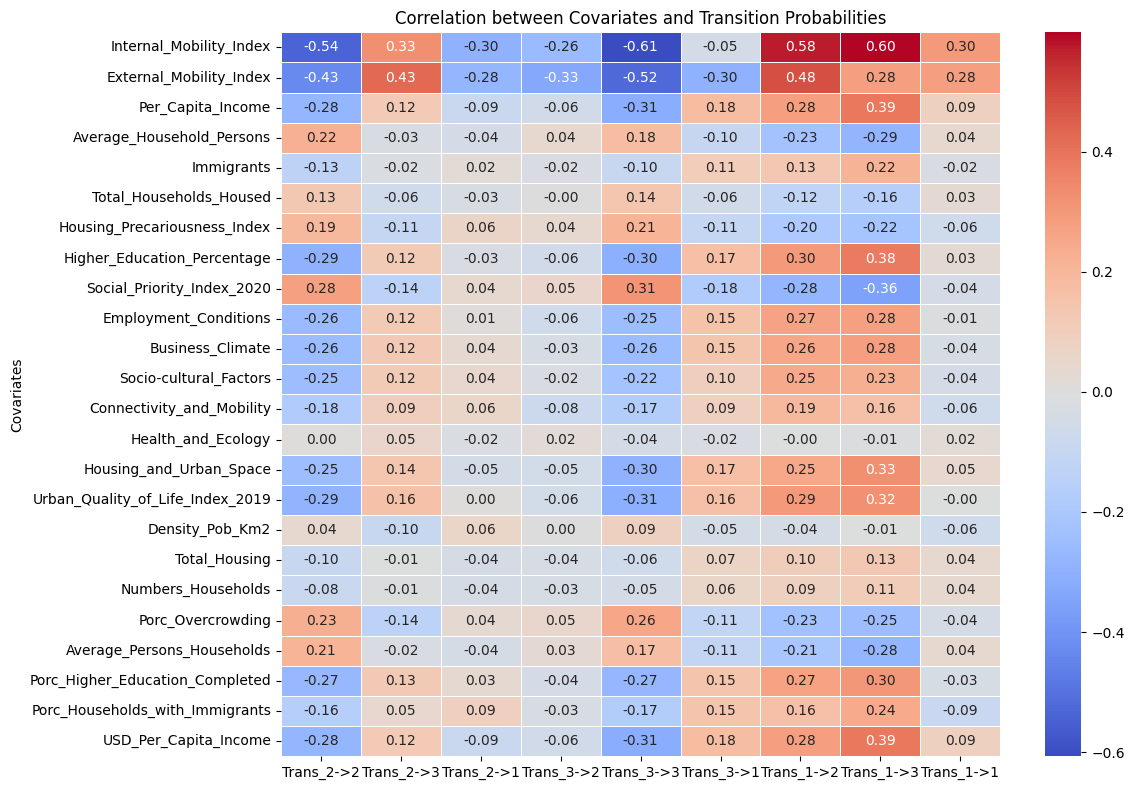

In [66]:
# Calculate the correlation matrix
correlations = analysis_df.corr().loc[
    covariates_df.columns, 
    transitions_df.columns
]

# Plot the heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation between Covariates and Transition Probabilities")
plt.xlabel(None)
plt.ylabel("Covariates")
plt.tight_layout()
plt.show()


In [67]:

transitions = []


for idx, matriz in enumerate(transition_matrix):
    for from_state in range(len(matriz)):
        for to_state in range(len(matriz[from_state])):
            transitions.append({
                'Original_Day':  viterbi_merged.iloc[idx]['Days'],  # Original day on final basis
                'Correlative_Day': idx,  # Index or correlative day generated
                'Commune': viterbi_merged.iloc[idx]['Commune'],  # Commune associated to the day
                'from_state': from_state + 1,  
                'to_state': to_state + 1,     
                'probability': matriz[from_state][to_state]
            })

transitions_df = pd.DataFrame(transitions)

transitions_df['Transition'] = (
    "Trans_" + transitions_df['from_state'].astype(str) + "->" + transitions_df['to_state'].astype(str)
)




In [68]:
transitions_df.head()

Original_Day  Correlative_Day    Commune  from_state  to_state  probability  \
0   2020-04-02                0  Cerrillos           1         1     0.988007   
1   2020-04-02                0  Cerrillos           1         2     0.001919   
2   2020-04-02                0  Cerrillos           1         3     0.007732   
3   2020-04-02                0  Cerrillos           2         1     0.010587   
4   2020-04-02                0  Cerrillos           2         2     0.998081   

   Transition  
0  Trans_1->1  
1  Trans_1->2  
2  Trans_1->3  
3  Trans_2->1  
4  Trans_2->2

In [69]:
# Rearrange the states to match the desired interpretation:
remap_transition_states = {'Trans_1->1':'Trans_2->2','Trans_1->2':'Trans_2->3','Trans_1->3':'Trans_2->1','Trans_2->2':'Trans_3->3','Trans_2->3':'Trans_3->1',
                           'Trans_3->1':'Trans_1->2','Trans_3->2':'Trans_1->3','Trans_3->3':'Trans_1->1','Trans_2->1':'Trans_3->2'}

transitions_df['Reordened_Transition'] = transitions_df['Transition'].map(remap_transition_states)

In [70]:
# Pivot to have the transitions as columns
transitions_df = transitions_df.pivot(
    index=['Commune', 'Original_Day', 'Correlative_Day'],  # Add both day references
    columns='Reordened_Transition',
    values='probability'
).reset_index()


print("DataFrame of transitions updated:")
print(transitions_df.head())


DataFrame of transitions updated:
Reordened_Transition    Commune Original_Day  Correlative_Day  Trans_1->1  \
0                     Cerrillos   2020-04-02                0    0.992268   
1                     Cerrillos   2020-04-03                1    0.991126   
2                     Cerrillos   2020-04-04                2    0.989853   
3                     Cerrillos   2020-04-05                3    0.984629   
4                     Cerrillos   2020-04-06                4    0.982625   

Reordened_Transition  Trans_1->2    Trans_1->3  Trans_2->1  Trans_2->2  \
0                       0.001407  3.676253e-16    0.007732    0.988007   
1                       0.000724  3.998440e-17    0.008874    0.981707   
2                       0.000231  1.161598e-18    0.010147    0.962216   
3                       0.003209  6.806549e-16    0.015371    0.984126   
4                       0.000072  1.358643e-20    0.017375    0.890539   

Reordened_Transition  Trans_2->3    Trans_3->1  Trans_3->2

In [71]:
transitions_df.columns

Index(['Commune', 'Original_Day', 'Correlative_Day', 'Trans_1->1',
       'Trans_1->2', 'Trans_1->3', 'Trans_2->1', 'Trans_2->2', 'Trans_2->3',
       'Trans_3->1', 'Trans_3->2', 'Trans_3->3'],
      dtype='object', name='Reordened_Transition')

In [72]:
viterbi_merged.columns

Index(['state', 'S1', 'S2', 'S3', 'row_id', 'Internal_Mobility_Index',
       'External_Mobility_Index', 'Per_Capita_Income', 'Cumulative_Cases_Rate',
       'Average_Household_Persons', 'Immigrants', 'Total_Households_Housed',
       'Housing_Precariousness_Index', 'Commune', 'Date', 'Days',
       'Higher_Education_Percentage', 'Postgraduade_Percentage',
       'Social_Priority_Index_2020', 'Priority_2020', 'Code', 'Year', 'Month',
       'Step', 'Step_Label', 'Quarantine_Start_Date', 'Quarantine_End_Date',
       'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days',
       'Employment_Conditions', 'Business_Climate', 'Socio-cultural_Factors',
       'Connectivity_and_Mobility', 'Health_and_Ecology',
       'Housing_and_Urban_Space', 'Urban_Quality_of_Life_Index_2019',
       'Range_ICVU', 'Poblation', 'Density_Pob_Km2', 'Total_Housing',
       'Numbers_Households', 'Porc_Overcrowding', 'Average_Persons_Households',
       'Porc_Higher_Education_Completed', 'Porc_Households

In [73]:
# Convert transitions to “long” format
transitions_long = pd.melt(
    transitions_df,
    id_vars=['Commune', 'Original_Day', 'Correlative_Day'],  # Include both columns of days
    value_vars=['Trans_1->1', 'Trans_1->2', 'Trans_1->3', 
                'Trans_2->1', 'Trans_2->2', 'Trans_2->3', 
                'Trans_3->1', 'Trans_3->2', 'Trans_3->3'],
    var_name='Transition',
    value_name='Probability_Transition'
)

# Perform the merge to add the covariables from base_final
lmm_data = transitions_long.merge(
    viterbi_merged[['Commune', 'Days', 'Internal_Mobility_Index', 'External_Mobility_Index', 'Cumulative_Cases_Rate', 
                'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days', 'USD_Per_Capita_Income',
                'Average_Household_Persons', 'Immigrants', 'Total_Households_Housed', 
                'Housing_Precariousness_Index', 'Higher_Education_Percentage', 'Social_Priority_Index_2020',
                'Employment_Conditions','Business_Climate','Socio-cultural_Factors',
                'Connectivity_and_Mobility','Health_and_Ecology','Housing_and_Urban_Space',
                'Urban_Quality_of_Life_Index_2019','Numbers_Households','Porc_Overcrowding','Average_Persons_Households','Porc_Higher_Education_Completed','Porc_Households_with_Immigrants']],
    left_on=['Commune', 'Original_Day'],  # Use Original_day to match base_final
    right_on=['Commune', 'Days'],         # The column in base_final is ‘days’.
    how='left'
)


print("Data prepared for LMM (in long format with additional covariates):")
print(lmm_data.head())


Data prepared for LMM (in long format with additional covariates):
     Commune Original_Day  Correlative_Day  Transition  \
0  Cerrillos   2020-04-02                0  Trans_1->1   
1  Cerrillos   2020-04-03                1  Trans_1->1   
2  Cerrillos   2020-04-04                2  Trans_1->1   
3  Cerrillos   2020-04-05                3  Trans_1->1   
4  Cerrillos   2020-04-06                4  Trans_1->1   

   Probability_Transition       Days  Internal_Mobility_Index  \
0                0.992268 2020-04-02                 1.970381   
1                0.991126 2020-04-03                 1.845790   
2                0.989853 2020-04-04                 1.678598   
3                0.984629 2020-04-05                 1.736766   
4                0.982625 2020-04-06                 1.331296   

   External_Mobility_Index  Cumulative_Cases_Rate  Gross_Daily_Cases  ...  \
0                 7.804008               2.248303           2.248303  ...   
1                 7.471452             

In [74]:
lmm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65484 entries, 0 to 65483
Data columns (total 30 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Commune                                  65484 non-null  object        
 1   Original_Day                             65484 non-null  datetime64[ns]
 2   Correlative_Day                          65484 non-null  int64         
 3   Transition                               65484 non-null  object        
 4   Probability_Transition                   65484 non-null  float64       
 5   Days                                     65484 non-null  datetime64[ns]
 6   Internal_Mobility_Index                  65484 non-null  float64       
 7   External_Mobility_Index                  65484 non-null  float64       
 8   Cumulative_Cases_Rate                    65484 non-null  float64       
 9   Gross_Daily_Cases                      

C:\Users\ferna\AppData\Local\Temp\ipykernel_2712\703722385.py:67: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(right=1.5)  # Dar más espacio horizontal para la leyenda


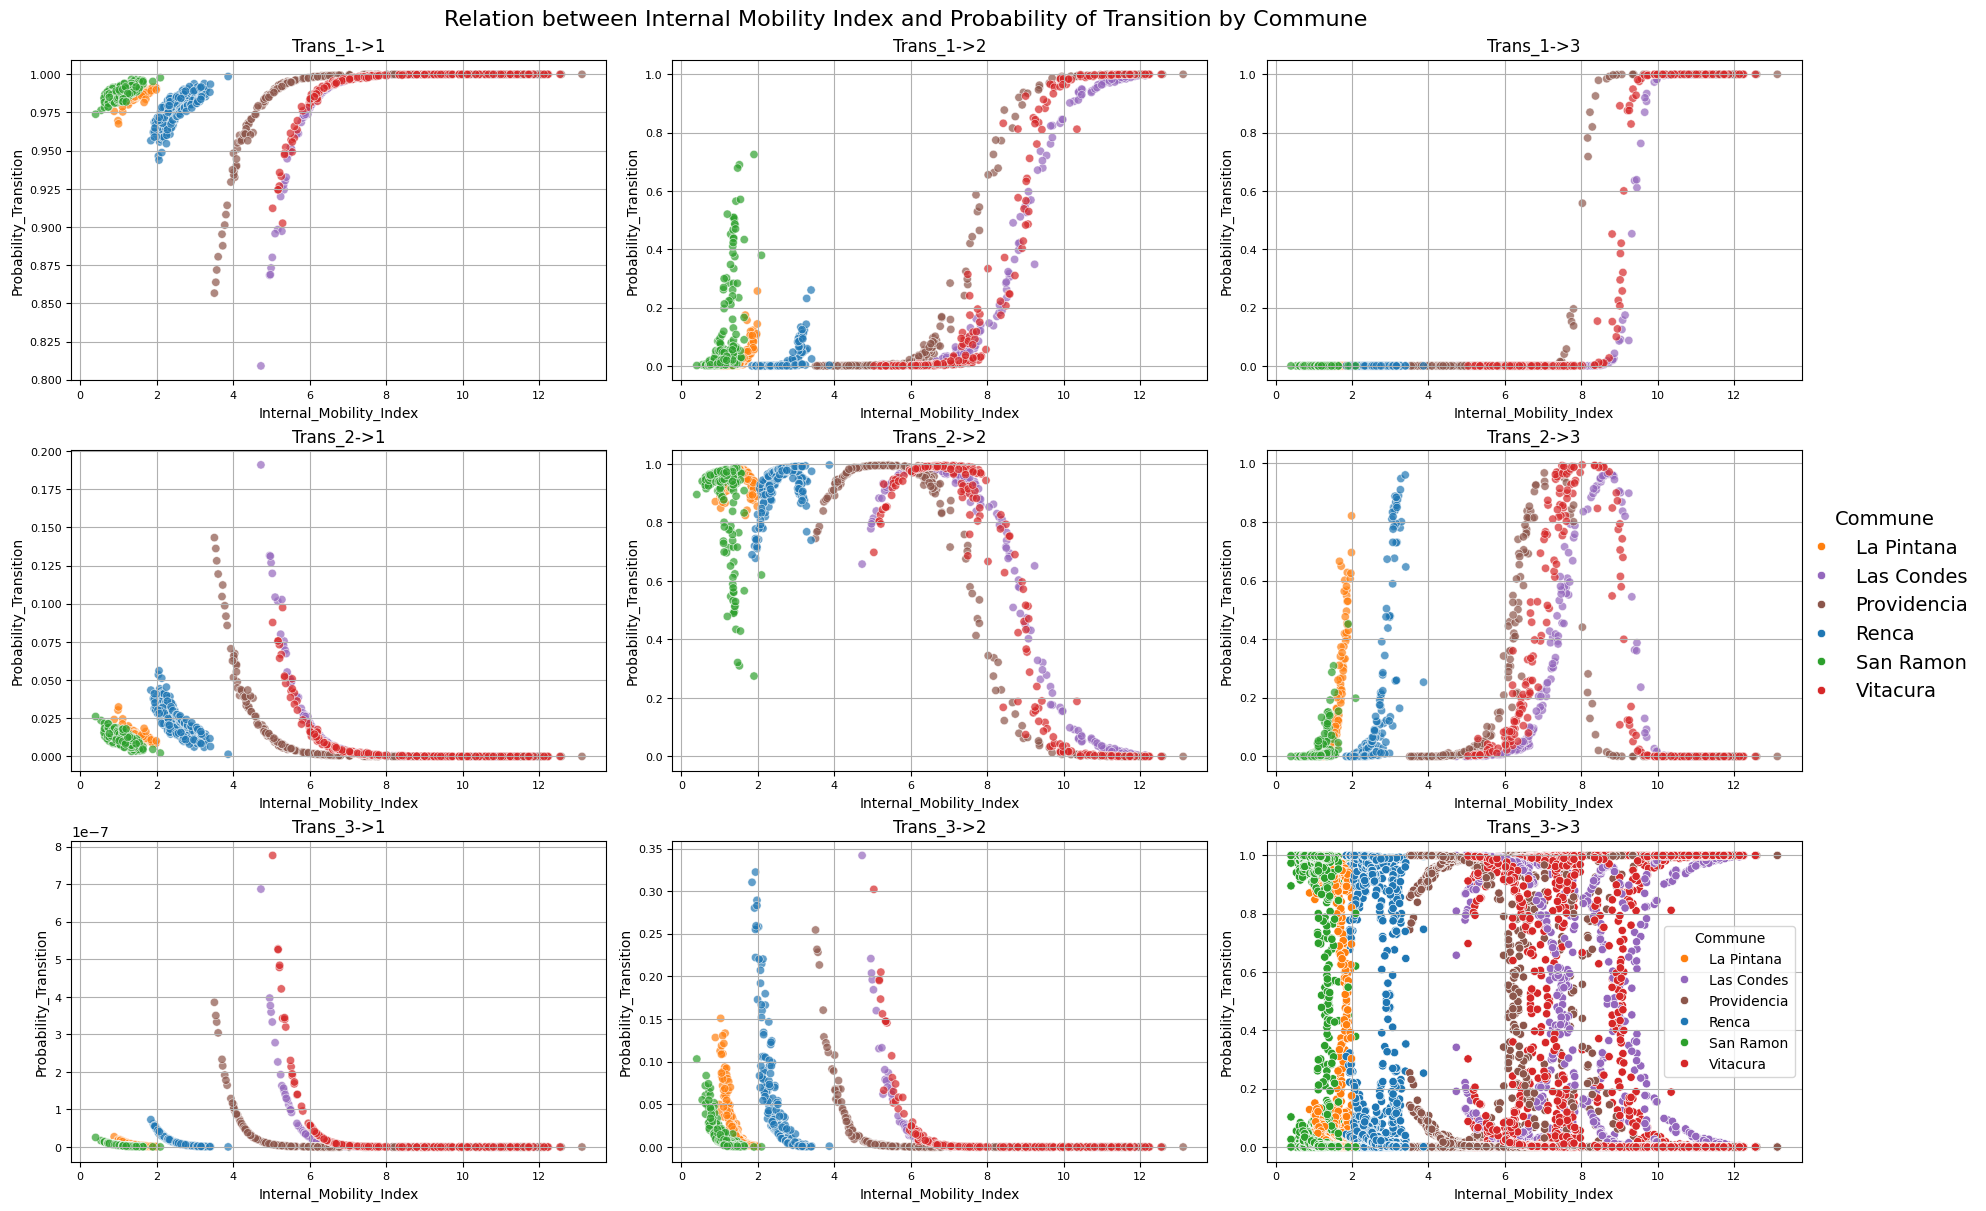

In [75]:
# Filtrar los datos para las comunas específicas
filtered_communes = lmm_data[(lmm_data['Commune'] == 'Renca') | (lmm_data['Commune'] == 'La Pintana') | (lmm_data['Commune'] == 'San Ramon') | (lmm_data['Commune'] == 'Vitacura') | (lmm_data['Commune'] == 'Las Condes')| (lmm_data['Commune'] == 'Providencia')]

# Lista de transiciones únicas
transiciones_unicas = filtered_communes['Transition'].unique()
# Define a custom palette with one specific color correction
custom_palette = {
    'Renca': '#1f77b4',          # Blue
    'La Pintana': '#ff7f0e',     # Orange
    'San Ramon': '#2ca02c',      # Green
    'Vitacura': '#d62728',       # Bright Red
    'Las Condes': '#9467bd',     # Purple
    'Providencia': '#8c564b'     # Dark Brown
}
# Filtrar los datos para las comunas específicas
filtered_communes = lmm_data[lmm_data['Commune'].isin(custom_palette.keys())]



# Configurar la figura con subplots
num_transiciones = len(transiciones_unicas)
fig, axes = plt.subplots(
    nrows=(num_transiciones + 2) // 3,  # Filas (3 gráficos por fila)
    ncols=3,  # Columnas
    figsize=(18, 12),
    constrained_layout=True
)

# Aplanar los ejes para iterar fácilmente
axes = axes.flatten()

# Crear gráficos separados por transición
for i, transicion in enumerate(transiciones_unicas):
    sns.scatterplot(
        data=filtered_communes[filtered_communes['Transition'] == transicion],
        x='Internal_Mobility_Index',
        y='Probability_Transition',
        hue='Commune',  # Color basado en la comuna
        palette=custom_palette,  # Use the custom color palette
        alpha=0.7,
        legend=False,  # Eliminar leyendas de los subplots individuales
        ax=axes[i]
    )
    axes[i].set_title(f'{transicion}', fontsize=12)
    axes[i].set_xlabel('Internal_Mobility_Index', fontsize=10)
    axes[i].set_ylabel('Probability_Transition', fontsize=10)
    axes[i].grid(True)
    axes[i].tick_params(axis='both', labelsize=8)

# Crear una única leyenda para toda la figura
handles, labels = sns.scatterplot(
    data=filtered_communes,
    x='Internal_Mobility_Index',
    y='Probability_Transition',
    hue='Commune',
    palette=custom_palette,  # Use the custom color palette
    legend=True
).get_legend_handles_labels()

fig.legend(
    handles, labels, loc='center right', title='Commune',
    fontsize=14, title_fontsize=14, bbox_to_anchor=(1.1, 0.5),
    frameon=False  # Agregar un cuadro a la leyenda
)

# Ajustar el espacio entre gráficos y la leyenda
plt.subplots_adjust(right=1.5)  # Dar más espacio horizontal para la leyenda

# Deshabilitar los subplots vacíos si hay más ejes que gráficos
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Título general
fig.suptitle('Relation between Internal Mobility Index and Probability of Transition by Commune', fontsize=16)
plt.show()

C:\Users\ferna\AppData\Local\Temp\ipykernel_2712\48753462.py:67: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(right=1.5)  # Dar más espacio horizontal para la leyenda


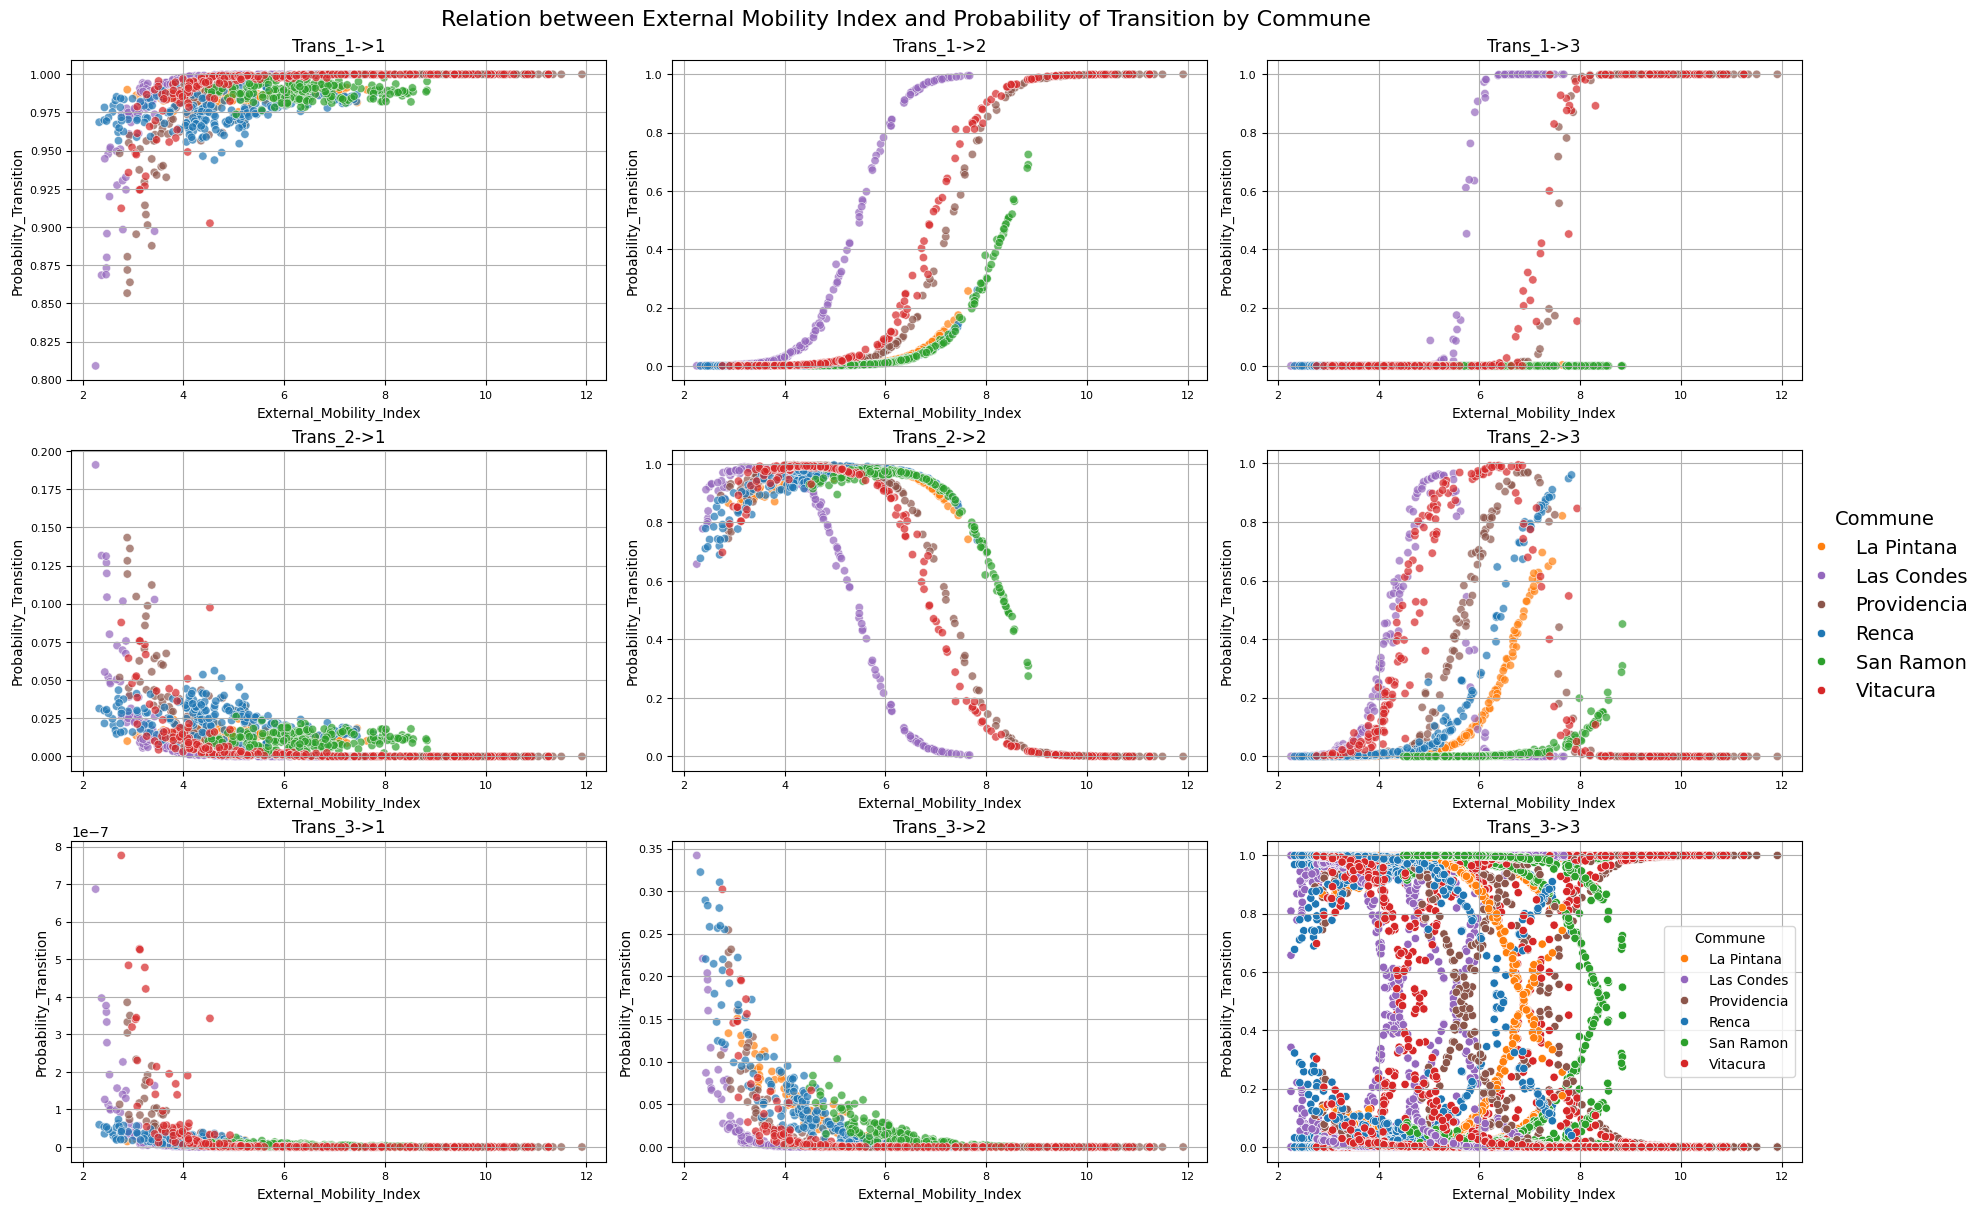

In [76]:
# Filtrar los datos para las comunas específicas
filtered_communes = lmm_data[(lmm_data['Commune'] == 'Renca') | (lmm_data['Commune'] == 'La Pintana') | (lmm_data['Commune'] == 'San Ramon') | (lmm_data['Commune'] == 'Vitacura') | (lmm_data['Commune'] == 'Las Condes')| (lmm_data['Commune'] == 'Providencia')]

# Lista de transiciones únicas
transiciones_unicas = filtered_communes['Transition'].unique()
# Define a custom palette with one specific color correction
custom_palette = {
    'Renca': '#1f77b4',          # Blue
    'La Pintana': '#ff7f0e',     # Orange
    'San Ramon': '#2ca02c',      # Green
    'Vitacura': '#d62728',       # Bright Red
    'Las Condes': '#9467bd',     # Purple
    'Providencia': '#8c564b'     # Dark Brown
}
# Filtrar los datos para las comunas específicas
filtered_communes = lmm_data[lmm_data['Commune'].isin(custom_palette.keys())]



# Configurar la figura con subplots
num_transiciones = len(transiciones_unicas)
fig, axes = plt.subplots(
    nrows=(num_transiciones + 2) // 3,  # Filas (3 gráficos por fila)
    ncols=3,  # Columnas
    figsize=(18, 12),
    constrained_layout=True
)

# Aplanar los ejes para iterar fácilmente
axes = axes.flatten()

# Crear gráficos separados por transición
for i, transicion in enumerate(transiciones_unicas):
    sns.scatterplot(
        data=filtered_communes[filtered_communes['Transition'] == transicion],
        x='External_Mobility_Index',
        y='Probability_Transition',
        hue='Commune',  # Color basado en la comuna
        palette=custom_palette,  # Use the custom color palette
        alpha=0.7,
        legend=False,  # Eliminar leyendas de los subplots individuales
        ax=axes[i]
    )
    axes[i].set_title(f'{transicion}', fontsize=12)
    axes[i].set_xlabel('External_Mobility_Index', fontsize=10)
    axes[i].set_ylabel('Probability_Transition', fontsize=10)
    axes[i].grid(True)
    axes[i].tick_params(axis='both', labelsize=8)

# Crear una única leyenda para toda la figura
handles, labels = sns.scatterplot(
    data=filtered_communes,
    x='External_Mobility_Index',
    y='Probability_Transition',
    hue='Commune',
    palette=custom_palette,  # Use the custom color palette
    legend=True
).get_legend_handles_labels()

fig.legend(
    handles, labels, loc='center right', title='Commune',
    fontsize=14, title_fontsize=14, bbox_to_anchor=(1.1, 0.5),
    frameon=False  # Agregar un cuadro a la leyenda
)

# Ajustar el espacio entre gráficos y la leyenda
plt.subplots_adjust(right=1.5)  # Dar más espacio horizontal para la leyenda

# Deshabilitar los subplots vacíos si hay más ejes que gráficos
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Título general
fig.suptitle('Relation between External Mobility Index and Probability of Transition by Commune', fontsize=16)
plt.show()

In [77]:
lmm_data.head()

Commune Original_Day  Correlative_Day  Transition  \
0  Cerrillos   2020-04-02                0  Trans_1->1   
1  Cerrillos   2020-04-03                1  Trans_1->1   
2  Cerrillos   2020-04-04                2  Trans_1->1   
3  Cerrillos   2020-04-05                3  Trans_1->1   
4  Cerrillos   2020-04-06                4  Trans_1->1   

   Probability_Transition       Days  Internal_Mobility_Index  \
0                0.992268 2020-04-02                 1.970381   
1                0.991126 2020-04-03                 1.845790   
2                0.989853 2020-04-04                 1.678598   
3                0.984629 2020-04-05                 1.736766   
4                0.982625 2020-04-06                 1.331296   

   External_Mobility_Index  Cumulative_Cases_Rate  Gross_Daily_Cases  ...  \
0                 7.804008               2.248303           2.248303  ...   
1                 7.471452               4.496605           2.248303  ...   
2                 6.891732               4.496605           0.000000  ...   
3                 8.317872               4.496605           0.000000  ...   
4                 6.378498               4.496605           0.000000  ...   

   Socio-cultural_Factors  Connectivity_and_Mobility  Health_and_Ecology  \
0                   41.83                      62.03               49.66   
1                   41.83                      62.03               49.66   
2                   41.83                      62.03               49.66   
3                   41.83                      62.03               49.66   
4                   41.83                      62.03               49.66   

   Housing_and_Urban_Space  Urban_Quality_of_Life_Index_2019  \
0                     30.8                             47.82   
1                     30.8                             47.82   
2                     30.8                             47.82   
3                     30.8                             47.82   
4                     30.8                             47.82   

   Numbers_Households  Porc_Overcrowding  Average_Persons_Households  \
0               24031                  9                         3.3   
1               24031                  9                         3.3   
2               24031                  9                         3.3   
3               24031                  9                         3.3   
4               24031                  9                         3.3   

   Porc_Higher_Education_Completed  Porc_Households_with_Immigrants  
0                               72                                7  
1                               72                                7  
2                               72                                7  
3                               72                                7  
4                               72                                7  

[5 rows x 30 columns]

In [78]:
lmm_data.tail()

Commune Original_Day  Correlative_Day  Transition  \
65479  Vitacura   2020-10-28             7271  Trans_3->3   
65480  Vitacura   2020-10-29             7272  Trans_3->3   
65481  Vitacura   2020-10-30             7273  Trans_3->3   
65482  Vitacura   2020-10-31             7274  Trans_3->3   
65483  Vitacura   2020-11-01             7275  Trans_3->3   

       Probability_Transition       Days  Internal_Mobility_Index  \
65479            5.558845e-17 2020-10-28                11.752247   
65480            1.761284e-17 2020-10-29                11.723245   
65481            9.607401e-20 2020-10-30                12.242963   
65482            8.438947e-20 2020-10-31                12.230152   
65483            2.852477e-20 2020-11-01                12.133123   

       External_Mobility_Index  Cumulative_Cases_Rate  Gross_Daily_Cases  ...  \
65479                10.043483            1868.270403           3.100006  ...   
65480                10.362570            1871.370409           3.100006  ...   
65481                10.786483            1874.470416           3.100006  ...   
65482                10.837468            1876.537086           2.066671  ...   
65483                11.248013            1879.637093           3.100006  ...   

       Socio-cultural_Factors  Connectivity_and_Mobility  Health_and_Ecology  \
65479                    56.4                      82.77               65.56   
65480                    56.4                      82.77               65.56   
65481                    56.4                      82.77               65.56   
65482                    56.4                      82.77               65.56   
65483                    56.4                      82.77               65.56   

       Housing_and_Urban_Space  Urban_Quality_of_Life_Index_2019  \
65479                    84.67                             75.59   
65480                    84.67                             75.59   
65481                    84.67                             75.59   
65482                    84.67                             75.59   
65483                    84.67                             75.59   

       Numbers_Households  Porc_Overcrowding  Average_Persons_Households  \
65479               28115                  1                         3.0   
65480               28115                  1                         3.0   
65481               28115                  1                         3.0   
65482               28115                  1                         3.0   
65483               28115                  1                         3.0   

       Porc_Higher_Education_Completed  Porc_Households_with_Immigrants  
65479                               83                               21  
65480                               83                               21  
65481                               83                               21  
65482                               83                               21  
65483                               83                               21  

[5 rows x 30 columns]

In [79]:
lmm_data.to_csv('../data/processed/lmm_data.csv', index=False)

_______________